In [22]:
#importing all the librairy / header files
from copy import deepcopy
import numpy as np

import scipy.io as sio #for input from mat file
import itertools #dependency for confusion matrix

from matplotlib import pyplot as plt#for plotting graphs
from sklearn.cluster import MiniBatchKMeans,KMeans 
from sklearn import preprocessing #for feature scaling
from sklearn.decomposition import PCA # for PCA (dimensionality reduction)

from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [23]:
#splits the numpy array into two parts accoding to the condintion cond
def split(arr, cond):
  return [arr[cond], arr[~cond]]

In [24]:
#taking input ( 286 dim feature vector) fromamt files generated by matlab preprocessing code
#the matlab code is taken from http://vision.cs.uiuc.edu/projects/activity/
#special thanks to Du Tran, Alexander Sorokin, and David Forsyth 
#for provding the code in their website under open source liscence
cam0_label = sio.loadmat('IXMAS\IXMAS_cam0_labels.mat')
cam0_feature = sio.loadmat('IXMAS\IXMAS_cam0_win_feature.mat')
cam1_label = sio.loadmat('IXMAS\IXMAS_cam1_labels.mat')
cam1_feature = sio.loadmat('IXMAS\IXMAS_cam1_win_feature.mat')
cam2_label = sio.loadmat('IXMAS\IXMAS_cam2_labels.mat')
cam2_feature = sio.loadmat('IXMAS\IXMAS_cam2_win_feature.mat')
cam3_label = sio.loadmat('IXMAS\IXMAS_cam3_labels.mat')
cam3_feature = sio.loadmat('IXMAS\IXMAS_cam3_win_feature.mat')
cam4_label = sio.loadmat('IXMAS\IXMAS_cam4_labels.mat')
cam4_feature = sio.loadmat('IXMAS\IXMAS_cam4_win_feature.mat')


In [25]:
#extrating mat file contents to numpy array
cam0_l = cam0_label['labels']
cam1_l = cam1_label['labels']
cam2_l = cam2_label['labels']
cam3_l = cam3_label['labels']
cam4_l = cam4_label['labels']
cam0_f = cam0_feature['win_feature']
cam1_f = cam1_feature['win_feature']
cam2_f = cam2_feature['win_feature']
cam3_f = cam3_feature['win_feature']
cam4_f = cam4_feature['win_feature']

#each of the cam<i>_l_train and cam<i>_f_train contains actions performed by first 7 actors 
cam0_l_train , cam0_l_test = split(cam0_l , cam0_l[:, 0]<22)
cx , cy = np.shape(cam0_l_train)
cam0_f_train = cam0_f[:cx ,:]
cam0_f_test = cam0_f[cx: , :]

cam1_l_train , cam1_l_test = split(cam1_l , cam1_l[:, 0]<22)
cx , cy = np.shape(cam1_l_train)
cam1_f_train = cam1_f[:cx ,:]
cam1_f_test = cam1_f[cx: , :]

cam2_l_train , cam2_l_test = split(cam2_l , cam2_l[:, 0]<22)
cx , cy = np.shape(cam2_l_train)
cam2_f_train = cam2_f[:cx ,:]
cam2_f_test = cam2_f[cx: , :]

cam3_l_train , cam3_l_test = split(cam3_l , cam3_l[:, 0]<22)
cx , cy = np.shape(cam3_l_train)
cam3_f_train = cam3_f[:cx ,:]
cam3_f_test = cam3_f[cx: , :]

cam4_l_train , cam4_l_test = split(cam4_l , cam4_l[:, 0]<22)
cx , cy = np.shape(cam4_l_train)
cam4_f_train = cam4_f[:cx ,:]
cam4_f_test = cam4_f[cx: , :]

#each of the cam<i>_l_test and cam<i>_f_test contains actions performed by actors 8, 9 ,10 
cam0_l_test , cam_l_dummy = split(cam0_l_test , cam0_l_test[:, 0]<31)
cx , cy = np.shape(cam0_l_test)
cam0_f_test = cam0_f_test[:cx ,:]
cam_f_dummy = cam0_f_test[cx: , :]

cam1_l_test , cam_l_dummy = split(cam1_l_test , cam1_l_test[:, 0]<31)
cx , cy = np.shape(cam1_l_test)
cam1_f_test = cam1_f_test[:cx ,:]
cam_f_dummy = cam1_f_test[cx: , :]

cam2_l_test , cam_l_dummy = split(cam2_l_test , cam2_l_test[:, 0]<31)
cx , cy = np.shape(cam2_l_test)
cam2_f_test = cam2_f_test[:cx ,:]
cam_f_dummy = cam2_f_test[cx: , :]

cam3_l_test , cam_l_dummy = split(cam3_l_test , cam3_l_test[:, 0]<31)
cx , cy = np.shape(cam3_l_test)
cam3_f_test = cam3_f_test[:cx ,:]
cam_f_dummy = cam3_f_test[cx: , :]

cam4_l_test , cam_l_dummy = split(cam4_l_test , cam4_l_test[:, 0]<31)
cx , cy = np.shape(cam4_l_test)
cam4_f_test = cam4_f_test[:cx ,:]
cam_f_dummy = cam4_f_test[cx: , :]


print(np.shape(cam0_f_train))
print(np.shape(cam1_f_train))
print(np.shape(cam2_f_train))
print(np.shape(cam3_f_train))
print(np.shape(cam4_f_train))
print(np.shape(cam0_f_test))
print(np.shape(cam1_f_test))
print(np.shape(cam2_f_test))
print(np.shape(cam3_f_test))
print(np.shape(cam4_f_test)) 


(24653, 286)
(24675, 286)
(24696, 286)
(24716, 286)
(24736, 286)
(10104, 286)
(10113, 286)
(10122, 286)
(10131, 286)
(10140, 286)


# feature reorganization
>* now need to group features ( from all cameras ) of each class( action category) seperatly<br>
>* making a list of dimensions 14 * n * 286 ( [action_i][number of frames] [ features])<br> 
> where n is the number of frames belonging to action_i<br>
>* we make an list feature_per_class which is of the form
>> feature_per_class [ i ] [ j ] = feature vector of jth frame of the action number i <br>
>> label_per_class [ i ] [ j ] = correctlabel of jth frame of the action number i 

In [26]:
#function to perform the feature reorganization described above 
def extract_features_per_class( cam_l , cam_f , feature_per_class , label_per_class):
    j = 0 ;
    for i in cam_l:
        feature_per_class[ i[1] ].append( cam_f[j] ) ;
        label_per_class[ i[1] ].append( cam_l[j] ) ;
        j += 1 ;

In [27]:
total_class = 14
feature_per_class = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
label_per_class = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
extract_features_per_class( cam0_l_train ,cam0_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam1_l_train ,cam1_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam2_l_train ,cam2_f_train , feature_per_class ,label_per_class )
extract_features_per_class( cam3_l_train ,cam3_f_train , feature_per_class ,label_per_class)
extract_features_per_class( cam4_l_train ,cam4_f_train , feature_per_class ,label_per_class)


In [28]:
#checking how many frames belong to each class
#for i in feature_per_class:
    #print(len(i))

### To build the dictionary of keyposes-
- the feature descriptors for every fourth frame in the training data are clustered via the mini batch k-means - algorithm.<br>
- For these experiments, k was set to 200 clusters per class.<br> 
- We initialized k-means 5 times and selected the cluster assignment with minimum error, as measured by average intra-class similarity.<br>
- We choose K = 2600 for IXMAS.<br>
Input:<br>
feature vector for all frames of all videos<br>
Output:<br>
Key poses and their weights <br>
Let 𝑘 represents the number of clusters,<br>
𝐴 = {𝑎1,𝑎2,...𝑎𝑟}be the set of actions,<br>
𝑝𝑖𝑗 denotes 𝑗 − 𝑡ℎ key pose of action 𝑖 and 𝑤𝑖𝑗 be the its weight <br>
> 1: for all action 𝑎 ∈ 𝐴 do <br>
2: 		Cluster all frames into k groups using k-means <br>
3: 		Take cluster centers as keyposes thus ending up with 𝑟×𝑘 key poses <br> 
4: endfor <br>

In [29]:
keyposes = []#to store all the keyposes belong to class i
total_cluster = 0 
#implementing perclass mini batch k-means
for i in range(0,14):
    k = 200 ;
    total_cluster+=k
    X = np.array(feature_per_class[i])
    # Number of clusters
    kmeans = MiniBatchKMeans(init = 'random' , n_clusters=k)
    # Fitting the input data
    kmeans = kmeans.fit(X)
    # Getting the cluster labels
    labels = kmeans.predict(X)
    # Centroid values
    centroids = kmeans.cluster_centers_
    print ( kmeans.inertia_ ) ;#printing error associated with each class
    keyposes.append(centroids)
    #np.concatenate((keyposes , centroids) , axis = 0); 


122685.970959
25260.7548299
27991.9093751
33973.3185154
28695.0578595
33210.4583719
34230.3317378
50945.9113225
30131.9542388
27395.9088991
38400.8699275
35907.0137043
24263.9231737
18966.6422171


In [30]:
#we can control on what actions we need to implement our method by below variables
start = 1 #starting action number
endd = 13 #ending action number

In [31]:
#input- feature vetor of a frame 
#output- keypose alloted to the frame along with error associated and actual list of 286 points describing the keypose
def get_keypose(frame_ij):#returns keypose_action , keypose_num , error , actual_keypose
    keypose_in = 0 
    dist = np.linalg.norm(frame_ij - keyposes[start][0])
    keypose_temp = [start, 0,dist,keyposes[start][0]]
    cnt = 0
    for k in keyposes:
        if cnt >= start and cnt<=endd:
            keypose_num = 0
            for l in k:
                if dist > abs(np.linalg.norm(frame_ij - l)):
                    dist = abs(np.linalg.norm(frame_ij - l))
                    keypose_temp = [keypose_in , keypose_num,dist,l]
                keypose_num = keypose_num +1
        keypose_in = keypose_in + 1
        cnt+=1
    return keypose_temp 
# keypose_temp = [ action_number  , keypose number of that action , error]

In [32]:
#alloting each frame of a action to keypose
#here we are obtaining keyposes alloted to each frame of each class and storing it in list alloted_keypose 
error = 0
alloted_keypose =  [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

#alloted keypose has for each action keypose alloted
for action_ in range(start,endd+1):
    cnt = 0
    list_for_action = []#stores list of keypose_temp for each frame for action action_
    for j in feature_per_class[action_]:
        #j is frame_ij
        keypose_temp = get_keypose(j)    
        list_for_action.append( keypose_temp )
        error += keypose_temp[2]
        #print(action_,cnt,sep='\t')
        cnt+=1
    alloted_keypose[ action_ ].append(list_for_action)
#print(error)

In [33]:
#printing the final error obtained after all the allotment
print(error)

192876.615367


In [34]:
#hashing/counting  all the frames of a action alloted to a particular keypose
keypose_statistics = np.zeros((14,200,14))#will store for keypose_statistics[action][keypose_number][action]
#the above variable will store for each keypose how many frames are alloted to it for each action
action_number = 0
for i in alloted_keypose:#starting to watch allotment from action 1
    #if len(i) > 0:
    cnt = 0 
    for j in i:
 
        for kk in j:# kk is keypose temp
            cnt+=1
            keypose_statistics[kk[0]][kk[1]][action_number]+=1
   
    action_number+=1

In [35]:
#studying and analyzing for each keypose , the  number of frames of an action assigned to it

for i in range(0,14):
    print('keyposes belong to action = ',i)
    sum1 = 0
    sum2 = np.zeros((1,14))
    cnt = 0
    for j in range(0,200):
        summ = np.sum(keypose_statistics[i][j][:])
        if summ>0:
            sum1 += summ
            for k in range(0,14):
                sum2[0][k]+=keypose_statistics[i][j][k]
            #print(cnt,keypose_statistics[i][j][start:endd+1],sep='\t')
        cnt+=1
    #print('keyposes belonging to actions',i,' have = ',sum1,'frames',sep='\t')
    print(sum2)
    print(np.max(sum2)/sum1)

keyposes belong to action =  0
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
nan
keyposes belong to action =  1
[[    0.  4885.   581.   789.    56.    51.    54.    29.   410.   173.
    112.   253.    26.    63.]]
0.652900294039
keyposes belong to action =  2
[[    0.   499.  5640.   874.    47.    54.    47.    26.   392.   204.
    117.   300.    13.    63.]]
0.681488641856
keyposes belong to action =  3
[[    0.   483.   523.  5247.    83.    59.    52.    20.   803.   147.
    110.   299.    21.    85.]]
0.661497730711
keyposes belong to action =  4
[[    0.    10.    19.    88.  6557.   287.    84.    92.    24.    38.
     59.    44.   307.    16.]]
0.85993442623
keyposes belong to action =  5
[[    0.    33.    29.    29.   199.  6433.    77.   160.    52.    69.
    176.   128.   196.    30.]]
0.845224017869
keyposes belong to action =  6
[[    0.    21.    10.    33.    74.   114.  6752.   864.    33.    62.
    249.   107.    34.    11.]]
0.807269249163
keypos

C:\Users\Aditya\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
print(keypose_statistics[2][100])

[  0.   0.  13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


## keypose learing
>The class-discriminative power of each keypose is estimated<br>
>by the distribution P(xk | y), which is computed from<br>
>the training data using Laplace smoothing:<br>
>>#### P(xk | y) = (ND + 1) / (NA + K)<br>
>where NA is the total number of training frames with label y<br>
>and ND is the size of the subset of those frames assigned to<br>
>keypose xk .Akeypose, xk , is considered class-discriminative<br>
>if the correct label, y∗, is most likely, i.e.,<br> 
>>>#### argmax (y)    P(xk | y ) = y∗.

In [37]:
#calculating the above probabity and storing in probability_keypose
probability_keypose = np.zeros(( 14,200 , 14))

#argmx stores for all the keypose the action number for which it has the highest above probabiliy
#argmx [ i] [ j ]  = for all k : max(  probability_keypose[ i ] [ j ] [ k ])

argmx = [[[] for i in range ( 0 , 200 ) ] for j in range(0,14)] ;

total_cluster = (endd-start+1)*200;



for keypose_index in range ( 0 , 14 ):
    for keypose_num in range ( 0 , 200 ) :
        mx_prob = 0.0 ;
        for action_y in range(0,14,1) :
            if (action_y < start or action_y > endd ) :
                continue ;
            probability_keypose[ keypose_index ][keypose_num][ action_y ] = ( keypose_statistics[keypose_index][keypose_num][ action_y ] + 1)
            probability_keypose[ keypose_index ][keypose_num][ action_y ] /= ( len(feature_per_class[action_y]) + total_cluster ) 
            if ( probability_keypose[keypose_index][keypose_num][action_y] > mx_prob ) :
                argmx[keypose_index][keypose_num] = [action_y] ;
                mx_prob = probability_keypose[keypose_index][keypose_num][action_y] ;
            elif ( probability_keypose[keypose_index][keypose_num][action_y] == mx_prob ) :
                argmx[keypose_index][keypose_num].append ( action_y ) ;
        indices = np.where(probability_keypose[keypose_index][keypose_num] == probability_keypose[keypose_index][keypose_num] .max())
        if keypose_index!=indices[0][0] and keypose_index>=start and keypose_index<=endd:
            print(keypose_index , indices[0], sep='\t')

1	[9]
1	[2]
1	[13]
1	[2]
2	[3]
2	[3]
2	[3]
5	[9]
5	[7]
7	[6]
7	[6]
7	[9]
7	[11]
7	[12]
8	[2]
9	[1]
10	[9]
10	[13]
11	[3]
11	[13]
12	[5]
12	[5]
12	[13]


In [38]:
#organizing dataset making for the Q-learing 
#run cell 2 first and then this
#each of the cam<i>_l_train and cam<i>_f_train will contain all the frames for all the actions in range 
#[ start , endd ] for actors 1 to 7 


start = start
finish = endd

cam_f_train_size = np.shape( cam0_f_train )[0] ;

new_feature = [] ;
new_label = [] ;

for i in range ( cam_f_train_size ) :
    if ( cam0_l_train[i][1] >= start and cam0_l_train[i][1] <= finish ) :
        new_feature.append ( cam0_f_train[i] ) ;
        new_label.append ( cam0_l_train[i] ) ;
cam0_f_train = new_feature ;
cam0_l_train = new_label ;
cam_f_train_size = np.shape( cam1_f_train )[0] ;

new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam1_l_train[i][1] >= start and cam1_l_train[i][1] <= finish ) :
        new_feature.append ( cam1_f_train[i] ) ;
        new_label.append ( cam1_l_train[i] ) ;
cam1_f_train = new_feature ;
cam1_l_train = new_label ;

cam_f_train_size = np.shape( cam2_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam2_l_train[i][1] >= start and cam2_l_train[i][1] <= finish ) :
        new_feature.append ( cam2_f_train[i] ) ;
        new_label.append ( cam2_l_train[i] ) ;
cam2_f_train = new_feature ;
cam2_l_train = new_label ;

cam_f_train_size = np.shape( cam3_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam3_l_train[i][1] >= start and cam3_l_train[i][1] <= finish ) :
        new_feature.append ( cam3_f_train[i] ) ;
        new_label.append ( cam3_l_train[i] ) ;
cam3_f_train = new_feature ;
cam3_l_train = new_label ;

cam_f_train_size = np.shape( cam4_f_train )[0] ;
new_feature = [] ;
new_label = [] ;
for i in range ( cam_f_train_size ) :
    if ( cam4_l_train[i][1] >= start and cam4_l_train[i][1] <= finish ) :
        new_feature.append ( cam4_f_train[i] ) ;
        new_label.append ( cam4_l_train[i] ) ;
cam4_f_train = new_feature ;
cam4_l_train = new_label ;
camera_feature = []
camera_label = []
camera_feature.append(cam0_f_train)
camera_feature.append(cam1_f_train)
camera_feature.append(cam2_f_train)
camera_feature.append(cam3_f_train)
camera_feature.append(cam4_f_train)

camera_label.append(cam0_l_train)
camera_label.append(cam1_l_train)
camera_label.append(cam2_l_train)
camera_label.append(cam3_l_train)
camera_label.append(cam4_l_train)
print ( np.shape(cam0_f_train) ) ;
print ( np.shape(cam1_f_train) ) ;
print ( np.shape(cam2_f_train) ) ;
print ( np.shape(cam3_f_train) ) ;
print ( np.shape(cam4_f_train) ) ;

(19979, 286)
(19979, 286)
(19979, 286)
(19979, 286)
(19979, 286)


## reward function
<img src="image.png" style="height:100">


In [39]:
#input - keypose_index , view_shift , actual_label
#retuns the reward associated accoring to the above description
def reward ( keypose_index , v , y_actual ):
    r = 0
    if v[0][0] != 0 or v[0][1] != 0:
        r = -0.1
    f = 0 ;
    for i in argmx[keypose_index[0]][keypose_index[1]] :
        if ( i == y_actual ) :
            f = 1 ;
    if ( f ) :
        r += 1 ;
    else :
        r -= 1 ;
    return r ;

In [40]:
#function to return the max entry of the row belonging to keypose x_ in Q table
def argmax(Q , x_ ):
    maxx = -10000000000000000
    for i in (0 , 25):
        maxx = max ( maxx , Q[x_[0]][x_[1]][i])
    return maxx

## View-shift value learning
<img src="Capture3.PNG" style="height:100">

In [41]:

#Q-learing phase is implemented here
camera_locations = []#it contains all the camera locations as visulaized on a 2 X 10 grid 
camera_locations.append([3 , 0])
camera_locations.append([4 , 0])
camera_locations.append([6 , 0])
camera_locations.append([7 , 0])
camera_locations.append([3 , 1])


Q = np.random.rand(14,200, 26)#initialzing the Q table

view_shift_map = np.zeros((5,5))# this is used to map the view shifts
# view shift from camera i to j is mapped as i*5+j so that on seing this value we can tell from which camera 
# to which camera is the view shift occuring 

#view shift mappign
for i in range( 0 , 5 , 1 ):
    for j in range( 0 , 5 , 1 ):
        view_shift_map[i][j] = i*5 + j  

iterations = 10000#setting the number of iterations

import random#importing the random libreairy of python

#setting the parameter values
learing_rate = 1.0
gamma = 0.5#discount parameter

range_number = np.shape ( camera_feature[0] )[1] ;#determining the max range from which we can chose any 
#random frame for training

while ( iterations > 0 ) :
    
    iterations -= 1
    #randomly choosing the frame number and camera number
    i = random.randint(0,range_number-1)  #frame number
    j = random.randint(0,4) # camera number
    
    frame_ij = camera_feature[j][i] # feature vector of the corresponding frame
    y_actual = camera_label[j][i][1]# actual label of the corresponding frame
    
    keypose_temp  = get_keypose(frame_ij)# find the keypose of the frame
    keypose_in = keypose_temp[0] #
    keypose_num = keypose_temp[1]
    keypose_index = [keypose_in , keypose_num]
    
    #rememeber the function get_keypose returns [keypose_action , keypose_num , error , actual_keypose]
    
    for k in range(0 , 5 ,1 ):
        #making the list representing the view shift
        v = [ [camera_locations[j][0] - camera_locations[k][0] , camera_locations[j][1] - camera_locations[k][1] ] ] 
        #getting the hash value of viewshift from camera j to k 
        cv = view_shift_map[j][k]
        #calculating the reward using above information
        r = reward( keypose_index , v ,y_actual )
        #getting the keypose of the frame which is there in the view after performing the view shift 
        x_index = get_keypose( camera_feature[k][i] )
        
        cv  = int(cv)
        #printing the iteration number the index of the keypose to which we have shifted and the viewshift hash
        print( "Iteration : " , iterations , x_index[0] ,'  ',x_index[1] , '   ' , cv) ;
        
        #updating the Q table
        Q[ x_index[0] ][ x_index[1] ][ cv ] = ( 1 - learing_rate ) * Q [ x_index[0] ][ x_index[1] ] [ cv ] + learing_rate * ( r + gamma * argmax( Q , x_index ))
   
   

Iteration :  9999 2    161     20
Iteration :  9999 2    64     21
Iteration :  9999 2    111     22
Iteration :  9999 2    67     23
Iteration :  9999 2    125     24
Iteration :  9998 3    91     10
Iteration :  9998 1    184     11
Iteration :  9998 2    91     12
Iteration :  9998 2    67     13
Iteration :  9998 2    40     14
Iteration :  9997 1    134     10
Iteration :  9997 1    57     11
Iteration :  9997 1    13     12
Iteration :  9997 1    159     13
Iteration :  9997 1    179     14
Iteration :  9996 2    193     5
Iteration :  9996 2    192     6
Iteration :  9996 2    105     7
Iteration :  9996 1    104     8
Iteration :  9996 2    44     9
Iteration :  9995 3    188     10
Iteration :  9995 3    153     11
Iteration :  9995 3    83     12
Iteration :  9995 3    178     13
Iteration :  9995 3    30     14
Iteration :  9994 4    15     15
Iteration :  9994 4    22     16
Iteration :  9994 4    27     17
Iteration :  9994 5    154     18
Iteration :  9994 4    23     19


Iteration :  9941 4    116     11
Iteration :  9941 4    9     12
Iteration :  9941 4    38     13
Iteration :  9941 8    178     14
Iteration :  9940 3    194     15
Iteration :  9940 3    12     16
Iteration :  9940 3    85     17
Iteration :  9940 3    119     18
Iteration :  9940 3    33     19
Iteration :  9939 4    198     10
Iteration :  9939 12    101     11
Iteration :  9939 4    107     12
Iteration :  9939 4    142     13
Iteration :  9939 7    152     14
Iteration :  9938 4    57     20
Iteration :  9938 4    114     21
Iteration :  9938 4    176     22
Iteration :  9938 4    29     23
Iteration :  9938 12    102     24
Iteration :  9937 2    112     15
Iteration :  9937 11    95     16
Iteration :  9937 2    91     17
Iteration :  9937 2    101     18
Iteration :  9937 2    40     19
Iteration :  9936 11    147     20
Iteration :  9936 8    181     21
Iteration :  9936 2    69     22
Iteration :  9936 2    73     23
Iteration :  9936 2    40     24
Iteration :  9935 2    3

Iteration :  9884 2    64     16
Iteration :  9884 2    69     17
Iteration :  9884 2    73     18
Iteration :  9884 2    40     19
Iteration :  9883 3    194     10
Iteration :  9883 3    115     11
Iteration :  9883 3    28     12
Iteration :  9883 8    86     13
Iteration :  9883 3    33     14
Iteration :  9882 4    171     20
Iteration :  9882 12    197     21
Iteration :  9882 4    9     22
Iteration :  9882 4    52     23
Iteration :  9882 4    69     24
Iteration :  9881 4    101     0
Iteration :  9881 4    104     1
Iteration :  9881 4    33     2
Iteration :  9881 4    92     3
Iteration :  9881 4    21     4
Iteration :  9880 2    56     15
Iteration :  9880 2    134     16
Iteration :  9880 2    111     17
Iteration :  9880 3    101     18
Iteration :  9880 3    23     19
Iteration :  9879 3    103     10
Iteration :  9879 3    15     11
Iteration :  9879 3    124     12
Iteration :  9879 3    133     13
Iteration :  9879 3    38     14
Iteration :  9878 2    122     15
It

Iteration :  9827 1    136     21
Iteration :  9827 1    114     22
Iteration :  9827 1    28     23
Iteration :  9827 1    179     24
Iteration :  9826 1    54     20
Iteration :  9826 2    64     21
Iteration :  9826 2    91     22
Iteration :  9826 2    67     23
Iteration :  9826 2    60     24
Iteration :  9825 2    33     20
Iteration :  9825 2    154     21
Iteration :  9825 2    111     22
Iteration :  9825 3    101     23
Iteration :  9825 2    125     24
Iteration :  9824 3    34     10
Iteration :  9824 1    163     11
Iteration :  9824 2    91     12
Iteration :  9824 2    101     13
Iteration :  9824 2    40     14
Iteration :  9823 4    101     5
Iteration :  9823 9    17     6
Iteration :  9823 4    33     7
Iteration :  9823 4    92     8
Iteration :  9823 4    21     9
Iteration :  9822 2    148     20
Iteration :  9822 2    42     21
Iteration :  9822 2    7     22
Iteration :  9822 2    114     23
Iteration :  9822 2    198     24
Iteration :  9821 4    171     10
It

Iteration :  9771 2    101     8
Iteration :  9771 2    40     9
Iteration :  9770 2    164     0
Iteration :  9770 1    24     1
Iteration :  9770 2    7     2
Iteration :  9770 2    59     3
Iteration :  9770 2    124     4
Iteration :  9769 4    101     20
Iteration :  9769 4    78     21
Iteration :  9769 12    167     22
Iteration :  9769 4    92     23
Iteration :  9769 4    189     24
Iteration :  9768 2    8     0
Iteration :  9768 2    72     1
Iteration :  9768 2    39     2
Iteration :  9768 3    135     3
Iteration :  9768 2    60     4
Iteration :  9767 1    129     5
Iteration :  9767 1    21     6
Iteration :  9767 2    182     7
Iteration :  9767 1    91     8
Iteration :  9767 2    76     9
Iteration :  9766 12    109     15
Iteration :  9766 4    142     16
Iteration :  9766 4    107     17
Iteration :  9766 4    142     18
Iteration :  9766 6    98     19
Iteration :  9765 3    188     15
Iteration :  9765 3    143     16
Iteration :  9765 3    83     17
Iteration : 

Iteration :  9715 7    168     19
Iteration :  9714 4    101     0
Iteration :  9714 4    104     1
Iteration :  9714 4    33     2
Iteration :  9714 4    92     3
Iteration :  9714 4    21     4
Iteration :  9713 4    57     5
Iteration :  9713 4    114     6
Iteration :  9713 4    176     7
Iteration :  9713 4    29     8
Iteration :  9713 12    102     9
Iteration :  9712 3    188     0
Iteration :  9712 3    185     1
Iteration :  9712 3    83     2
Iteration :  9712 3    178     3
Iteration :  9712 3    30     4
Iteration :  9711 4    101     15
Iteration :  9711 4    104     16
Iteration :  9711 5    57     17
Iteration :  9711 4    92     18
Iteration :  9711 4    21     19
Iteration :  9710 5    79     10
Iteration :  9710 5    33     11
Iteration :  9710 5    184     12
Iteration :  9710 5    89     13
Iteration :  9710 3    37     14
Iteration :  9709 4    171     10
Iteration :  9709 4    116     11
Iteration :  9709 4    163     12
Iteration :  9709 4    38     13
Iteration

Iteration :  9657 3    103     20
Iteration :  9657 8    98     21
Iteration :  9657 3    116     22
Iteration :  9657 3    133     23
Iteration :  9657 3    38     24
Iteration :  9656 1    134     15
Iteration :  9656 1    57     16
Iteration :  9656 1    114     17
Iteration :  9656 1    102     18
Iteration :  9656 1    179     19
Iteration :  9655 12    109     5
Iteration :  9655 4    142     6
Iteration :  9655 4    107     7
Iteration :  9655 4    142     8
Iteration :  9655 6    98     9
Iteration :  9654 4    103     10
Iteration :  9654 4    10     11
Iteration :  9654 4    160     12
Iteration :  9654 4    123     13
Iteration :  9654 4    50     14
Iteration :  9653 3    7     10
Iteration :  9653 3    56     11
Iteration :  9653 3    85     12
Iteration :  9653 3    119     13
Iteration :  9653 3    33     14
Iteration :  9652 1    133     10
Iteration :  9652 1    14     11
Iteration :  9652 8    115     12
Iteration :  9652 8    125     13
Iteration :  9652 1    60     

Iteration :  9600 4    78     21
Iteration :  9600 12    167     22
Iteration :  9600 4    38     23
Iteration :  9600 4    189     24
Iteration :  9599 3    188     15
Iteration :  9599 3    185     16
Iteration :  9599 3    83     17
Iteration :  9599 3    178     18
Iteration :  9599 3    30     19
Iteration :  9598 3    91     15
Iteration :  9598 2    64     16
Iteration :  9598 3    141     17
Iteration :  9598 3    119     18
Iteration :  9598 2    125     19
Iteration :  9597 3    91     0
Iteration :  9597 1    184     1
Iteration :  9597 2    91     2
Iteration :  9597 8    190     3
Iteration :  9597 8    19     4
Iteration :  9596 3    194     15
Iteration :  9596 3    12     16
Iteration :  9596 3    85     17
Iteration :  9596 3    119     18
Iteration :  9596 3    33     19
Iteration :  9595 12    109     10
Iteration :  9595 4    142     11
Iteration :  9595 4    107     12
Iteration :  9595 4    142     13
Iteration :  9595 6    98     14
Iteration :  9594 1    134    

Iteration :  9544 1    171     17
Iteration :  9544 1    90     18
Iteration :  9544 1    87     19
Iteration :  9543 2    193     15
Iteration :  9543 2    192     16
Iteration :  9543 2    105     17
Iteration :  9543 1    104     18
Iteration :  9543 2    44     19
Iteration :  9542 4    101     20
Iteration :  9542 9    17     21
Iteration :  9542 4    33     22
Iteration :  9542 4    92     23
Iteration :  9542 4    21     24
Iteration :  9541 4    97     5
Iteration :  9541 4    10     6
Iteration :  9541 4    178     7
Iteration :  9541 4    156     8
Iteration :  9541 7    168     9
Iteration :  9540 5    151     0
Iteration :  9540 5    2     1
Iteration :  9540 5    117     2
Iteration :  9540 5    98     3
Iteration :  9540 5    138     4
Iteration :  9539 9    196     10
Iteration :  9539 9    64     11
Iteration :  9539 5    57     12
Iteration :  9539 4    92     13
Iteration :  9539 4    21     14
Iteration :  9538 2    123     10
Iteration :  9538 2    32     11
Iterati

Iteration :  9472 4    101     10
Iteration :  9472 4    104     11
Iteration :  9472 4    33     12
Iteration :  9472 4    92     13
Iteration :  9472 4    21     14
Iteration :  9471 3    7     0
Iteration :  9471 3    12     1
Iteration :  9471 3    98     2
Iteration :  9471 3    119     3
Iteration :  9471 3    33     4
Iteration :  9470 2    56     5
Iteration :  9470 2    121     6
Iteration :  9470 2    91     7
Iteration :  9470 3    101     8
Iteration :  9470 2    157     9
Iteration :  9469 4    57     5
Iteration :  9469 4    114     6
Iteration :  9469 4    176     7
Iteration :  9469 4    29     8
Iteration :  9469 12    102     9
Iteration :  9468 3    7     0
Iteration :  9468 3    12     1
Iteration :  9468 3    98     2
Iteration :  9468 3    119     3
Iteration :  9468 3    33     4
Iteration :  9467 3    188     10
Iteration :  9467 3    153     11
Iteration :  9467 3    83     12
Iteration :  9467 1    91     13
Iteration :  9467 3    21     14
Iteration :  9466 2

Iteration :  9415 2    112     15
Iteration :  9415 11    95     16
Iteration :  9415 2    91     17
Iteration :  9415 2    101     18
Iteration :  9415 2    40     19
Iteration :  9414 2    193     20
Iteration :  9414 2    177     21
Iteration :  9414 2    23     22
Iteration :  9414 1    104     23
Iteration :  9414 2    34     24
Iteration :  9413 2    8     5
Iteration :  9413 2    72     6
Iteration :  9413 2    39     7
Iteration :  9413 3    135     8
Iteration :  9413 2    60     9
Iteration :  9412 4    184     5
Iteration :  9412 5    45     6
Iteration :  9412 4    130     7
Iteration :  9412 4    29     8
Iteration :  9412 7    21     9
Iteration :  9411 5    151     10
Iteration :  9411 5    2     11
Iteration :  9411 5    117     12
Iteration :  9411 5    98     13
Iteration :  9411 5    138     14
Iteration :  9410 8    167     20
Iteration :  9410 3    78     21
Iteration :  9410 2    155     22
Iteration :  9410 2    101     23
Iteration :  9410 2    40     24
Iterati

Iteration :  9358 4    171     0
Iteration :  9358 4    116     1
Iteration :  9358 4    9     2
Iteration :  9358 4    52     3
Iteration :  9358 4    69     4
Iteration :  9357 1    133     0
Iteration :  9357 1    14     1
Iteration :  9357 8    115     2
Iteration :  9357 8    125     3
Iteration :  9357 1    60     4
Iteration :  9356 4    184     0
Iteration :  9356 4    144     1
Iteration :  9356 4    130     2
Iteration :  9356 4    29     3
Iteration :  9356 7    23     4
Iteration :  9355 1    105     15
Iteration :  9355 1    183     16
Iteration :  9355 1    114     17
Iteration :  9355 1    111     18
Iteration :  9355 4    41     19
Iteration :  9354 1    36     10
Iteration :  9354 1    68     11
Iteration :  9354 1    125     12
Iteration :  9354 1    104     13
Iteration :  9354 1    32     14
Iteration :  9353 1    115     15
Iteration :  9353 2    133     16
Iteration :  9353 1    148     17
Iteration :  9353 2    167     18
Iteration :  9353 1    173     19
Iterati

Iteration :  9305 4    156     23
Iteration :  9305 7    152     24
Iteration :  9304 3    138     5
Iteration :  9304 2    128     6
Iteration :  9304 2    91     7
Iteration :  9304 2    184     8
Iteration :  9304 2    40     9
Iteration :  9303 2    164     10
Iteration :  9303 1    24     11
Iteration :  9303 2    7     12
Iteration :  9303 2    59     13
Iteration :  9303 2    124     14
Iteration :  9302 5    151     0
Iteration :  9302 5    44     1
Iteration :  9302 5    17     2
Iteration :  9302 5    98     3
Iteration :  9302 5    80     4
Iteration :  9301 4    184     5
Iteration :  9301 5    76     6
Iteration :  9301 4    181     7
Iteration :  9301 4    43     8
Iteration :  9301 7    21     9
Iteration :  9300 11    147     10
Iteration :  9300 11    95     11
Iteration :  9300 2    91     12
Iteration :  9300 2    101     13
Iteration :  9300 2    60     14
Iteration :  9299 1    30     0
Iteration :  9299 1    195     1
Iteration :  9299 1    171     2
Iteration :  

Iteration :  9230 3    28     17
Iteration :  9230 8    86     18
Iteration :  9230 3    33     19
Iteration :  9229 5    21     10
Iteration :  9229 5    2     11
Iteration :  9229 5    117     12
Iteration :  9229 5    98     13
Iteration :  9229 5    72     14
Iteration :  9228 3    103     5
Iteration :  9228 3    2     6
Iteration :  9228 3    65     7
Iteration :  9228 3    133     8
Iteration :  9228 3    38     9
Iteration :  9227 12    108     5
Iteration :  9227 4    10     6
Iteration :  9227 4    178     7
Iteration :  9227 4    156     8
Iteration :  9227 7    152     9
Iteration :  9226 12    109     5
Iteration :  9226 4    142     6
Iteration :  9226 4    107     7
Iteration :  9226 4    142     8
Iteration :  9226 6    98     9
Iteration :  9225 3    7     5
Iteration :  9225 3    2     6
Iteration :  9225 3    28     7
Iteration :  9225 2    184     8
Iteration :  9225 3    33     9
Iteration :  9224 1    29     20
Iteration :  9224 1    195     21
Iteration :  9224 1

Iteration :  9158 4    15     0
Iteration :  9158 4    22     1
Iteration :  9158 4    90     2
Iteration :  9158 4    40     3
Iteration :  9158 4    23     4
Iteration :  9157 2    33     5
Iteration :  9157 2    47     6
Iteration :  9157 2    39     7
Iteration :  9157 8    190     8
Iteration :  9157 2    157     9
Iteration :  9156 3    34     5
Iteration :  9156 2    154     6
Iteration :  9156 2    155     7
Iteration :  9156 3    101     8
Iteration :  9156 2    40     9
Iteration :  9155 11    147     5
Iteration :  9155 2    154     6
Iteration :  9155 2    91     7
Iteration :  9155 2    184     8
Iteration :  9155 2    60     9
Iteration :  9154 2    33     10
Iteration :  9154 2    154     11
Iteration :  9154 2    111     12
Iteration :  9154 3    101     13
Iteration :  9154 2    125     14
Iteration :  9153 4    171     5
Iteration :  9153 4    116     6
Iteration :  9153 4    9     7
Iteration :  9153 4    52     8
Iteration :  9153 4    69     9
Iteration :  9152 9  

Iteration :  9107 4    10     16
Iteration :  9107 5    77     17
Iteration :  9107 4    2     18
Iteration :  9107 6    128     19
Iteration :  9106 3    55     0
Iteration :  9106 1    163     1
Iteration :  9106 2    91     2
Iteration :  9106 2    101     3
Iteration :  9106 2    60     4
Iteration :  9105 2    19     20
Iteration :  9105 8    187     21
Iteration :  9105 2    39     22
Iteration :  9105 3    135     23
Iteration :  9105 2    60     24
Iteration :  9104 3    7     10
Iteration :  9104 3    2     11
Iteration :  9104 3    28     12
Iteration :  9104 2    184     13
Iteration :  9104 3    33     14
Iteration :  9103 1    134     0
Iteration :  9103 1    57     1
Iteration :  9103 1    13     2
Iteration :  9103 1    159     3
Iteration :  9103 1    179     4
Iteration :  9102 5    79     0
Iteration :  9102 5    33     1
Iteration :  9102 5    184     2
Iteration :  9102 5    89     3
Iteration :  9102 3    37     4
Iteration :  9101 4    171     5
Iteration :  9101 

Iteration :  9057 2    167     23
Iteration :  9057 1    173     24
Iteration :  9056 3    84     0
Iteration :  9056 3    153     1
Iteration :  9056 1    175     2
Iteration :  9056 13    6     3
Iteration :  9056 3    21     4
Iteration :  9055 4    190     20
Iteration :  9055 4    22     21
Iteration :  9055 4    90     22
Iteration :  9055 4    40     23
Iteration :  9055 4    37     24
Iteration :  9054 3    194     20
Iteration :  9054 3    115     21
Iteration :  9054 3    28     22
Iteration :  9054 8    86     23
Iteration :  9054 3    33     24
Iteration :  9053 11    89     20
Iteration :  9053 8    42     21
Iteration :  9053 3    65     22
Iteration :  9053 3    195     23
Iteration :  9053 3    81     24
Iteration :  9052 4    184     20
Iteration :  9052 5    45     21
Iteration :  9052 4    130     22
Iteration :  9052 4    29     23
Iteration :  9052 7    21     24
Iteration :  9051 3    103     0
Iteration :  9051 8    98     1
Iteration :  9051 3    116     2
Itera

Iteration :  9001 2    123     20
Iteration :  9001 2    32     21
Iteration :  9001 3    8     22
Iteration :  9001 3    119     23
Iteration :  9001 3    190     24
Iteration :  9000 3    180     5
Iteration :  9000 11    95     6
Iteration :  9000 3    141     7
Iteration :  9000 2    51     8
Iteration :  9000 2    125     9
Iteration :  8999 2    123     10
Iteration :  8999 3    78     11
Iteration :  8999 2    91     12
Iteration :  8999 2    169     13
Iteration :  8999 2    40     14
Iteration :  8998 2    123     10
Iteration :  8998 2    32     11
Iteration :  8998 2    155     12
Iteration :  8998 2    130     13
Iteration :  8998 2    40     14
Iteration :  8997 2    56     0
Iteration :  8997 2    121     1
Iteration :  8997 2    155     2
Iteration :  8997 2    85     3
Iteration :  8997 2    157     4
Iteration :  8996 5    151     10
Iteration :  8996 5    44     11
Iteration :  8996 5    117     12
Iteration :  8996 5    98     13
Iteration :  8996 5    80     14
Iter

Iteration :  8951 3    124     22
Iteration :  8951 3    95     23
Iteration :  8951 3    21     24
Iteration :  8950 4    101     5
Iteration :  8950 4    104     6
Iteration :  8950 4    33     7
Iteration :  8950 4    92     8
Iteration :  8950 4    21     9
Iteration :  8949 4    184     20
Iteration :  8949 5    76     21
Iteration :  8949 4    181     22
Iteration :  8949 4    43     23
Iteration :  8949 7    21     24
Iteration :  8948 3    91     15
Iteration :  8948 1    184     16
Iteration :  8948 13    141     17
Iteration :  8948 8    190     18
Iteration :  8948 2    40     19
Iteration :  8947 2    33     15
Iteration :  8947 2    154     16
Iteration :  8947 2    111     17
Iteration :  8947 3    101     18
Iteration :  8947 2    125     19
Iteration :  8946 8    25     20
Iteration :  8946 3    2     21
Iteration :  8946 3    65     22
Iteration :  8946 3    195     23
Iteration :  8946 3    81     24
Iteration :  8945 5    21     20
Iteration :  8945 5    2     21
Ite

Iteration :  8901 2    101     13
Iteration :  8901 2    60     14
Iteration :  8900 4    171     15
Iteration :  8900 12    197     16
Iteration :  8900 4    9     17
Iteration :  8900 4    52     18
Iteration :  8900 4    69     19
Iteration :  8899 11    147     10
Iteration :  8899 2    64     11
Iteration :  8899 2    69     12
Iteration :  8899 2    73     13
Iteration :  8899 2    40     14
Iteration :  8898 1    36     5
Iteration :  8898 1    68     6
Iteration :  8898 2    105     7
Iteration :  8898 1    197     8
Iteration :  8898 2    48     9
Iteration :  8897 9    23     10
Iteration :  8897 9    64     11
Iteration :  8897 2    105     12
Iteration :  8897 1    164     13
Iteration :  8897 2    44     14
Iteration :  8896 2    56     10
Iteration :  8896 2    121     11
Iteration :  8896 2    91     12
Iteration :  8896 3    101     13
Iteration :  8896 2    157     14
Iteration :  8895 12    84     20
Iteration :  8895 12    87     21
Iteration :  8895 4    107     22


Iteration :  8850 2    93     21
Iteration :  8850 2    105     22
Iteration :  8850 1    197     23
Iteration :  8850 2    44     24
Iteration :  8849 3    7     10
Iteration :  8849 3    12     11
Iteration :  8849 3    85     12
Iteration :  8849 3    119     13
Iteration :  8849 3    33     14
Iteration :  8848 2    112     10
Iteration :  8848 3    78     11
Iteration :  8848 2    111     12
Iteration :  8848 2    169     13
Iteration :  8848 3    23     14
Iteration :  8847 2    161     5
Iteration :  8847 2    47     6
Iteration :  8847 2    155     7
Iteration :  8847 2    67     8
Iteration :  8847 2    157     9
Iteration :  8846 3    103     5
Iteration :  8846 3    15     6
Iteration :  8846 3    197     7
Iteration :  8846 2    101     8
Iteration :  8846 3    81     9
Iteration :  8845 1    133     20
Iteration :  8845 1    14     21
Iteration :  8845 8    115     22
Iteration :  8845 8    125     23
Iteration :  8845 1    60     24
Iteration :  8844 2    123     5
Iterat

Iteration :  8788 3    75     16
Iteration :  8788 3    83     17
Iteration :  8788 3    178     18
Iteration :  8788 3    30     19
Iteration :  8787 2    56     0
Iteration :  8787 2    121     1
Iteration :  8787 2    155     2
Iteration :  8787 2    85     3
Iteration :  8787 2    157     4
Iteration :  8786 3    7     20
Iteration :  8786 3    12     21
Iteration :  8786 3    98     22
Iteration :  8786 3    119     23
Iteration :  8786 3    33     24
Iteration :  8785 3    91     20
Iteration :  8785 1    184     21
Iteration :  8785 2    91     22
Iteration :  8785 8    190     23
Iteration :  8785 8    19     24
Iteration :  8784 3    91     5
Iteration :  8784 1    184     6
Iteration :  8784 2    91     7
Iteration :  8784 2    67     8
Iteration :  8784 2    40     9
Iteration :  8783 1    129     15
Iteration :  8783 1    10     16
Iteration :  8783 1    175     17
Iteration :  8783 1    91     18
Iteration :  8783 1    60     19
Iteration :  8782 3    103     20
Iteration 

Iteration :  8727 3    195     8
Iteration :  8727 3    81     9
Iteration :  8726 2    33     0
Iteration :  8726 2    154     1
Iteration :  8726 2    111     2
Iteration :  8726 3    101     3
Iteration :  8726 2    125     4
Iteration :  8725 12    109     5
Iteration :  8725 4    142     6
Iteration :  8725 4    107     7
Iteration :  8725 4    142     8
Iteration :  8725 6    98     9
Iteration :  8724 4    103     20
Iteration :  8724 4    10     21
Iteration :  8724 4    160     22
Iteration :  8724 4    123     23
Iteration :  8724 4    50     24
Iteration :  8723 4    190     0
Iteration :  8723 4    22     1
Iteration :  8723 4    90     2
Iteration :  8723 4    40     3
Iteration :  8723 4    37     4
Iteration :  8722 4    190     10
Iteration :  8722 4    22     11
Iteration :  8722 4    90     12
Iteration :  8722 4    40     13
Iteration :  8722 4    37     14
Iteration :  8721 5    21     0
Iteration :  8721 5    2     1
Iteration :  8721 5    117     2
Iteration :  87

Iteration :  8674 1    129     5
Iteration :  8674 1    162     6
Iteration :  8674 1    175     7
Iteration :  8674 13    6     8
Iteration :  8674 1    60     9
Iteration :  8673 4    198     10
Iteration :  8673 4    22     11
Iteration :  8673 4    90     12
Iteration :  8673 4    2     13
Iteration :  8673 4    37     14
Iteration :  8672 5    151     15
Iteration :  8672 5    44     16
Iteration :  8672 5    17     17
Iteration :  8672 5    98     18
Iteration :  8672 5    80     19
Iteration :  8671 3    188     20
Iteration :  8671 3    75     21
Iteration :  8671 3    83     22
Iteration :  8671 3    178     23
Iteration :  8671 3    30     24
Iteration :  8670 2    148     15
Iteration :  8670 2    160     16
Iteration :  8670 2    7     17
Iteration :  8670 2    167     18
Iteration :  8670 2    34     19
Iteration :  8669 4    171     20
Iteration :  8669 12    197     21
Iteration :  8669 4    9     22
Iteration :  8669 4    52     23
Iteration :  8669 4    69     24
Itera

Iteration :  8615 4    178     22
Iteration :  8615 4    156     23
Iteration :  8615 7    168     24
Iteration :  8614 4    171     5
Iteration :  8614 4    116     6
Iteration :  8614 4    163     7
Iteration :  8614 4    38     8
Iteration :  8614 4    189     9
Iteration :  8613 4    101     5
Iteration :  8613 4    78     6
Iteration :  8613 4    33     7
Iteration :  8613 4    92     8
Iteration :  8613 4    21     9
Iteration :  8612 12    108     0
Iteration :  8612 4    10     1
Iteration :  8612 4    178     2
Iteration :  8612 4    156     3
Iteration :  8612 7    152     4
Iteration :  8611 4    171     10
Iteration :  8611 4    116     11
Iteration :  8611 4    163     12
Iteration :  8611 4    38     13
Iteration :  8611 4    189     14
Iteration :  8610 1    134     5
Iteration :  8610 1    57     6
Iteration :  8610 1    13     7
Iteration :  8610 1    159     8
Iteration :  8610 1    179     9
Iteration :  8609 2    148     15
Iteration :  8609 2    42     16
Iteration

Iteration :  8550 4    142     23
Iteration :  8550 6    98     24
Iteration :  8549 3    194     5
Iteration :  8549 8    129     6
Iteration :  8549 8    133     7
Iteration :  8549 3    46     8
Iteration :  8549 3    33     9
Iteration :  8548 4    190     15
Iteration :  8548 4    22     16
Iteration :  8548 4    90     17
Iteration :  8548 4    40     18
Iteration :  8548 4    37     19
Iteration :  8547 12    116     0
Iteration :  8547 4    78     1
Iteration :  8547 12    167     2
Iteration :  8547 4    38     3
Iteration :  8547 4    189     4
Iteration :  8546 2    193     0
Iteration :  8546 2    192     1
Iteration :  8546 2    105     2
Iteration :  8546 1    104     3
Iteration :  8546 2    44     4
Iteration :  8545 1    185     5
Iteration :  8545 1    136     6
Iteration :  8545 1    148     7
Iteration :  8545 1    104     8
Iteration :  8545 1    32     9
Iteration :  8544 3    91     5
Iteration :  8544 3    164     6
Iteration :  8544 2    91     7
Iteration :  8

Iteration :  8497 1    32     4
Iteration :  8496 2    0     10
Iteration :  8496 8    40     11
Iteration :  8496 2    155     12
Iteration :  8496 2    73     13
Iteration :  8496 8    186     14
Iteration :  8495 4    190     0
Iteration :  8495 4    22     1
Iteration :  8495 4    90     2
Iteration :  8495 4    40     3
Iteration :  8495 4    37     4
Iteration :  8494 8    15     5
Iteration :  8494 3    182     6
Iteration :  8494 3    65     7
Iteration :  8494 3    119     8
Iteration :  8494 3    81     9
Iteration :  8493 12    84     5
Iteration :  8493 12    87     6
Iteration :  8493 4    107     7
Iteration :  8493 4    52     8
Iteration :  8493 4    69     9
Iteration :  8492 3    34     20
Iteration :  8492 2    96     21
Iteration :  8492 2    155     22
Iteration :  8492 2    101     23
Iteration :  8492 2    40     24
Iteration :  8491 1    115     20
Iteration :  8491 1    156     21
Iteration :  8491 1    13     22
Iteration :  8491 1    159     23
Iteration :  8

Iteration :  8446 4    92     13
Iteration :  8446 4    21     14
Iteration :  8445 3    7     20
Iteration :  8445 3    2     21
Iteration :  8445 3    85     22
Iteration :  8445 2    51     23
Iteration :  8445 3    33     24
Iteration :  8444 11    89     20
Iteration :  8444 8    42     21
Iteration :  8444 3    65     22
Iteration :  8444 3    195     23
Iteration :  8444 3    81     24
Iteration :  8443 12    108     0
Iteration :  8443 4    10     1
Iteration :  8443 4    178     2
Iteration :  8443 4    156     3
Iteration :  8443 7    152     4
Iteration :  8442 2    164     10
Iteration :  8442 2    42     11
Iteration :  8442 2    7     12
Iteration :  8442 2    197     13
Iteration :  8442 2    124     14
Iteration :  8441 4    57     10
Iteration :  8441 4    114     11
Iteration :  8441 4    27     12
Iteration :  8441 4    29     13
Iteration :  8441 4    23     14
Iteration :  8440 3    91     5
Iteration :  8440 2    64     6
Iteration :  8440 8    115     7
Iteration

Iteration :  8385 3    8     12
Iteration :  8385 3    119     13
Iteration :  8385 3    190     14
Iteration :  8384 3    138     5
Iteration :  8384 2    128     6
Iteration :  8384 2    91     7
Iteration :  8384 2    184     8
Iteration :  8384 2    40     9
Iteration :  8383 3    194     10
Iteration :  8383 3    12     11
Iteration :  8383 8    133     12
Iteration :  8383 3    119     13
Iteration :  8383 3    33     14
Iteration :  8382 4    184     10
Iteration :  8382 5    76     11
Iteration :  8382 4    181     12
Iteration :  8382 4    43     13
Iteration :  8382 7    21     14
Iteration :  8381 3    103     0
Iteration :  8381 3    15     1
Iteration :  8381 3    65     2
Iteration :  8381 3    133     3
Iteration :  8381 3    38     4
Iteration :  8380 4    101     0
Iteration :  8380 4    104     1
Iteration :  8380 4    33     2
Iteration :  8380 4    92     3
Iteration :  8380 4    21     4
Iteration :  8379 3    188     0
Iteration :  8379 3    153     1
Iteration : 

Iteration :  8331 4    163     22
Iteration :  8331 4    38     23
Iteration :  8331 4    189     24
Iteration :  8330 3    103     10
Iteration :  8330 3    56     11
Iteration :  8330 3    65     12
Iteration :  8330 3    119     13
Iteration :  8330 3    81     14
Iteration :  8329 2    148     0
Iteration :  8329 2    160     1
Iteration :  8329 2    7     2
Iteration :  8329 2    167     3
Iteration :  8329 2    34     4
Iteration :  8328 12    108     20
Iteration :  8328 4    10     21
Iteration :  8328 4    178     22
Iteration :  8328 4    156     23
Iteration :  8328 7    168     24
Iteration :  8327 11    89     5
Iteration :  8327 8    181     6
Iteration :  8327 3    66     7
Iteration :  8327 2    30     8
Iteration :  8327 2    40     9
Iteration :  8326 4    184     20
Iteration :  8326 5    76     21
Iteration :  8326 4    181     22
Iteration :  8326 4    43     23
Iteration :  8326 7    168     24
Iteration :  8325 8    25     0
Iteration :  8325 3    15     1
Iterat

Iteration :  8267 9    35     22
Iteration :  8267 2    30     23
Iteration :  8267 2    40     24
Iteration :  8266 3    7     0
Iteration :  8266 3    12     1
Iteration :  8266 3    98     2
Iteration :  8266 3    119     3
Iteration :  8266 3    33     4
Iteration :  8265 2    119     5
Iteration :  8265 1    183     6
Iteration :  8265 3    141     7
Iteration :  8265 11    131     8
Iteration :  8265 2    125     9
Iteration :  8264 9    196     15
Iteration :  8264 2    45     16
Iteration :  8264 5    57     17
Iteration :  8264 6    66     18
Iteration :  8264 4    21     19
Iteration :  8263 5    151     10
Iteration :  8263 5    44     11
Iteration :  8263 5    117     12
Iteration :  8263 5    98     13
Iteration :  8263 5    80     14
Iteration :  8262 4    171     15
Iteration :  8262 4    116     16
Iteration :  8262 4    163     17
Iteration :  8262 4    38     18
Iteration :  8262 4    189     19
Iteration :  8261 2    178     15
Iteration :  8261 2    177     16
Itera

Iteration :  8216 2    111     22
Iteration :  8216 2    67     23
Iteration :  8216 3    23     24
Iteration :  8215 2    8     0
Iteration :  8215 2    72     1
Iteration :  8215 2    39     2
Iteration :  8215 3    135     3
Iteration :  8215 2    60     4
Iteration :  8214 2    123     0
Iteration :  8214 2    64     1
Iteration :  8214 2    86     2
Iteration :  8214 2    130     3
Iteration :  8214 2    60     4
Iteration :  8213 8    25     20
Iteration :  8213 3    2     21
Iteration :  8213 3    65     22
Iteration :  8213 3    195     23
Iteration :  8213 3    81     24
Iteration :  8212 4    184     0
Iteration :  8212 5    76     1
Iteration :  8212 4    181     2
Iteration :  8212 4    43     3
Iteration :  8212 7    168     4
Iteration :  8211 2    193     5
Iteration :  8211 2    192     6
Iteration :  8211 2    105     7
Iteration :  8211 1    104     8
Iteration :  8211 2    44     9
Iteration :  8210 4    57     10
Iteration :  8210 4    114     11
Iteration :  8210 4

Iteration :  8162 2    60     9
Iteration :  8161 5    151     5
Iteration :  8161 5    44     6
Iteration :  8161 5    117     7
Iteration :  8161 5    98     8
Iteration :  8161 5    80     9
Iteration :  8160 1    115     15
Iteration :  8160 1    156     16
Iteration :  8160 1    148     17
Iteration :  8160 1    159     18
Iteration :  8160 1    173     19
Iteration :  8159 3    34     10
Iteration :  8159 2    154     11
Iteration :  8159 2    91     12
Iteration :  8159 3    101     13
Iteration :  8159 2    40     14
Iteration :  8158 4    198     15
Iteration :  8158 4    10     16
Iteration :  8158 5    77     17
Iteration :  8158 4    2     18
Iteration :  8158 6    128     19
Iteration :  8157 9    196     0
Iteration :  8157 2    45     1
Iteration :  8157 5    57     2
Iteration :  8157 6    66     3
Iteration :  8157 4    21     4
Iteration :  8156 3    188     5
Iteration :  8156 3    153     6
Iteration :  8156 3    83     7
Iteration :  8156 3    178     8
Iteration :

Iteration :  8100 8    86     13
Iteration :  8100 2    40     14
Iteration :  8099 12    108     0
Iteration :  8099 4    10     1
Iteration :  8099 4    178     2
Iteration :  8099 4    156     3
Iteration :  8099 7    152     4
Iteration :  8098 2    112     15
Iteration :  8098 2    96     16
Iteration :  8098 2    111     17
Iteration :  8098 2    81     18
Iteration :  8098 2    125     19
Iteration :  8097 3    91     0
Iteration :  8097 1    184     1
Iteration :  8097 2    91     2
Iteration :  8097 2    67     3
Iteration :  8097 2    40     4
Iteration :  8096 2    164     5
Iteration :  8096 2    146     6
Iteration :  8096 1    114     7
Iteration :  8096 2    59     8
Iteration :  8096 2    124     9
Iteration :  8095 4    171     10
Iteration :  8095 4    116     11
Iteration :  8095 4    163     12
Iteration :  8095 4    38     13
Iteration :  8095 4    189     14
Iteration :  8094 2    123     10
Iteration :  8094 2    32     11
Iteration :  8094 2    91     12
Iterati

Iteration :  8045 4    163     7
Iteration :  8045 4    38     8
Iteration :  8045 4    189     9
Iteration :  8044 2    8     20
Iteration :  8044 8    159     21
Iteration :  8044 2    39     22
Iteration :  8044 2    197     23
Iteration :  8044 2    60     24
Iteration :  8043 11    0     5
Iteration :  8043 3    56     6
Iteration :  8043 3    124     7
Iteration :  8043 3    128     8
Iteration :  8043 3    21     9
Iteration :  8042 5    151     20
Iteration :  8042 5    44     21
Iteration :  8042 5    117     22
Iteration :  8042 5    98     23
Iteration :  8042 5    80     24
Iteration :  8041 2    19     10
Iteration :  8041 11    102     11
Iteration :  8041 2    39     12
Iteration :  8041 2    85     13
Iteration :  8041 2    60     14
Iteration :  8040 4    190     20
Iteration :  8040 4    22     21
Iteration :  8040 4    90     22
Iteration :  8040 4    40     23
Iteration :  8040 4    37     24
Iteration :  8039 1    115     15
Iteration :  8039 1    136     16
Iterat

Iteration :  7989 8    159     1
Iteration :  7989 2    39     2
Iteration :  7989 2    197     3
Iteration :  7989 2    60     4
Iteration :  7988 12    108     15
Iteration :  7988 4    10     16
Iteration :  7988 4    178     17
Iteration :  7988 4    156     18
Iteration :  7988 7    152     19
Iteration :  7987 3    103     0
Iteration :  7987 3    56     1
Iteration :  7987 3    65     2
Iteration :  7987 3    119     3
Iteration :  7987 3    81     4
Iteration :  7986 1    29     10
Iteration :  7986 1    195     11
Iteration :  7986 1    41     12
Iteration :  7986 1    120     13
Iteration :  7986 1    87     14
Iteration :  7985 12    116     10
Iteration :  7985 4    78     11
Iteration :  7985 12    167     12
Iteration :  7985 4    38     13
Iteration :  7985 4    189     14
Iteration :  7984 3    103     10
Iteration :  7984 8    98     11
Iteration :  7984 3    116     12
Iteration :  7984 3    133     13
Iteration :  7984 3    38     14
Iteration :  7983 4    184     5


Iteration :  7918 5    117     2
Iteration :  7918 5    98     3
Iteration :  7918 5    138     4
Iteration :  7917 4    171     20
Iteration :  7917 4    78     21
Iteration :  7917 4    163     22
Iteration :  7917 4    38     23
Iteration :  7917 4    189     24
Iteration :  7916 11    0     10
Iteration :  7916 3    56     11
Iteration :  7916 3    116     12
Iteration :  7916 3    133     13
Iteration :  7916 3    38     14
Iteration :  7915 1    185     15
Iteration :  7915 1    136     16
Iteration :  7915 1    148     17
Iteration :  7915 1    104     18
Iteration :  7915 1    32     19
Iteration :  7914 3    188     0
Iteration :  7914 3    185     1
Iteration :  7914 3    83     2
Iteration :  7914 3    178     3
Iteration :  7914 3    30     4
Iteration :  7913 4    101     0
Iteration :  7913 12    131     1
Iteration :  7913 4    33     2
Iteration :  7913 4    92     3
Iteration :  7913 4    21     4
Iteration :  7912 3    91     20
Iteration :  7912 8    173     21
Itera

Iteration :  7859 4    21     14
Iteration :  7858 1    134     15
Iteration :  7858 1    31     16
Iteration :  7858 1    114     17
Iteration :  7858 1    159     18
Iteration :  7858 1    179     19
Iteration :  7857 1    30     15
Iteration :  7857 1    89     16
Iteration :  7857 1    56     17
Iteration :  7857 1    90     18
Iteration :  7857 1    172     19
Iteration :  7856 2    33     5
Iteration :  7856 2    128     6
Iteration :  7856 3    65     7
Iteration :  7856 2    184     8
Iteration :  7856 2    60     9
Iteration :  7855 4    171     5
Iteration :  7855 4    116     6
Iteration :  7855 4    163     7
Iteration :  7855 4    38     8
Iteration :  7855 4    189     9
Iteration :  7854 5    151     5
Iteration :  7854 5    44     6
Iteration :  7854 5    117     7
Iteration :  7854 5    98     8
Iteration :  7854 5    80     9
Iteration :  7853 5    21     15
Iteration :  7853 5    2     16
Iteration :  7853 4    160     17
Iteration :  7853 4    123     18
Iteration :

Iteration :  7803 5    2     1
Iteration :  7803 4    160     2
Iteration :  7803 4    123     3
Iteration :  7803 5    72     4
Iteration :  7802 1    129     15
Iteration :  7802 1    21     16
Iteration :  7802 1    175     17
Iteration :  7802 1    91     18
Iteration :  7802 1    117     19
Iteration :  7801 2    161     15
Iteration :  7801 2    47     16
Iteration :  7801 2    91     17
Iteration :  7801 2    67     18
Iteration :  7801 2    40     19
Iteration :  7800 4    57     10
Iteration :  7800 4    114     11
Iteration :  7800 4    176     12
Iteration :  7800 4    29     13
Iteration :  7800 12    102     14
Iteration :  7799 2    33     5
Iteration :  7799 2    128     6
Iteration :  7799 3    65     7
Iteration :  7799 2    184     8
Iteration :  7799 2    60     9
Iteration :  7798 1    36     0
Iteration :  7798 1    68     1
Iteration :  7798 2    105     2
Iteration :  7798 1    104     3
Iteration :  7798 2    48     4
Iteration :  7797 5    151     0
Iteration :

Iteration :  7732 4    22     16
Iteration :  7732 4    27     17
Iteration :  7732 4    84     18
Iteration :  7732 4    23     19
Iteration :  7731 1    134     15
Iteration :  7731 1    57     16
Iteration :  7731 1    114     17
Iteration :  7731 1    102     18
Iteration :  7731 1    179     19
Iteration :  7730 3    34     0
Iteration :  7730 2    121     1
Iteration :  7730 2    91     2
Iteration :  7730 3    101     3
Iteration :  7730 2    40     4
Iteration :  7729 4    198     15
Iteration :  7729 4    10     16
Iteration :  7729 5    77     17
Iteration :  7729 4    2     18
Iteration :  7729 6    128     19
Iteration :  7728 4    190     0
Iteration :  7728 4    22     1
Iteration :  7728 4    90     2
Iteration :  7728 4    40     3
Iteration :  7728 4    37     4
Iteration :  7727 2    175     15
Iteration :  7727 8    71     16
Iteration :  7727 2    39     17
Iteration :  7727 3    133     18
Iteration :  7727 2    60     19
Iteration :  7726 1    129     15
Iteration

Iteration :  7672 4    9     22
Iteration :  7672 4    38     23
Iteration :  7672 4    189     24
Iteration :  7671 1    84     5
Iteration :  7671 1    199     6
Iteration :  7671 1    114     7
Iteration :  7671 1    28     8
Iteration :  7671 1    179     9
Iteration :  7670 3    103     0
Iteration :  7670 3    56     1
Iteration :  7670 3    65     2
Iteration :  7670 3    119     3
Iteration :  7670 3    81     4
Iteration :  7669 4    184     15
Iteration :  7669 5    45     16
Iteration :  7669 4    130     17
Iteration :  7669 4    29     18
Iteration :  7669 7    21     19
Iteration :  7668 5    151     10
Iteration :  7668 5    33     11
Iteration :  7668 5    17     12
Iteration :  7668 5    89     13
Iteration :  7668 3    37     14
Iteration :  7667 5    151     0
Iteration :  7667 5    2     1
Iteration :  7667 5    117     2
Iteration :  7667 5    98     3
Iteration :  7667 5    138     4
Iteration :  7666 1    30     5
Iteration :  7666 1    89     6
Iteration :  7666

Iteration :  7618 5    2     11
Iteration :  7618 4    160     12
Iteration :  7618 4    123     13
Iteration :  7618 5    72     14
Iteration :  7617 3    194     10
Iteration :  7617 3    115     11
Iteration :  7617 3    28     12
Iteration :  7617 8    86     13
Iteration :  7617 3    33     14
Iteration :  7616 4    190     0
Iteration :  7616 4    22     1
Iteration :  7616 4    90     2
Iteration :  7616 4    40     3
Iteration :  7616 4    37     4
Iteration :  7615 4    57     20
Iteration :  7615 4    114     21
Iteration :  7615 4    176     22
Iteration :  7615 4    29     23
Iteration :  7615 12    102     24
Iteration :  7614 5    151     15
Iteration :  7614 5    44     16
Iteration :  7614 5    17     17
Iteration :  7614 5    98     18
Iteration :  7614 5    80     19
Iteration :  7613 12    84     0
Iteration :  7613 12    87     1
Iteration :  7613 4    107     2
Iteration :  7613 4    52     3
Iteration :  7613 4    69     4
Iteration :  7612 4    190     15
Iterati

Iteration :  7553 3    174     6
Iteration :  7553 8    133     7
Iteration :  7553 11    45     8
Iteration :  7553 3    33     9
Iteration :  7552 4    101     0
Iteration :  7552 4    104     1
Iteration :  7552 4    33     2
Iteration :  7552 4    92     3
Iteration :  7552 4    21     4
Iteration :  7551 3    194     10
Iteration :  7551 3    115     11
Iteration :  7551 8    133     12
Iteration :  7551 8    86     13
Iteration :  7551 3    33     14
Iteration :  7550 11    89     15
Iteration :  7550 8    42     16
Iteration :  7550 3    65     17
Iteration :  7550 3    195     18
Iteration :  7550 3    81     19
Iteration :  7549 1    133     20
Iteration :  7549 2    96     21
Iteration :  7549 1    126     22
Iteration :  7549 6    103     23
Iteration :  7549 1    60     24
Iteration :  7548 12    108     10
Iteration :  7548 4    10     11
Iteration :  7548 4    178     12
Iteration :  7548 4    156     13
Iteration :  7548 7    152     14
Iteration :  7547 2    161     5
I

Iteration :  7502 3    178     3
Iteration :  7502 3    30     4
Iteration :  7501 2    112     15
Iteration :  7501 3    78     16
Iteration :  7501 2    111     17
Iteration :  7501 2    169     18
Iteration :  7501 3    23     19
Iteration :  7500 4    171     5
Iteration :  7500 4    116     6
Iteration :  7500 4    163     7
Iteration :  7500 4    38     8
Iteration :  7500 4    189     9
Iteration :  7499 4    190     5
Iteration :  7499 4    22     6
Iteration :  7499 4    90     7
Iteration :  7499 4    40     8
Iteration :  7499 4    37     9
Iteration :  7498 1    29     5
Iteration :  7498 1    195     6
Iteration :  7498 1    41     7
Iteration :  7498 1    120     8
Iteration :  7498 1    87     9
Iteration :  7497 2    164     20
Iteration :  7497 1    24     21
Iteration :  7497 2    7     22
Iteration :  7497 2    59     23
Iteration :  7497 2    124     24
Iteration :  7496 1    133     20
Iteration :  7496 1    14     21
Iteration :  7496 8    115     22
Iteration :  

Iteration :  7447 8    86     18
Iteration :  7447 3    33     19
Iteration :  7446 3    7     20
Iteration :  7446 3    88     21
Iteration :  7446 3    28     22
Iteration :  7446 8    86     23
Iteration :  7446 3    33     24
Iteration :  7445 4    198     10
Iteration :  7445 12    121     11
Iteration :  7445 4    191     12
Iteration :  7445 4    2     13
Iteration :  7445 4    175     14
Iteration :  7444 4    101     10
Iteration :  7444 4    104     11
Iteration :  7444 4    33     12
Iteration :  7444 4    92     13
Iteration :  7444 4    21     14
Iteration :  7443 9    23     10
Iteration :  7443 9    64     11
Iteration :  7443 2    105     12
Iteration :  7443 1    164     13
Iteration :  7443 2    44     14
Iteration :  7442 3    84     0
Iteration :  7442 3    2     1
Iteration :  7442 3    124     2
Iteration :  7442 3    95     3
Iteration :  7442 3    21     4
Iteration :  7441 4    190     5
Iteration :  7441 4    22     6
Iteration :  7441 4    90     7
Iteration 

Iteration :  7384 2    101     8
Iteration :  7384 2    40     9
Iteration :  7383 11    147     0
Iteration :  7383 11    95     1
Iteration :  7383 2    91     2
Iteration :  7383 2    101     3
Iteration :  7383 2    60     4
Iteration :  7382 4    171     10
Iteration :  7382 12    197     11
Iteration :  7382 4    9     12
Iteration :  7382 4    52     13
Iteration :  7382 4    69     14
Iteration :  7381 3    103     20
Iteration :  7381 3    2     21
Iteration :  7381 3    65     22
Iteration :  7381 3    133     23
Iteration :  7381 3    38     24
Iteration :  7380 4    57     5
Iteration :  7380 4    114     6
Iteration :  7380 4    176     7
Iteration :  7380 4    29     8
Iteration :  7380 12    102     9
Iteration :  7379 4    190     0
Iteration :  7379 4    22     1
Iteration :  7379 4    90     2
Iteration :  7379 4    40     3
Iteration :  7379 4    37     4
Iteration :  7378 3    103     5
Iteration :  7378 3    2     6
Iteration :  7378 3    65     7
Iteration :  7378

Iteration :  7332 4    116     6
Iteration :  7332 4    163     7
Iteration :  7332 4    38     8
Iteration :  7332 4    189     9
Iteration :  7331 4    198     5
Iteration :  7331 4    10     6
Iteration :  7331 4    160     7
Iteration :  7331 4    123     8
Iteration :  7331 4    175     9
Iteration :  7330 4    198     5
Iteration :  7330 4    22     6
Iteration :  7330 4    90     7
Iteration :  7330 4    2     8
Iteration :  7330 4    37     9
Iteration :  7329 9    196     0
Iteration :  7329 13    66     1
Iteration :  7329 2    155     2
Iteration :  7329 2    101     3
Iteration :  7329 2    40     4
Iteration :  7328 2    164     15
Iteration :  7328 2    146     16
Iteration :  7328 1    114     17
Iteration :  7328 2    59     18
Iteration :  7328 2    124     19
Iteration :  7327 3    194     5
Iteration :  7327 3    12     6
Iteration :  7327 3    85     7
Iteration :  7327 3    119     8
Iteration :  7327 3    33     9
Iteration :  7326 3    34     5
Iteration :  7326 

Iteration :  7270 4    142     16
Iteration :  7270 4    107     17
Iteration :  7270 4    142     18
Iteration :  7270 6    98     19
Iteration :  7269 2    56     5
Iteration :  7269 2    121     6
Iteration :  7269 2    155     7
Iteration :  7269 2    85     8
Iteration :  7269 2    157     9
Iteration :  7268 3    34     10
Iteration :  7268 2    6     11
Iteration :  7268 2    91     12
Iteration :  7268 2    85     13
Iteration :  7268 2    40     14
Iteration :  7267 3    7     0
Iteration :  7267 3    88     1
Iteration :  7267 3    130     2
Iteration :  7267 8    86     3
Iteration :  7267 3    33     4
Iteration :  7266 2    56     15
Iteration :  7266 2    121     16
Iteration :  7266 2    155     17
Iteration :  7266 2    85     18
Iteration :  7266 2    157     19
Iteration :  7265 4    190     15
Iteration :  7265 4    22     16
Iteration :  7265 4    90     17
Iteration :  7265 4    2     18
Iteration :  7265 4    37     19
Iteration :  7264 1    115     0
Iteration : 

Iteration :  7218 4    37     4
Iteration :  7217 3    91     20
Iteration :  7217 1    184     21
Iteration :  7217 2    91     22
Iteration :  7217 8    190     23
Iteration :  7217 8    19     24
Iteration :  7216 8    25     0
Iteration :  7216 3    2     1
Iteration :  7216 3    65     2
Iteration :  7216 3    195     3
Iteration :  7216 3    81     4
Iteration :  7215 4    171     15
Iteration :  7215 12    197     16
Iteration :  7215 4    9     17
Iteration :  7215 4    52     18
Iteration :  7215 4    69     19
Iteration :  7214 11    0     15
Iteration :  7214 3    56     16
Iteration :  7214 3    116     17
Iteration :  7214 3    133     18
Iteration :  7214 3    38     19
Iteration :  7213 2    8     20
Iteration :  7213 2    72     21
Iteration :  7213 2    39     22
Iteration :  7213 3    135     23
Iteration :  7213 2    60     24
Iteration :  7212 3    34     20
Iteration :  7212 2    154     21
Iteration :  7212 2    155     22
Iteration :  7212 3    101     23
Iterati

Iteration :  7147 1    120     8
Iteration :  7147 1    87     9
Iteration :  7146 2    56     15
Iteration :  7146 2    134     16
Iteration :  7146 2    111     17
Iteration :  7146 3    101     18
Iteration :  7146 3    23     19
Iteration :  7145 4    101     15
Iteration :  7145 4    78     16
Iteration :  7145 12    167     17
Iteration :  7145 4    92     18
Iteration :  7145 4    189     19
Iteration :  7144 2    148     5
Iteration :  7144 2    160     6
Iteration :  7144 2    7     7
Iteration :  7144 2    167     8
Iteration :  7144 2    34     9
Iteration :  7143 2    161     15
Iteration :  7143 2    64     16
Iteration :  7143 2    155     17
Iteration :  7143 2    67     18
Iteration :  7143 2    40     19
Iteration :  7142 3    194     20
Iteration :  7142 3    12     21
Iteration :  7142 8    133     22
Iteration :  7142 3    119     23
Iteration :  7142 3    33     24
Iteration :  7141 1    30     15
Iteration :  7141 1    76     16
Iteration :  7141 1    171     17
I

Iteration :  7076 1    159     23
Iteration :  7076 1    173     24
Iteration :  7075 11    147     20
Iteration :  7075 11    95     21
Iteration :  7075 2    91     22
Iteration :  7075 2    101     23
Iteration :  7075 2    60     24
Iteration :  7074 3    7     15
Iteration :  7074 11    190     16
Iteration :  7074 3    85     17
Iteration :  7074 8    86     18
Iteration :  7074 3    33     19
Iteration :  7073 11    89     0
Iteration :  7073 8    181     1
Iteration :  7073 3    66     2
Iteration :  7073 2    30     3
Iteration :  7073 2    40     4
Iteration :  7072 1    55     0
Iteration :  7072 1    44     1
Iteration :  7072 2    105     2
Iteration :  7072 1    197     3
Iteration :  7072 2    48     4
Iteration :  7071 3    103     0
Iteration :  7071 3    15     1
Iteration :  7071 3    65     2
Iteration :  7071 3    133     3
Iteration :  7071 3    38     4
Iteration :  7070 2    175     10
Iteration :  7070 1    180     11
Iteration :  7070 2    39     12
Iteration 

Iteration :  7015 2    123     10
Iteration :  7015 2    32     11
Iteration :  7015 2    91     12
Iteration :  7015 2    67     13
Iteration :  7015 2    40     14
Iteration :  7014 11    89     20
Iteration :  7014 8    181     21
Iteration :  7014 3    66     22
Iteration :  7014 2    30     23
Iteration :  7014 2    40     24
Iteration :  7013 3    84     15
Iteration :  7013 3    153     16
Iteration :  7013 1    175     17
Iteration :  7013 13    6     18
Iteration :  7013 3    21     19
Iteration :  7012 3    194     10
Iteration :  7012 8    129     11
Iteration :  7012 8    133     12
Iteration :  7012 3    46     13
Iteration :  7012 3    33     14
Iteration :  7011 4    198     0
Iteration :  7011 12    121     1
Iteration :  7011 4    191     2
Iteration :  7011 4    2     3
Iteration :  7011 4    175     4
Iteration :  7010 2    123     10
Iteration :  7010 2    32     11
Iteration :  7010 2    91     12
Iteration :  7010 2    67     13
Iteration :  7010 2    40     14
It

Iteration :  6961 2    134     6
Iteration :  6961 2    111     7
Iteration :  6961 3    101     8
Iteration :  6961 3    23     9
Iteration :  6960 4    190     10
Iteration :  6960 4    22     11
Iteration :  6960 4    90     12
Iteration :  6960 4    40     13
Iteration :  6960 4    37     14
Iteration :  6959 2    56     15
Iteration :  6959 2    121     16
Iteration :  6959 2    155     17
Iteration :  6959 2    85     18
Iteration :  6959 2    157     19
Iteration :  6958 2    112     10
Iteration :  6958 3    78     11
Iteration :  6958 2    111     12
Iteration :  6958 2    169     13
Iteration :  6958 3    23     14
Iteration :  6957 4    198     0
Iteration :  6957 4    10     1
Iteration :  6957 4    178     2
Iteration :  6957 4    156     3
Iteration :  6957 7    152     4
Iteration :  6956 11    0     10
Iteration :  6956 3    56     11
Iteration :  6956 3    65     12
Iteration :  6956 3    133     13
Iteration :  6956 3    38     14
Iteration :  6955 4    57     20
Iter

Iteration :  6905 3    81     9
Iteration :  6904 3    34     0
Iteration :  6904 1    24     1
Iteration :  6904 2    111     2
Iteration :  6904 3    101     3
Iteration :  6904 2    40     4
Iteration :  6903 4    184     10
Iteration :  6903 5    76     11
Iteration :  6903 4    181     12
Iteration :  6903 4    43     13
Iteration :  6903 7    21     14
Iteration :  6902 2    123     20
Iteration :  6902 2    32     21
Iteration :  6902 2    155     22
Iteration :  6902 2    130     23
Iteration :  6902 2    157     24
Iteration :  6901 3    91     10
Iteration :  6901 1    184     11
Iteration :  6901 2    91     12
Iteration :  6901 2    67     13
Iteration :  6901 2    40     14
Iteration :  6900 3    34     20
Iteration :  6900 2    134     21
Iteration :  6900 2    111     22
Iteration :  6900 3    101     23
Iteration :  6900 2    125     24
Iteration :  6899 2    33     15
Iteration :  6899 2    47     16
Iteration :  6899 2    39     17
Iteration :  6899 8    190     18
It

Iteration :  6840 4    163     7
Iteration :  6840 4    38     8
Iteration :  6840 4    189     9
Iteration :  6839 3    194     5
Iteration :  6839 3    12     6
Iteration :  6839 8    133     7
Iteration :  6839 3    119     8
Iteration :  6839 3    33     9
Iteration :  6838 2    33     0
Iteration :  6838 2    154     1
Iteration :  6838 2    111     2
Iteration :  6838 3    101     3
Iteration :  6838 2    125     4
Iteration :  6837 4    198     20
Iteration :  6837 4    10     21
Iteration :  6837 4    160     22
Iteration :  6837 4    123     23
Iteration :  6837 4    175     24
Iteration :  6836 11    0     0
Iteration :  6836 3    56     1
Iteration :  6836 3    124     2
Iteration :  6836 3    128     3
Iteration :  6836 3    21     4
Iteration :  6835 4    101     5
Iteration :  6835 4    104     6
Iteration :  6835 4    33     7
Iteration :  6835 4    92     8
Iteration :  6835 4    21     9
Iteration :  6834 3    103     15
Iteration :  6834 3    2     16
Iteration :  683

Iteration :  6789 3    33     24
Iteration :  6788 1    29     20
Iteration :  6788 1    195     21
Iteration :  6788 1    41     22
Iteration :  6788 1    120     23
Iteration :  6788 1    87     24
Iteration :  6787 3    103     0
Iteration :  6787 3    15     1
Iteration :  6787 3    65     2
Iteration :  6787 3    133     3
Iteration :  6787 3    38     4
Iteration :  6786 3    34     10
Iteration :  6786 2    154     11
Iteration :  6786 2    91     12
Iteration :  6786 3    101     13
Iteration :  6786 2    40     14
Iteration :  6785 12    84     20
Iteration :  6785 12    87     21
Iteration :  6785 4    107     22
Iteration :  6785 12    77     23
Iteration :  6785 4    69     24
Iteration :  6784 5    21     10
Iteration :  6784 4    10     11
Iteration :  6784 4    160     12
Iteration :  6784 4    123     13
Iteration :  6784 5    72     14
Iteration :  6783 11    0     0
Iteration :  6783 3    56     1
Iteration :  6783 3    124     2
Iteration :  6783 3    128     3
Itera

Iteration :  6732 5    21     15
Iteration :  6732 4    10     16
Iteration :  6732 4    160     17
Iteration :  6732 4    123     18
Iteration :  6732 5    72     19
Iteration :  6731 1    84     15
Iteration :  6731 1    199     16
Iteration :  6731 1    114     17
Iteration :  6731 1    28     18
Iteration :  6731 1    179     19
Iteration :  6730 4    101     0
Iteration :  6730 4    104     1
Iteration :  6730 4    33     2
Iteration :  6730 4    92     3
Iteration :  6730 4    21     4
Iteration :  6729 3    91     20
Iteration :  6729 1    184     21
Iteration :  6729 13    141     22
Iteration :  6729 8    190     23
Iteration :  6729 2    40     24
Iteration :  6728 5    21     15
Iteration :  6728 5    2     16
Iteration :  6728 5    117     17
Iteration :  6728 5    98     18
Iteration :  6728 5    72     19
Iteration :  6727 3    194     10
Iteration :  6727 8    129     11
Iteration :  6727 3    66     12
Iteration :  6727 3    46     13
Iteration :  6727 2    40     14
It

Iteration :  6676 3    88     11
Iteration :  6676 3    28     12
Iteration :  6676 8    86     13
Iteration :  6676 3    33     14
Iteration :  6675 4    101     0
Iteration :  6675 4    104     1
Iteration :  6675 5    57     2
Iteration :  6675 4    92     3
Iteration :  6675 4    21     4
Iteration :  6674 12    108     5
Iteration :  6674 4    10     6
Iteration :  6674 4    178     7
Iteration :  6674 4    156     8
Iteration :  6674 7    152     9
Iteration :  6673 4    57     15
Iteration :  6673 4    22     16
Iteration :  6673 4    27     17
Iteration :  6673 4    155     18
Iteration :  6673 4    23     19
Iteration :  6672 4    101     0
Iteration :  6672 4    104     1
Iteration :  6672 4    33     2
Iteration :  6672 4    92     3
Iteration :  6672 4    21     4
Iteration :  6671 4    171     10
Iteration :  6671 4    116     11
Iteration :  6671 4    9     12
Iteration :  6671 4    38     13
Iteration :  6671 8    178     14
Iteration :  6670 1    55     10
Iteration :  

Iteration :  6605 2    81     3
Iteration :  6605 2    125     4
Iteration :  6604 1    30     10
Iteration :  6604 1    76     11
Iteration :  6604 1    171     12
Iteration :  6604 1    90     13
Iteration :  6604 1    172     14
Iteration :  6603 3    138     15
Iteration :  6603 2    128     16
Iteration :  6603 2    16     17
Iteration :  6603 2    184     18
Iteration :  6603 2    40     19
Iteration :  6602 4    101     20
Iteration :  6602 12    131     21
Iteration :  6602 4    33     22
Iteration :  6602 4    92     23
Iteration :  6602 4    21     24
Iteration :  6601 3    34     20
Iteration :  6601 2    96     21
Iteration :  6601 2    155     22
Iteration :  6601 2    101     23
Iteration :  6601 2    40     24
Iteration :  6600 2    148     5
Iteration :  6600 1    8     6
Iteration :  6600 2    7     7
Iteration :  6600 2    167     8
Iteration :  6600 2    124     9
Iteration :  6599 3    194     10
Iteration :  6599 3    115     11
Iteration :  6599 8    133     12
It

Iteration :  6533 3    194     15
Iteration :  6533 3    174     16
Iteration :  6533 8    133     17
Iteration :  6533 11    45     18
Iteration :  6533 3    33     19
Iteration :  6532 2    161     15
Iteration :  6532 2    64     16
Iteration :  6532 2    155     17
Iteration :  6532 2    67     18
Iteration :  6532 2    40     19
Iteration :  6531 2    33     10
Iteration :  6531 11    101     11
Iteration :  6531 2    86     12
Iteration :  6531 8    190     13
Iteration :  6531 2    60     14
Iteration :  6530 1    55     10
Iteration :  6530 1    44     11
Iteration :  6530 2    105     12
Iteration :  6530 1    197     13
Iteration :  6530 2    48     14
Iteration :  6529 3    91     20
Iteration :  6529 2    47     21
Iteration :  6529 2    91     22
Iteration :  6529 2    67     23
Iteration :  6529 2    40     24
Iteration :  6528 8    25     20
Iteration :  6528 3    15     21
Iteration :  6528 3    28     22
Iteration :  6528 2    101     23
Iteration :  6528 3    33     2

Iteration :  6462 5    98     8
Iteration :  6462 5    80     9
Iteration :  6461 3    34     15
Iteration :  6461 1    24     16
Iteration :  6461 2    111     17
Iteration :  6461 3    101     18
Iteration :  6461 2    40     19
Iteration :  6460 2    178     15
Iteration :  6460 2    177     16
Iteration :  6460 1    148     17
Iteration :  6460 2    167     18
Iteration :  6460 2    34     19
Iteration :  6459 3    188     10
Iteration :  6459 3    75     11
Iteration :  6459 3    83     12
Iteration :  6459 3    178     13
Iteration :  6459 3    30     14
Iteration :  6458 2    178     15
Iteration :  6458 2    177     16
Iteration :  6458 1    148     17
Iteration :  6458 2    167     18
Iteration :  6458 2    34     19
Iteration :  6457 2    33     20
Iteration :  6457 11    101     21
Iteration :  6457 2    86     22
Iteration :  6457 8    190     23
Iteration :  6457 2    60     24
Iteration :  6456 4    103     0
Iteration :  6456 4    10     1
Iteration :  6456 4    160     

Iteration :  6401 2    40     24
Iteration :  6400 2    126     5
Iteration :  6400 2    192     6
Iteration :  6400 2    105     7
Iteration :  6400 1    197     8
Iteration :  6400 2    44     9
Iteration :  6399 4    101     20
Iteration :  6399 4    104     21
Iteration :  6399 4    33     22
Iteration :  6399 4    92     23
Iteration :  6399 4    21     24
Iteration :  6398 4    101     20
Iteration :  6398 4    104     21
Iteration :  6398 4    33     22
Iteration :  6398 4    92     23
Iteration :  6398 4    21     24
Iteration :  6397 1    30     10
Iteration :  6397 1    195     11
Iteration :  6397 1    171     12
Iteration :  6397 1    90     13
Iteration :  6397 1    87     14
Iteration :  6396 3    91     10
Iteration :  6396 1    184     11
Iteration :  6396 2    91     12
Iteration :  6396 2    67     13
Iteration :  6396 2    40     14
Iteration :  6395 4    101     15
Iteration :  6395 4    104     16
Iteration :  6395 4    33     17
Iteration :  6395 4    92     18
It

Iteration :  6347 5    17     7
Iteration :  6347 5    89     8
Iteration :  6347 5    80     9
Iteration :  6346 4    171     5
Iteration :  6346 12    197     6
Iteration :  6346 4    9     7
Iteration :  6346 4    52     8
Iteration :  6346 4    69     9
Iteration :  6345 12    84     20
Iteration :  6345 12    87     21
Iteration :  6345 4    107     22
Iteration :  6345 4    52     23
Iteration :  6345 4    69     24
Iteration :  6344 4    15     10
Iteration :  6344 4    22     11
Iteration :  6344 4    90     12
Iteration :  6344 4    40     13
Iteration :  6344 4    23     14
Iteration :  6343 1    84     0
Iteration :  6343 1    136     1
Iteration :  6343 1    114     2
Iteration :  6343 1    28     3
Iteration :  6343 1    179     4
Iteration :  6342 4    57     20
Iteration :  6342 4    114     21
Iteration :  6342 4    176     22
Iteration :  6342 4    29     23
Iteration :  6342 12    96     24
Iteration :  6341 1    30     15
Iteration :  6341 1    89     16
Iteration : 

Iteration :  6297 3    188     15
Iteration :  6297 3    143     16
Iteration :  6297 3    83     17
Iteration :  6297 1    91     18
Iteration :  6297 3    30     19
Iteration :  6296 1    134     15
Iteration :  6296 1    57     16
Iteration :  6296 1    114     17
Iteration :  6296 1    102     18
Iteration :  6296 1    179     19
Iteration :  6295 3    188     20
Iteration :  6295 3    143     21
Iteration :  6295 3    83     22
Iteration :  6295 3    178     23
Iteration :  6295 3    30     24
Iteration :  6294 8    15     5
Iteration :  6294 3    182     6
Iteration :  6294 3    65     7
Iteration :  6294 3    119     8
Iteration :  6294 3    81     9
Iteration :  6293 12    84     10
Iteration :  6293 12    87     11
Iteration :  6293 4    107     12
Iteration :  6293 12    77     13
Iteration :  6293 4    69     14
Iteration :  6292 3    7     10
Iteration :  6292 3    174     11
Iteration :  6292 3    85     12
Iteration :  6292 10    107     13
Iteration :  6292 3    33     1

Iteration :  6246 3    194     5
Iteration :  6246 3    174     6
Iteration :  6246 8    133     7
Iteration :  6246 11    45     8
Iteration :  6246 3    33     9
Iteration :  6245 4    198     20
Iteration :  6245 12    121     21
Iteration :  6245 4    191     22
Iteration :  6245 4    2     23
Iteration :  6245 4    175     24
Iteration :  6244 5    151     0
Iteration :  6244 5    2     1
Iteration :  6244 5    117     2
Iteration :  6244 5    98     3
Iteration :  6244 5    138     4
Iteration :  6243 11    0     5
Iteration :  6243 3    56     6
Iteration :  6243 3    65     7
Iteration :  6243 3    133     8
Iteration :  6243 3    38     9
Iteration :  6242 4    171     5
Iteration :  6242 4    116     6
Iteration :  6242 4    163     7
Iteration :  6242 4    38     8
Iteration :  6242 4    189     9
Iteration :  6241 9    23     20
Iteration :  6241 9    64     21
Iteration :  6241 2    105     22
Iteration :  6241 1    164     23
Iteration :  6241 2    44     24
Iteration :  

Iteration :  6191 4    2     3
Iteration :  6191 4    37     4
Iteration :  6190 12    108     15
Iteration :  6190 4    10     16
Iteration :  6190 4    178     17
Iteration :  6190 4    156     18
Iteration :  6190 7    152     19
Iteration :  6189 12    108     15
Iteration :  6189 4    10     16
Iteration :  6189 4    178     17
Iteration :  6189 4    156     18
Iteration :  6189 7    152     19
Iteration :  6188 2    161     15
Iteration :  6188 2    64     16
Iteration :  6188 2    111     17
Iteration :  6188 2    67     18
Iteration :  6188 2    125     19
Iteration :  6187 4    190     15
Iteration :  6187 4    22     16
Iteration :  6187 4    90     17
Iteration :  6187 4    2     18
Iteration :  6187 4    37     19
Iteration :  6186 8    25     0
Iteration :  6186 3    15     1
Iteration :  6186 3    28     2
Iteration :  6186 2    101     3
Iteration :  6186 3    33     4
Iteration :  6185 3    188     0
Iteration :  6185 3    143     1
Iteration :  6185 3    83     2
Itera

Iteration :  6129 4    21     24
Iteration :  6128 3    84     20
Iteration :  6128 3    182     21
Iteration :  6128 3    124     22
Iteration :  6128 3    95     23
Iteration :  6128 3    21     24
Iteration :  6127 3    7     5
Iteration :  6127 3    88     6
Iteration :  6127 3    130     7
Iteration :  6127 8    86     8
Iteration :  6127 3    33     9
Iteration :  6126 3    138     15
Iteration :  6126 2    128     16
Iteration :  6126 2    91     17
Iteration :  6126 2    184     18
Iteration :  6126 2    40     19
Iteration :  6125 11    147     0
Iteration :  6125 11    95     1
Iteration :  6125 2    91     2
Iteration :  6125 2    101     3
Iteration :  6125 2    60     4
Iteration :  6124 3    194     0
Iteration :  6124 3    12     1
Iteration :  6124 3    85     2
Iteration :  6124 3    119     3
Iteration :  6124 3    33     4
Iteration :  6123 4    57     10
Iteration :  6123 4    114     11
Iteration :  6123 4    27     12
Iteration :  6123 4    29     13
Iteration :  

Iteration :  6076 11    0     20
Iteration :  6076 3    56     21
Iteration :  6076 3    116     22
Iteration :  6076 3    133     23
Iteration :  6076 3    38     24
Iteration :  6075 3    7     0
Iteration :  6075 3    88     1
Iteration :  6075 3    28     2
Iteration :  6075 8    86     3
Iteration :  6075 3    33     4
Iteration :  6074 12    108     10
Iteration :  6074 4    10     11
Iteration :  6074 4    178     12
Iteration :  6074 4    156     13
Iteration :  6074 7    168     14
Iteration :  6073 2    193     20
Iteration :  6073 2    177     21
Iteration :  6073 2    23     22
Iteration :  6073 2    167     23
Iteration :  6073 2    34     24
Iteration :  6072 1    129     5
Iteration :  6072 1    48     6
Iteration :  6072 1    175     7
Iteration :  6072 6    103     8
Iteration :  6072 1    60     9
Iteration :  6071 11    147     0
Iteration :  6071 2    154     1
Iteration :  6071 2    91     2
Iteration :  6071 2    184     3
Iteration :  6071 2    60     4
Iteration

Iteration :  6016 4    38     18
Iteration :  6016 8    178     19
Iteration :  6015 2    175     15
Iteration :  6015 8    71     16
Iteration :  6015 2    39     17
Iteration :  6015 3    133     18
Iteration :  6015 2    60     19
Iteration :  6014 3    188     0
Iteration :  6014 3    143     1
Iteration :  6014 3    83     2
Iteration :  6014 3    178     3
Iteration :  6014 3    30     4
Iteration :  6013 2    112     20
Iteration :  6013 3    78     21
Iteration :  6013 2    111     22
Iteration :  6013 2    81     23
Iteration :  6013 3    23     24
Iteration :  6012 9    196     5
Iteration :  6012 13    66     6
Iteration :  6012 2    155     7
Iteration :  6012 2    101     8
Iteration :  6012 2    40     9
Iteration :  6011 2    112     15
Iteration :  6011 11    95     16
Iteration :  6011 2    91     17
Iteration :  6011 2    101     18
Iteration :  6011 2    40     19
Iteration :  6010 3    91     15
Iteration :  6010 1    184     16
Iteration :  6010 13    141     17
It

Iteration :  5966 2    91     22
Iteration :  5966 2    101     23
Iteration :  5966 2    40     24
Iteration :  5965 4    190     5
Iteration :  5965 4    22     6
Iteration :  5965 4    90     7
Iteration :  5965 4    40     8
Iteration :  5965 4    37     9
Iteration :  5964 2    164     0
Iteration :  5964 2    146     1
Iteration :  5964 2    7     2
Iteration :  5964 2    114     3
Iteration :  5964 2    124     4
Iteration :  5963 8    15     5
Iteration :  5963 3    182     6
Iteration :  5963 3    65     7
Iteration :  5963 3    119     8
Iteration :  5963 3    81     9
Iteration :  5962 2    164     0
Iteration :  5962 2    146     1
Iteration :  5962 1    114     2
Iteration :  5962 2    59     3
Iteration :  5962 2    124     4
Iteration :  5961 2    161     20
Iteration :  5961 2    64     21
Iteration :  5961 2    111     22
Iteration :  5961 2    67     23
Iteration :  5961 2    125     24
Iteration :  5960 4    57     5
Iteration :  5960 4    114     6
Iteration :  5960

Iteration :  5916 1    122     2
Iteration :  5916 1    197     3
Iteration :  5916 2    48     4
Iteration :  5915 3    34     15
Iteration :  5915 2    154     16
Iteration :  5915 2    155     17
Iteration :  5915 3    101     18
Iteration :  5915 2    40     19
Iteration :  5914 3    91     20
Iteration :  5914 8    173     21
Iteration :  5914 3    141     22
Iteration :  5914 3    178     23
Iteration :  5914 3    30     24
Iteration :  5913 4    101     20
Iteration :  5913 9    17     21
Iteration :  5913 4    33     22
Iteration :  5913 4    92     23
Iteration :  5913 4    21     24
Iteration :  5912 4    190     0
Iteration :  5912 4    22     1
Iteration :  5912 4    90     2
Iteration :  5912 4    40     3
Iteration :  5912 4    37     4
Iteration :  5911 1    134     20
Iteration :  5911 1    57     21
Iteration :  5911 1    13     22
Iteration :  5911 1    159     23
Iteration :  5911 1    179     24
Iteration :  5910 4    184     5
Iteration :  5910 5    45     6
Iterat

Iteration :  5853 1    57     21
Iteration :  5853 1    148     22
Iteration :  5853 1    159     23
Iteration :  5853 1    173     24
Iteration :  5852 3    91     10
Iteration :  5852 1    184     11
Iteration :  5852 13    141     12
Iteration :  5852 8    190     13
Iteration :  5852 2    40     14
Iteration :  5851 9    196     0
Iteration :  5851 13    66     1
Iteration :  5851 2    155     2
Iteration :  5851 2    101     3
Iteration :  5851 2    40     4
Iteration :  5850 5    21     5
Iteration :  5850 5    2     6
Iteration :  5850 5    117     7
Iteration :  5850 5    98     8
Iteration :  5850 5    72     9
Iteration :  5849 8    25     0
Iteration :  5849 3    15     1
Iteration :  5849 3    197     2
Iteration :  5849 2    130     3
Iteration :  5849 3    81     4
Iteration :  5848 3    103     0
Iteration :  5848 8    98     1
Iteration :  5848 3    116     2
Iteration :  5848 3    133     3
Iteration :  5848 3    38     4
Iteration :  5847 2    123     20
Iteration :  

Iteration :  5803 1    87     19
Iteration :  5802 2    56     5
Iteration :  5802 2    121     6
Iteration :  5802 3    8     7
Iteration :  5802 3    101     8
Iteration :  5802 2    157     9
Iteration :  5801 4    57     15
Iteration :  5801 4    114     16
Iteration :  5801 4    176     17
Iteration :  5801 4    29     18
Iteration :  5801 12    102     19
Iteration :  5800 4    190     5
Iteration :  5800 4    22     6
Iteration :  5800 4    90     7
Iteration :  5800 4    2     8
Iteration :  5800 4    37     9
Iteration :  5799 12    116     15
Iteration :  5799 4    78     16
Iteration :  5799 12    167     17
Iteration :  5799 4    38     18
Iteration :  5799 4    189     19
Iteration :  5798 1    29     5
Iteration :  5798 1    195     6
Iteration :  5798 2    182     7
Iteration :  5798 13    171     8
Iteration :  5798 1    87     9
Iteration :  5797 3    34     20
Iteration :  5797 1    24     21
Iteration :  5797 2    111     22
Iteration :  5797 3    101     23
Iteratio

Iteration :  5749 2    7     2
Iteration :  5749 2    197     3
Iteration :  5749 2    124     4
Iteration :  5748 4    171     5
Iteration :  5748 4    116     6
Iteration :  5748 4    9     7
Iteration :  5748 4    52     8
Iteration :  5748 4    69     9
Iteration :  5747 1    129     15
Iteration :  5747 1    162     16
Iteration :  5747 1    175     17
Iteration :  5747 13    6     18
Iteration :  5747 1    60     19
Iteration :  5746 4    101     0
Iteration :  5746 4    104     1
Iteration :  5746 4    33     2
Iteration :  5746 4    92     3
Iteration :  5746 4    21     4
Iteration :  5745 1    129     15
Iteration :  5745 1    10     16
Iteration :  5745 1    39     17
Iteration :  5745 1    91     18
Iteration :  5745 1    117     19
Iteration :  5744 1    30     10
Iteration :  5744 1    180     11
Iteration :  5744 1    56     12
Iteration :  5744 8    16     13
Iteration :  5744 1    172     14
Iteration :  5743 4    198     15
Iteration :  5743 4    10     16
Iteration :

Iteration :  5696 2    23     17
Iteration :  5696 1    104     18
Iteration :  5696 2    34     19
Iteration :  5695 3    180     0
Iteration :  5695 3    172     1
Iteration :  5695 3    141     2
Iteration :  5695 3    119     3
Iteration :  5695 3    30     4
Iteration :  5694 1    84     5
Iteration :  5694 1    199     6
Iteration :  5694 1    114     7
Iteration :  5694 1    28     8
Iteration :  5694 1    179     9
Iteration :  5693 4    171     5
Iteration :  5693 4    116     6
Iteration :  5693 4    9     7
Iteration :  5693 4    52     8
Iteration :  5693 4    69     9
Iteration :  5692 5    151     0
Iteration :  5692 5    44     1
Iteration :  5692 5    117     2
Iteration :  5692 5    98     3
Iteration :  5692 5    80     4
Iteration :  5691 4    101     0
Iteration :  5691 4    104     1
Iteration :  5691 5    57     2
Iteration :  5691 4    92     3
Iteration :  5691 4    21     4
Iteration :  5690 3    188     10
Iteration :  5690 3    75     11
Iteration :  5690 3  

Iteration :  5646 2    182     17
Iteration :  5646 1    91     18
Iteration :  5646 2    76     19
Iteration :  5645 8    25     20
Iteration :  5645 2    6     21
Iteration :  5645 5    57     22
Iteration :  5645 8    86     23
Iteration :  5645 2    125     24
Iteration :  5644 2    123     5
Iteration :  5644 2    32     6
Iteration :  5644 2    91     7
Iteration :  5644 2    67     8
Iteration :  5644 2    40     9
Iteration :  5643 4    171     0
Iteration :  5643 4    116     1
Iteration :  5643 4    163     2
Iteration :  5643 4    38     3
Iteration :  5643 4    189     4
Iteration :  5642 1    30     5
Iteration :  5642 1    180     6
Iteration :  5642 1    56     7
Iteration :  5642 8    16     8
Iteration :  5642 1    172     9
Iteration :  5641 2    148     15
Iteration :  5641 2    160     16
Iteration :  5641 2    7     17
Iteration :  5641 2    167     18
Iteration :  5641 2    34     19
Iteration :  5640 3    188     0
Iteration :  5640 3    153     1
Iteration :  56

Iteration :  5596 3    182     6
Iteration :  5596 3    85     7
Iteration :  5596 3    119     8
Iteration :  5596 3    81     9
Iteration :  5595 1    84     0
Iteration :  5595 1    199     1
Iteration :  5595 1    114     2
Iteration :  5595 1    28     3
Iteration :  5595 1    179     4
Iteration :  5594 4    57     10
Iteration :  5594 4    114     11
Iteration :  5594 4    130     12
Iteration :  5594 4    29     13
Iteration :  5594 12    96     14
Iteration :  5593 2    56     0
Iteration :  5593 2    121     1
Iteration :  5593 2    91     2
Iteration :  5593 3    101     3
Iteration :  5593 2    157     4
Iteration :  5592 12    109     10
Iteration :  5592 4    142     11
Iteration :  5592 4    107     12
Iteration :  5592 4    142     13
Iteration :  5592 6    98     14
Iteration :  5591 4    101     20
Iteration :  5591 12    104     21
Iteration :  5591 4    33     22
Iteration :  5591 4    92     23
Iteration :  5591 4    21     24
Iteration :  5590 3    34     20
Itera

Iteration :  5546 11    95     21
Iteration :  5546 2    91     22
Iteration :  5546 2    101     23
Iteration :  5546 2    40     24
Iteration :  5545 3    194     0
Iteration :  5545 2    64     1
Iteration :  5545 3    66     2
Iteration :  5545 2    67     3
Iteration :  5545 2    40     4
Iteration :  5544 4    171     15
Iteration :  5544 12    197     16
Iteration :  5544 4    9     17
Iteration :  5544 4    52     18
Iteration :  5544 4    69     19
Iteration :  5543 3    138     5
Iteration :  5543 2    128     6
Iteration :  5543 2    16     7
Iteration :  5543 2    184     8
Iteration :  5543 2    40     9
Iteration :  5542 5    151     20
Iteration :  5542 5    44     21
Iteration :  5542 5    117     22
Iteration :  5542 5    98     23
Iteration :  5542 5    80     24
Iteration :  5541 8    167     0
Iteration :  5541 3    78     1
Iteration :  5541 2    155     2
Iteration :  5541 2    101     3
Iteration :  5541 2    40     4
Iteration :  5540 4    15     0
Iteration :  

Iteration :  5496 2    164     15
Iteration :  5496 2    146     16
Iteration :  5496 2    7     17
Iteration :  5496 2    114     18
Iteration :  5496 2    124     19
Iteration :  5495 3    180     20
Iteration :  5495 11    95     21
Iteration :  5495 3    141     22
Iteration :  5495 2    51     23
Iteration :  5495 2    125     24
Iteration :  5494 4    171     10
Iteration :  5494 4    116     11
Iteration :  5494 4    163     12
Iteration :  5494 4    38     13
Iteration :  5494 4    189     14
Iteration :  5493 3    188     5
Iteration :  5493 3    153     6
Iteration :  5493 3    83     7
Iteration :  5493 3    178     8
Iteration :  5493 3    30     9
Iteration :  5492 2    8     0
Iteration :  5492 2    72     1
Iteration :  5492 2    39     2
Iteration :  5492 3    135     3
Iteration :  5492 2    60     4
Iteration :  5491 4    198     10
Iteration :  5491 4    22     11
Iteration :  5491 4    90     12
Iteration :  5491 4    2     13
Iteration :  5491 4    37     14
Iterat

Iteration :  5446 1    57     6
Iteration :  5446 1    13     7
Iteration :  5446 1    159     8
Iteration :  5446 1    179     9
Iteration :  5445 2    148     0
Iteration :  5445 2    42     1
Iteration :  5445 2    7     2
Iteration :  5445 2    114     3
Iteration :  5445 2    198     4
Iteration :  5444 8    15     20
Iteration :  5444 11    4     21
Iteration :  5444 9    35     22
Iteration :  5444 3    46     23
Iteration :  5444 2    40     24
Iteration :  5443 4    101     5
Iteration :  5443 4    104     6
Iteration :  5443 5    57     7
Iteration :  5443 4    92     8
Iteration :  5443 4    21     9
Iteration :  5442 1    30     15
Iteration :  5442 1    180     16
Iteration :  5442 1    56     17
Iteration :  5442 8    16     18
Iteration :  5442 1    172     19
Iteration :  5441 1    129     20
Iteration :  5441 1    10     21
Iteration :  5441 1    39     22
Iteration :  5441 1    91     23
Iteration :  5441 1    117     24
Iteration :  5440 4    171     15
Iteration :  

Iteration :  5397 2    60     24
Iteration :  5396 5    21     15
Iteration :  5396 4    10     16
Iteration :  5396 4    160     17
Iteration :  5396 4    123     18
Iteration :  5396 5    72     19
Iteration :  5395 1    115     15
Iteration :  5395 1    57     16
Iteration :  5395 1    148     17
Iteration :  5395 1    159     18
Iteration :  5395 1    173     19
Iteration :  5394 4    190     10
Iteration :  5394 4    22     11
Iteration :  5394 4    90     12
Iteration :  5394 4    40     13
Iteration :  5394 4    37     14
Iteration :  5393 2    122     5
Iteration :  5393 1    156     6
Iteration :  5393 1    148     7
Iteration :  5393 1    104     8
Iteration :  5393 1    32     9
Iteration :  5392 4    190     15
Iteration :  5392 4    22     16
Iteration :  5392 4    90     17
Iteration :  5392 4    40     18
Iteration :  5392 4    37     19
Iteration :  5391 3    138     20
Iteration :  5391 2    128     21
Iteration :  5391 2    91     22
Iteration :  5391 2    184     23


Iteration :  5342 2    111     7
Iteration :  5342 2    67     8
Iteration :  5342 2    125     9
Iteration :  5341 3    103     15
Iteration :  5341 3    56     16
Iteration :  5341 3    65     17
Iteration :  5341 3    119     18
Iteration :  5341 3    81     19
Iteration :  5340 3    103     15
Iteration :  5340 3    15     16
Iteration :  5340 3    124     17
Iteration :  5340 3    133     18
Iteration :  5340 3    38     19
Iteration :  5339 4    171     20
Iteration :  5339 4    116     21
Iteration :  5339 4    9     22
Iteration :  5339 4    38     23
Iteration :  5339 8    178     24
Iteration :  5338 4    190     5
Iteration :  5338 4    22     6
Iteration :  5338 4    90     7
Iteration :  5338 4    40     8
Iteration :  5338 4    37     9
Iteration :  5337 1    185     10
Iteration :  5337 1    136     11
Iteration :  5337 1    148     12
Iteration :  5337 1    104     13
Iteration :  5337 1    32     14
Iteration :  5336 3    103     15
Iteration :  5336 8    42     16
Ite

Iteration :  5271 3    23     24
Iteration :  5270 3    138     20
Iteration :  5270 2    128     21
Iteration :  5270 2    16     22
Iteration :  5270 2    184     23
Iteration :  5270 2    40     24
Iteration :  5269 3    188     5
Iteration :  5269 3    143     6
Iteration :  5269 3    83     7
Iteration :  5269 1    91     8
Iteration :  5269 3    30     9
Iteration :  5268 4    101     5
Iteration :  5268 4    104     6
Iteration :  5268 4    33     7
Iteration :  5268 4    92     8
Iteration :  5268 4    21     9
Iteration :  5267 5    21     5
Iteration :  5267 5    2     6
Iteration :  5267 5    117     7
Iteration :  5267 5    98     8
Iteration :  5267 5    72     9
Iteration :  5266 1    29     10
Iteration :  5266 1    76     11
Iteration :  5266 1    97     12
Iteration :  5266 1    120     13
Iteration :  5266 1    87     14
Iteration :  5265 4    57     20
Iteration :  5265 4    114     21
Iteration :  5265 4    27     22
Iteration :  5265 4    29     23
Iteration :  526

Iteration :  5213 4    142     3
Iteration :  5213 6    98     4
Iteration :  5212 2    161     15
Iteration :  5212 2    47     16
Iteration :  5212 2    111     17
Iteration :  5212 2    67     18
Iteration :  5212 3    23     19
Iteration :  5211 5    21     15
Iteration :  5211 5    2     16
Iteration :  5211 5    117     17
Iteration :  5211 5    98     18
Iteration :  5211 5    72     19
Iteration :  5210 4    57     5
Iteration :  5210 4    114     6
Iteration :  5210 4    176     7
Iteration :  5210 4    29     8
Iteration :  5210 12    102     9
Iteration :  5209 2    19     10
Iteration :  5209 11    102     11
Iteration :  5209 2    39     12
Iteration :  5209 2    85     13
Iteration :  5209 2    60     14
Iteration :  5208 11    0     10
Iteration :  5208 3    56     11
Iteration :  5208 3    116     12
Iteration :  5208 3    133     13
Iteration :  5208 3    38     14
Iteration :  5207 12    108     20
Iteration :  5207 4    10     21
Iteration :  5207 4    178     22
Ite

Iteration :  5163 3    133     18
Iteration :  5163 2    60     19
Iteration :  5162 4    171     10
Iteration :  5162 4    116     11
Iteration :  5162 4    9     12
Iteration :  5162 4    38     13
Iteration :  5162 4    189     14
Iteration :  5161 2    56     10
Iteration :  5161 2    121     11
Iteration :  5161 2    111     12
Iteration :  5161 2    85     13
Iteration :  5161 2    40     14
Iteration :  5160 3    103     10
Iteration :  5160 3    56     11
Iteration :  5160 3    65     12
Iteration :  5160 3    119     13
Iteration :  5160 3    81     14
Iteration :  5159 11    0     0
Iteration :  5159 3    56     1
Iteration :  5159 3    65     2
Iteration :  5159 3    133     3
Iteration :  5159 3    38     4
Iteration :  5158 1    115     5
Iteration :  5158 1    156     6
Iteration :  5158 1    148     7
Iteration :  5158 1    159     8
Iteration :  5158 1    173     9
Iteration :  5157 2    19     10
Iteration :  5157 2    78     11
Iteration :  5157 2    39     12
Iterati

Iteration :  5110 1    41     17
Iteration :  5110 1    120     18
Iteration :  5110 1    87     19
Iteration :  5109 1    115     5
Iteration :  5109 1    156     6
Iteration :  5109 1    13     7
Iteration :  5109 1    159     8
Iteration :  5109 1    179     9
Iteration :  5108 8    15     20
Iteration :  5108 11    4     21
Iteration :  5108 9    35     22
Iteration :  5108 3    46     23
Iteration :  5108 2    40     24
Iteration :  5107 4    171     10
Iteration :  5107 4    116     11
Iteration :  5107 4    163     12
Iteration :  5107 4    38     13
Iteration :  5107 4    189     14
Iteration :  5106 3    194     5
Iteration :  5106 8    129     6
Iteration :  5106 8    133     7
Iteration :  5106 3    46     8
Iteration :  5106 3    33     9
Iteration :  5105 2    164     0
Iteration :  5105 2    146     1
Iteration :  5105 1    114     2
Iteration :  5105 2    59     3
Iteration :  5105 2    124     4
Iteration :  5104 4    190     5
Iteration :  5104 4    22     6
Iteration 

Iteration :  5057 5    33     6
Iteration :  5057 5    184     7
Iteration :  5057 5    89     8
Iteration :  5057 3    37     9
Iteration :  5056 1    129     5
Iteration :  5056 1    162     6
Iteration :  5056 1    175     7
Iteration :  5056 13    6     8
Iteration :  5056 1    60     9
Iteration :  5055 3    84     0
Iteration :  5055 3    153     1
Iteration :  5055 1    175     2
Iteration :  5055 13    6     3
Iteration :  5055 3    21     4
Iteration :  5054 4    190     15
Iteration :  5054 4    22     16
Iteration :  5054 4    90     17
Iteration :  5054 4    2     18
Iteration :  5054 4    37     19
Iteration :  5053 1    129     10
Iteration :  5053 1    21     11
Iteration :  5053 2    182     12
Iteration :  5053 1    91     13
Iteration :  5053 2    76     14
Iteration :  5052 4    57     10
Iteration :  5052 4    22     11
Iteration :  5052 4    27     12
Iteration :  5052 4    155     13
Iteration :  5052 4    23     14
Iteration :  5051 1    129     15
Iteration :  5

Iteration :  4999 3    124     2
Iteration :  4999 3    95     3
Iteration :  4999 3    21     4
Iteration :  4998 11    0     5
Iteration :  4998 3    56     6
Iteration :  4998 3    116     7
Iteration :  4998 3    133     8
Iteration :  4998 3    38     9
Iteration :  4997 3    188     5
Iteration :  4997 3    153     6
Iteration :  4997 3    83     7
Iteration :  4997 1    91     8
Iteration :  4997 3    21     9
Iteration :  4996 4    101     20
Iteration :  4996 4    78     21
Iteration :  4996 12    167     22
Iteration :  4996 4    92     23
Iteration :  4996 4    189     24
Iteration :  4995 3    34     10
Iteration :  4995 2    154     11
Iteration :  4995 2    155     12
Iteration :  4995 3    101     13
Iteration :  4995 2    40     14
Iteration :  4994 2    175     20
Iteration :  4994 2    183     21
Iteration :  4994 2    39     22
Iteration :  4994 2    99     23
Iteration :  4994 1    196     24
Iteration :  4993 1    55     20
Iteration :  4993 1    44     21
Iteratio

Iteration :  4949 4    90     12
Iteration :  4949 4    40     13
Iteration :  4949 4    37     14
Iteration :  4948 8    15     20
Iteration :  4948 11    4     21
Iteration :  4948 9    35     22
Iteration :  4948 3    46     23
Iteration :  4948 2    40     24
Iteration :  4947 3    194     0
Iteration :  4947 8    129     1
Iteration :  4947 8    133     2
Iteration :  4947 3    46     3
Iteration :  4947 3    33     4
Iteration :  4946 3    91     10
Iteration :  4946 2    64     11
Iteration :  4946 3    141     12
Iteration :  4946 3    119     13
Iteration :  4946 2    125     14
Iteration :  4945 3    91     0
Iteration :  4945 1    184     1
Iteration :  4945 2    91     2
Iteration :  4945 8    190     3
Iteration :  4945 8    19     4
Iteration :  4944 2    164     15
Iteration :  4944 2    146     16
Iteration :  4944 2    7     17
Iteration :  4944 2    114     18
Iteration :  4944 2    124     19
Iteration :  4943 2    178     0
Iteration :  4943 2    177     1
Iteration

Iteration :  4899 3    91     20
Iteration :  4899 1    184     21
Iteration :  4899 13    141     22
Iteration :  4899 8    190     23
Iteration :  4899 2    40     24
Iteration :  4898 3    91     15
Iteration :  4898 2    47     16
Iteration :  4898 2    91     17
Iteration :  4898 2    67     18
Iteration :  4898 2    40     19
Iteration :  4897 8    15     10
Iteration :  4897 3    182     11
Iteration :  4897 3    85     12
Iteration :  4897 3    119     13
Iteration :  4897 3    81     14
Iteration :  4896 3    7     20
Iteration :  4896 3    2     21
Iteration :  4896 3    28     22
Iteration :  4896 2    184     23
Iteration :  4896 3    33     24
Iteration :  4895 4    198     0
Iteration :  4895 4    10     1
Iteration :  4895 4    160     2
Iteration :  4895 4    123     3
Iteration :  4895 4    175     4
Iteration :  4894 5    151     5
Iteration :  4894 5    2     6
Iteration :  4894 5    117     7
Iteration :  4894 5    98     8
Iteration :  4894 5    138     9
Iteration

Iteration :  4847 4    9     12
Iteration :  4847 4    52     13
Iteration :  4847 4    69     14
Iteration :  4846 2    164     5
Iteration :  4846 1    24     6
Iteration :  4846 2    7     7
Iteration :  4846 2    59     8
Iteration :  4846 2    124     9
Iteration :  4845 4    57     20
Iteration :  4845 4    114     21
Iteration :  4845 4    176     22
Iteration :  4845 4    29     23
Iteration :  4845 12    102     24
Iteration :  4844 12    109     10
Iteration :  4844 4    142     11
Iteration :  4844 4    107     12
Iteration :  4844 4    142     13
Iteration :  4844 6    98     14
Iteration :  4843 1    29     10
Iteration :  4843 1    76     11
Iteration :  4843 1    41     12
Iteration :  4843 1    120     13
Iteration :  4843 1    87     14
Iteration :  4842 4    184     5
Iteration :  4842 5    76     6
Iteration :  4842 4    181     7
Iteration :  4842 4    43     8
Iteration :  4842 7    21     9
Iteration :  4841 8    25     10
Iteration :  4841 3    15     11
Iteratio

Iteration :  4783 3    33     24
Iteration :  4782 2    161     0
Iteration :  4782 2    64     1
Iteration :  4782 2    111     2
Iteration :  4782 2    67     3
Iteration :  4782 2    125     4
Iteration :  4781 4    198     10
Iteration :  4781 4    10     11
Iteration :  4781 4    178     12
Iteration :  4781 4    156     13
Iteration :  4781 7    152     14
Iteration :  4780 4    171     15
Iteration :  4780 4    116     16
Iteration :  4780 4    9     17
Iteration :  4780 4    38     18
Iteration :  4780 8    178     19
Iteration :  4779 1    30     10
Iteration :  4779 1    76     11
Iteration :  4779 1    171     12
Iteration :  4779 1    90     13
Iteration :  4779 1    172     14
Iteration :  4778 4    184     20
Iteration :  4778 4    144     21
Iteration :  4778 4    130     22
Iteration :  4778 4    29     23
Iteration :  4778 7    23     24
Iteration :  4777 5    151     20
Iteration :  4777 5    2     21
Iteration :  4777 5    117     22
Iteration :  4777 5    98     23


Iteration :  4733 1    56     2
Iteration :  4733 1    90     3
Iteration :  4733 1    172     4
Iteration :  4732 2    126     20
Iteration :  4732 2    192     21
Iteration :  4732 2    105     22
Iteration :  4732 1    197     23
Iteration :  4732 2    44     24
Iteration :  4731 3    180     15
Iteration :  4731 11    95     16
Iteration :  4731 3    141     17
Iteration :  4731 2    51     18
Iteration :  4731 2    125     19
Iteration :  4730 1    129     15
Iteration :  4730 1    162     16
Iteration :  4730 1    39     17
Iteration :  4730 1    91     18
Iteration :  4730 1    117     19
Iteration :  4729 3    7     5
Iteration :  4729 3    174     6
Iteration :  4729 3    85     7
Iteration :  4729 10    107     8
Iteration :  4729 3    33     9
Iteration :  4728 4    57     20
Iteration :  4728 4    114     21
Iteration :  4728 4    130     22
Iteration :  4728 4    29     23
Iteration :  4728 12    96     24
Iteration :  4727 3    188     20
Iteration :  4727 3    143     21

Iteration :  4661 4    116     1
Iteration :  4661 4    163     2
Iteration :  4661 4    38     3
Iteration :  4661 4    189     4
Iteration :  4660 2    164     10
Iteration :  4660 2    42     11
Iteration :  4660 2    7     12
Iteration :  4660 2    197     13
Iteration :  4660 2    124     14
Iteration :  4659 1    29     15
Iteration :  4659 1    76     16
Iteration :  4659 1    97     17
Iteration :  4659 1    120     18
Iteration :  4659 1    87     19
Iteration :  4658 11    0     0
Iteration :  4658 3    56     1
Iteration :  4658 3    124     2
Iteration :  4658 3    128     3
Iteration :  4658 3    21     4
Iteration :  4657 4    184     20
Iteration :  4657 5    177     21
Iteration :  4657 4    181     22
Iteration :  4657 4    43     23
Iteration :  4657 7    168     24
Iteration :  4656 12    84     20
Iteration :  4656 12    87     21
Iteration :  4656 4    107     22
Iteration :  4656 4    52     23
Iteration :  4656 4    69     24
Iteration :  4655 8    25     5
Itera

Iteration :  4604 2    32     1
Iteration :  4604 2    91     2
Iteration :  4604 2    67     3
Iteration :  4604 2    40     4
Iteration :  4603 4    15     20
Iteration :  4603 4    22     21
Iteration :  4603 4    27     22
Iteration :  4603 5    154     23
Iteration :  4603 4    23     24
Iteration :  4602 2    175     15
Iteration :  4602 2    183     16
Iteration :  4602 2    39     17
Iteration :  4602 2    99     18
Iteration :  4602 1    196     19
Iteration :  4601 4    101     10
Iteration :  4601 4    104     11
Iteration :  4601 5    57     12
Iteration :  4601 4    92     13
Iteration :  4601 4    21     14
Iteration :  4600 3    7     15
Iteration :  4600 4    199     16
Iteration :  4600 3    85     17
Iteration :  4600 2    184     18
Iteration :  4600 3    33     19
Iteration :  4599 3    188     10
Iteration :  4599 3    143     11
Iteration :  4599 3    83     12
Iteration :  4599 1    91     13
Iteration :  4599 3    30     14
Iteration :  4598 3    194     15
Iter

Iteration :  4543 1    84     15
Iteration :  4543 1    199     16
Iteration :  4543 1    114     17
Iteration :  4543 1    28     18
Iteration :  4543 1    179     19
Iteration :  4542 3    7     5
Iteration :  4542 3    174     6
Iteration :  4542 3    85     7
Iteration :  4542 10    107     8
Iteration :  4542 3    33     9
Iteration :  4541 12    108     10
Iteration :  4541 4    10     11
Iteration :  4541 4    178     12
Iteration :  4541 4    156     13
Iteration :  4541 7    152     14
Iteration :  4540 4    101     0
Iteration :  4540 4    104     1
Iteration :  4540 4    33     2
Iteration :  4540 4    92     3
Iteration :  4540 4    21     4
Iteration :  4539 11    147     15
Iteration :  4539 2    154     16
Iteration :  4539 2    91     17
Iteration :  4539 2    184     18
Iteration :  4539 2    60     19
Iteration :  4538 4    190     0
Iteration :  4538 4    22     1
Iteration :  4538 4    90     2
Iteration :  4538 4    40     3
Iteration :  4538 4    37     4
Iteratio

Iteration :  4493 3    7     5
Iteration :  4493 3    2     6
Iteration :  4493 3    85     7
Iteration :  4493 2    51     8
Iteration :  4493 3    33     9
Iteration :  4492 4    101     0
Iteration :  4492 4    104     1
Iteration :  4492 4    33     2
Iteration :  4492 4    92     3
Iteration :  4492 4    21     4
Iteration :  4491 9    196     20
Iteration :  4491 2    45     21
Iteration :  4491 5    57     22
Iteration :  4491 6    66     23
Iteration :  4491 4    21     24
Iteration :  4490 3    188     10
Iteration :  4490 3    143     11
Iteration :  4490 3    83     12
Iteration :  4490 1    91     13
Iteration :  4490 3    30     14
Iteration :  4489 3    55     5
Iteration :  4489 1    163     6
Iteration :  4489 2    91     7
Iteration :  4489 2    101     8
Iteration :  4489 2    60     9
Iteration :  4488 4    101     0
Iteration :  4488 4    78     1
Iteration :  4488 12    167     2
Iteration :  4488 4    92     3
Iteration :  4488 4    189     4
Iteration :  4487 3  

Iteration :  4442 4    9     22
Iteration :  4442 4    52     23
Iteration :  4442 4    69     24
Iteration :  4441 4    171     10
Iteration :  4441 4    116     11
Iteration :  4441 4    163     12
Iteration :  4441 4    38     13
Iteration :  4441 4    189     14
Iteration :  4440 2    112     10
Iteration :  4440 3    78     11
Iteration :  4440 2    111     12
Iteration :  4440 2    81     13
Iteration :  4440 3    23     14
Iteration :  4439 2    33     20
Iteration :  4439 2    154     21
Iteration :  4439 2    111     22
Iteration :  4439 3    101     23
Iteration :  4439 2    125     24
Iteration :  4438 4    15     10
Iteration :  4438 4    22     11
Iteration :  4438 4    27     12
Iteration :  4438 4    84     13
Iteration :  4438 4    23     14
Iteration :  4437 3    188     20
Iteration :  4437 3    153     21
Iteration :  4437 3    83     22
Iteration :  4437 3    178     23
Iteration :  4437 3    30     24
Iteration :  4436 12    108     5
Iteration :  4436 4    10     

Iteration :  4392 3    116     17
Iteration :  4392 8    150     18
Iteration :  4392 3    38     19
Iteration :  4391 3    84     0
Iteration :  4391 3    182     1
Iteration :  4391 3    124     2
Iteration :  4391 3    95     3
Iteration :  4391 3    21     4
Iteration :  4390 8    25     10
Iteration :  4390 3    15     11
Iteration :  4390 3    28     12
Iteration :  4390 2    101     13
Iteration :  4390 3    33     14
Iteration :  4389 2    19     20
Iteration :  4389 3    115     21
Iteration :  4389 2    39     22
Iteration :  4389 2    99     23
Iteration :  4389 2    60     24
Iteration :  4388 1    115     20
Iteration :  4388 2    133     21
Iteration :  4388 1    148     22
Iteration :  4388 2    167     23
Iteration :  4388 1    173     24
Iteration :  4387 11    147     5
Iteration :  4387 2    154     6
Iteration :  4387 2    91     7
Iteration :  4387 2    184     8
Iteration :  4387 2    60     9
Iteration :  4386 2    19     20
Iteration :  4386 3    115     21
Iter

Iteration :  4342 2    86     7
Iteration :  4342 3    101     8
Iteration :  4342 2    60     9
Iteration :  4341 4    101     10
Iteration :  4341 9    17     11
Iteration :  4341 4    33     12
Iteration :  4341 4    92     13
Iteration :  4341 4    21     14
Iteration :  4340 2    19     0
Iteration :  4340 2    78     1
Iteration :  4340 2    39     2
Iteration :  4340 2    99     3
Iteration :  4340 2    60     4
Iteration :  4339 2    161     0
Iteration :  4339 2    64     1
Iteration :  4339 2    155     2
Iteration :  4339 2    67     3
Iteration :  4339 2    40     4
Iteration :  4338 1    55     20
Iteration :  4338 1    44     21
Iteration :  4338 2    105     22
Iteration :  4338 1    197     23
Iteration :  4338 2    48     24
Iteration :  4337 4    184     5
Iteration :  4337 4    144     6
Iteration :  4337 4    130     7
Iteration :  4337 4    29     8
Iteration :  4337 7    23     9
Iteration :  4336 3    194     5
Iteration :  4336 3    115     6
Iteration :  4336 8

Iteration :  4292 2    155     7
Iteration :  4292 2    101     8
Iteration :  4292 2    40     9
Iteration :  4291 4    57     10
Iteration :  4291 4    114     11
Iteration :  4291 4    27     12
Iteration :  4291 4    29     13
Iteration :  4291 4    23     14
Iteration :  4290 1    115     15
Iteration :  4290 1    156     16
Iteration :  4290 1    148     17
Iteration :  4290 1    159     18
Iteration :  4290 1    173     19
Iteration :  4289 3    194     5
Iteration :  4289 2    64     6
Iteration :  4289 3    66     7
Iteration :  4289 2    67     8
Iteration :  4289 2    40     9
Iteration :  4288 3    34     15
Iteration :  4288 2    96     16
Iteration :  4288 2    155     17
Iteration :  4288 2    101     18
Iteration :  4288 2    40     19
Iteration :  4287 3    103     15
Iteration :  4287 8    42     16
Iteration :  4287 3    116     17
Iteration :  4287 8    150     18
Iteration :  4287 3    38     19
Iteration :  4286 2    126     10
Iteration :  4286 2    192     11
It

Iteration :  4242 4    190     10
Iteration :  4242 4    22     11
Iteration :  4242 4    90     12
Iteration :  4242 4    40     13
Iteration :  4242 4    37     14
Iteration :  4241 3    55     5
Iteration :  4241 1    163     6
Iteration :  4241 2    91     7
Iteration :  4241 2    101     8
Iteration :  4241 2    60     9
Iteration :  4240 1    115     5
Iteration :  4240 1    57     6
Iteration :  4240 1    148     7
Iteration :  4240 1    159     8
Iteration :  4240 1    173     9
Iteration :  4239 2    148     5
Iteration :  4239 2    42     6
Iteration :  4239 2    7     7
Iteration :  4239 2    114     8
Iteration :  4239 2    198     9
Iteration :  4238 4    190     5
Iteration :  4238 4    22     6
Iteration :  4238 4    90     7
Iteration :  4238 4    40     8
Iteration :  4238 4    37     9
Iteration :  4237 3    194     20
Iteration :  4237 3    12     21
Iteration :  4237 8    133     22
Iteration :  4237 3    119     23
Iteration :  4237 3    33     24
Iteration :  4236

Iteration :  4192 1    60     14
Iteration :  4191 4    97     10
Iteration :  4191 4    10     11
Iteration :  4191 4    178     12
Iteration :  4191 4    156     13
Iteration :  4191 7    168     14
Iteration :  4190 3    188     10
Iteration :  4190 3    143     11
Iteration :  4190 3    83     12
Iteration :  4190 3    178     13
Iteration :  4190 3    30     14
Iteration :  4189 1    36     20
Iteration :  4189 1    68     21
Iteration :  4189 2    105     22
Iteration :  4189 1    104     23
Iteration :  4189 2    48     24
Iteration :  4188 8    25     5
Iteration :  4188 3    15     6
Iteration :  4188 3    197     7
Iteration :  4188 2    130     8
Iteration :  4188 3    81     9
Iteration :  4187 3    84     10
Iteration :  4187 3    2     11
Iteration :  4187 3    124     12
Iteration :  4187 3    95     13
Iteration :  4187 3    21     14
Iteration :  4186 12    109     20
Iteration :  4186 4    142     21
Iteration :  4186 4    107     22
Iteration :  4186 4    142     23


Iteration :  4141 2    56     0
Iteration :  4141 2    134     1
Iteration :  4141 2    111     2
Iteration :  4141 3    101     3
Iteration :  4141 3    23     4
Iteration :  4140 2    164     0
Iteration :  4140 2    42     1
Iteration :  4140 2    7     2
Iteration :  4140 2    197     3
Iteration :  4140 2    124     4
Iteration :  4139 3    194     20
Iteration :  4139 8    129     21
Iteration :  4139 8    133     22
Iteration :  4139 3    46     23
Iteration :  4139 3    33     24
Iteration :  4138 3    84     10
Iteration :  4138 3    153     11
Iteration :  4138 1    175     12
Iteration :  4138 13    6     13
Iteration :  4138 3    21     14
Iteration :  4137 2    19     15
Iteration :  4137 2    78     16
Iteration :  4137 2    39     17
Iteration :  4137 2    99     18
Iteration :  4137 2    60     19
Iteration :  4136 2    19     5
Iteration :  4136 11    102     6
Iteration :  4136 2    39     7
Iteration :  4136 2    85     8
Iteration :  4136 2    60     9
Iteration :  

Iteration :  4092 2    124     24
Iteration :  4091 3    194     5
Iteration :  4091 3    12     6
Iteration :  4091 3    85     7
Iteration :  4091 3    119     8
Iteration :  4091 3    33     9
Iteration :  4090 2    56     20
Iteration :  4090 2    121     21
Iteration :  4090 2    91     22
Iteration :  4090 3    101     23
Iteration :  4090 2    157     24
Iteration :  4089 4    101     0
Iteration :  4089 4    104     1
Iteration :  4089 4    33     2
Iteration :  4089 4    92     3
Iteration :  4089 4    21     4
Iteration :  4088 3    188     0
Iteration :  4088 3    143     1
Iteration :  4088 3    83     2
Iteration :  4088 1    91     3
Iteration :  4088 3    30     4
Iteration :  4087 2    161     10
Iteration :  4087 2    47     11
Iteration :  4087 2    155     12
Iteration :  4087 2    67     13
Iteration :  4087 2    157     14
Iteration :  4086 4    101     15
Iteration :  4086 4    104     16
Iteration :  4086 4    33     17
Iteration :  4086 4    92     18
Iteration 

Iteration :  4042 4    92     18
Iteration :  4042 4    189     19
Iteration :  4041 3    103     0
Iteration :  4041 3    15     1
Iteration :  4041 3    65     2
Iteration :  4041 3    133     3
Iteration :  4041 3    38     4
Iteration :  4040 9    196     20
Iteration :  4040 2    45     21
Iteration :  4040 5    57     22
Iteration :  4040 6    66     23
Iteration :  4040 4    21     24
Iteration :  4039 4    171     15
Iteration :  4039 12    197     16
Iteration :  4039 4    9     17
Iteration :  4039 4    52     18
Iteration :  4039 4    69     19
Iteration :  4038 4    190     20
Iteration :  4038 4    22     21
Iteration :  4038 4    90     22
Iteration :  4038 4    40     23
Iteration :  4038 4    37     24
Iteration :  4037 1    55     0
Iteration :  4037 1    0     1
Iteration :  4037 1    122     2
Iteration :  4037 1    197     3
Iteration :  4037 2    48     4
Iteration :  4036 4    101     15
Iteration :  4036 4    104     16
Iteration :  4036 4    33     17
Iteration 

Iteration :  3992 4    33     12
Iteration :  3992 4    92     13
Iteration :  3992 4    21     14
Iteration :  3991 4    171     10
Iteration :  3991 4    78     11
Iteration :  3991 4    163     12
Iteration :  3991 4    38     13
Iteration :  3991 4    189     14
Iteration :  3990 4    190     20
Iteration :  3990 4    22     21
Iteration :  3990 4    90     22
Iteration :  3990 4    40     23
Iteration :  3990 4    37     24
Iteration :  3989 4    171     15
Iteration :  3989 4    116     16
Iteration :  3989 4    163     17
Iteration :  3989 4    38     18
Iteration :  3989 4    189     19
Iteration :  3988 2    8     0
Iteration :  3988 2    72     1
Iteration :  3988 2    39     2
Iteration :  3988 3    135     3
Iteration :  3988 2    60     4
Iteration :  3987 3    103     10
Iteration :  3987 8    98     11
Iteration :  3987 3    116     12
Iteration :  3987 3    133     13
Iteration :  3987 3    38     14
Iteration :  3986 3    84     5
Iteration :  3986 3    182     6
Itera

Iteration :  3942 1    195     16
Iteration :  3942 1    41     17
Iteration :  3942 1    120     18
Iteration :  3942 1    87     19
Iteration :  3941 3    55     10
Iteration :  3941 2    6     11
Iteration :  3941 2    86     12
Iteration :  3941 3    101     13
Iteration :  3941 2    60     14
Iteration :  3940 12    109     0
Iteration :  3940 4    142     1
Iteration :  3940 4    107     2
Iteration :  3940 4    142     3
Iteration :  3940 6    98     4
Iteration :  3939 5    151     0
Iteration :  3939 5    2     1
Iteration :  3939 5    117     2
Iteration :  3939 5    98     3
Iteration :  3939 5    138     4
Iteration :  3938 2    148     15
Iteration :  3938 2    42     16
Iteration :  3938 2    7     17
Iteration :  3938 2    114     18
Iteration :  3938 2    198     19
Iteration :  3937 5    21     5
Iteration :  3937 5    2     6
Iteration :  3937 5    117     7
Iteration :  3937 5    98     8
Iteration :  3937 5    72     9
Iteration :  3936 1    115     5
Iteration :  3

Iteration :  3892 3    56     6
Iteration :  3892 3    124     7
Iteration :  3892 3    128     8
Iteration :  3892 3    21     9
Iteration :  3891 3    194     10
Iteration :  3891 8    129     11
Iteration :  3891 3    66     12
Iteration :  3891 3    46     13
Iteration :  3891 2    40     14
Iteration :  3890 11    89     15
Iteration :  3890 8    42     16
Iteration :  3890 3    65     17
Iteration :  3890 3    195     18
Iteration :  3890 3    81     19
Iteration :  3889 9    23     10
Iteration :  3889 9    64     11
Iteration :  3889 2    105     12
Iteration :  3889 1    164     13
Iteration :  3889 2    44     14
Iteration :  3888 11    0     0
Iteration :  3888 3    56     1
Iteration :  3888 3    65     2
Iteration :  3888 2    130     3
Iteration :  3888 3    38     4
Iteration :  3887 3    91     10
Iteration :  3887 2    64     11
Iteration :  3887 8    115     12
Iteration :  3887 8    125     13
Iteration :  3887 1    60     14
Iteration :  3886 4    190     15
Iterati

Iteration :  3842 4    190     10
Iteration :  3842 4    22     11
Iteration :  3842 4    90     12
Iteration :  3842 4    40     13
Iteration :  3842 4    37     14
Iteration :  3841 3    7     0
Iteration :  3841 3    88     1
Iteration :  3841 3    28     2
Iteration :  3841 8    86     3
Iteration :  3841 3    33     4
Iteration :  3840 1    36     0
Iteration :  3840 1    68     1
Iteration :  3840 2    105     2
Iteration :  3840 1    197     3
Iteration :  3840 2    48     4
Iteration :  3839 3    180     0
Iteration :  3839 11    95     1
Iteration :  3839 3    141     2
Iteration :  3839 2    51     3
Iteration :  3839 2    125     4
Iteration :  3838 9    196     10
Iteration :  3838 13    66     11
Iteration :  3838 2    155     12
Iteration :  3838 2    101     13
Iteration :  3838 2    40     14
Iteration :  3837 3    180     15
Iteration :  3837 11    95     16
Iteration :  3837 3    141     17
Iteration :  3837 2    51     18
Iteration :  3837 2    125     19
Iteration :

Iteration :  3793 2    40     4
Iteration :  3792 3    34     5
Iteration :  3792 2    154     6
Iteration :  3792 2    91     7
Iteration :  3792 3    101     8
Iteration :  3792 2    40     9
Iteration :  3791 2    19     20
Iteration :  3791 8    187     21
Iteration :  3791 2    39     22
Iteration :  3791 3    135     23
Iteration :  3791 2    60     24
Iteration :  3790 4    57     20
Iteration :  3790 4    114     21
Iteration :  3790 4    176     22
Iteration :  3790 4    29     23
Iteration :  3790 12    102     24
Iteration :  3789 5    151     20
Iteration :  3789 5    44     21
Iteration :  3789 5    117     22
Iteration :  3789 5    98     23
Iteration :  3789 5    80     24
Iteration :  3788 4    190     5
Iteration :  3788 4    22     6
Iteration :  3788 4    90     7
Iteration :  3788 4    40     8
Iteration :  3788 4    37     9
Iteration :  3787 5    151     10
Iteration :  3787 5    44     11
Iteration :  3787 5    17     12
Iteration :  3787 5    98     13
Iteration

Iteration :  3743 3    66     12
Iteration :  3743 2    30     13
Iteration :  3743 2    40     14
Iteration :  3742 2    19     0
Iteration :  3742 2    78     1
Iteration :  3742 2    39     2
Iteration :  3742 2    99     3
Iteration :  3742 2    60     4
Iteration :  3741 3    84     10
Iteration :  3741 3    182     11
Iteration :  3741 3    124     12
Iteration :  3741 3    95     13
Iteration :  3741 3    21     14
Iteration :  3740 2    161     0
Iteration :  3740 2    47     1
Iteration :  3740 2    91     2
Iteration :  3740 2    67     3
Iteration :  3740 2    40     4
Iteration :  3739 3    55     15
Iteration :  3739 2    6     16
Iteration :  3739 2    86     17
Iteration :  3739 3    101     18
Iteration :  3739 2    60     19
Iteration :  3738 11    147     0
Iteration :  3738 2    154     1
Iteration :  3738 2    91     2
Iteration :  3738 2    184     3
Iteration :  3738 2    60     4
Iteration :  3737 5    21     20
Iteration :  3737 4    10     21
Iteration :  3737 

Iteration :  3691 2    96     6
Iteration :  3691 2    111     7
Iteration :  3691 2    81     8
Iteration :  3691 2    125     9
Iteration :  3690 2    161     20
Iteration :  3690 2    64     21
Iteration :  3690 2    111     22
Iteration :  3690 2    67     23
Iteration :  3690 2    125     24
Iteration :  3689 2    56     10
Iteration :  3689 2    134     11
Iteration :  3689 2    111     12
Iteration :  3689 3    101     13
Iteration :  3689 3    23     14
Iteration :  3688 11    147     15
Iteration :  3688 2    64     16
Iteration :  3688 2    69     17
Iteration :  3688 2    73     18
Iteration :  3688 2    40     19
Iteration :  3687 9    196     20
Iteration :  3687 2    45     21
Iteration :  3687 5    57     22
Iteration :  3687 6    66     23
Iteration :  3687 4    21     24
Iteration :  3686 8    25     10
Iteration :  3686 2    6     11
Iteration :  3686 5    57     12
Iteration :  3686 8    86     13
Iteration :  3686 2    125     14
Iteration :  3685 4    198     20
It

Iteration :  3635 4    22     21
Iteration :  3635 4    27     22
Iteration :  3635 4    155     23
Iteration :  3635 4    23     24
Iteration :  3634 1    55     5
Iteration :  3634 1    0     6
Iteration :  3634 1    122     7
Iteration :  3634 1    197     8
Iteration :  3634 2    48     9
Iteration :  3633 1    54     5
Iteration :  3633 2    64     6
Iteration :  3633 2    91     7
Iteration :  3633 2    67     8
Iteration :  3633 2    60     9
Iteration :  3632 3    91     20
Iteration :  3632 1    184     21
Iteration :  3632 2    91     22
Iteration :  3632 2    67     23
Iteration :  3632 2    40     24
Iteration :  3631 2    161     15
Iteration :  3631 2    64     16
Iteration :  3631 2    111     17
Iteration :  3631 2    67     18
Iteration :  3631 2    125     19
Iteration :  3630 12    84     15
Iteration :  3630 12    87     16
Iteration :  3630 4    107     17
Iteration :  3630 4    52     18
Iteration :  3630 4    69     19
Iteration :  3629 3    194     20
Iteration 

Iteration :  3579 2    40     9
Iteration :  3578 3    91     10
Iteration :  3578 3    164     11
Iteration :  3578 2    91     12
Iteration :  3578 2    67     13
Iteration :  3578 2    40     14
Iteration :  3577 3    34     20
Iteration :  3577 1    24     21
Iteration :  3577 2    111     22
Iteration :  3577 3    101     23
Iteration :  3577 2    40     24
Iteration :  3576 2    33     20
Iteration :  3576 2    47     21
Iteration :  3576 2    39     22
Iteration :  3576 8    190     23
Iteration :  3576 2    157     24
Iteration :  3575 3    7     15
Iteration :  3575 3    88     16
Iteration :  3575 3    28     17
Iteration :  3575 8    163     18
Iteration :  3575 3    33     19
Iteration :  3574 2    19     20
Iteration :  3574 11    102     21
Iteration :  3574 2    39     22
Iteration :  3574 2    85     23
Iteration :  3574 2    60     24
Iteration :  3573 4    15     10
Iteration :  3573 4    22     11
Iteration :  3573 4    27     12
Iteration :  3573 4    84     13
Iter

Iteration :  3507 2    154     16
Iteration :  3507 2    91     17
Iteration :  3507 2    184     18
Iteration :  3507 2    60     19
Iteration :  3506 3    194     5
Iteration :  3506 2    64     6
Iteration :  3506 3    66     7
Iteration :  3506 2    67     8
Iteration :  3506 2    40     9
Iteration :  3505 2    193     0
Iteration :  3505 2    177     1
Iteration :  3505 2    105     2
Iteration :  3505 1    197     3
Iteration :  3505 2    44     4
Iteration :  3504 4    103     10
Iteration :  3504 4    10     11
Iteration :  3504 4    160     12
Iteration :  3504 4    123     13
Iteration :  3504 4    50     14
Iteration :  3503 1    134     10
Iteration :  3503 3    78     11
Iteration :  3503 1    114     12
Iteration :  3503 1    47     13
Iteration :  3503 4    41     14
Iteration :  3502 3    7     5
Iteration :  3502 3    88     6
Iteration :  3502 3    130     7
Iteration :  3502 8    86     8
Iteration :  3502 3    33     9
Iteration :  3501 4    184     5
Iteration :  

Iteration :  3450 4    10     21
Iteration :  3450 4    160     22
Iteration :  3450 4    123     23
Iteration :  3450 5    72     24
Iteration :  3449 2    8     15
Iteration :  3449 8    159     16
Iteration :  3449 2    39     17
Iteration :  3449 2    197     18
Iteration :  3449 2    60     19
Iteration :  3448 8    167     20
Iteration :  3448 3    78     21
Iteration :  3448 2    155     22
Iteration :  3448 2    101     23
Iteration :  3448 2    40     24
Iteration :  3447 4    190     5
Iteration :  3447 4    22     6
Iteration :  3447 4    90     7
Iteration :  3447 4    40     8
Iteration :  3447 4    37     9
Iteration :  3446 3    34     0
Iteration :  3446 2    134     1
Iteration :  3446 2    111     2
Iteration :  3446 3    101     3
Iteration :  3446 2    125     4
Iteration :  3445 1    134     15
Iteration :  3445 1    31     16
Iteration :  3445 1    114     17
Iteration :  3445 1    159     18
Iteration :  3445 1    179     19
Iteration :  3444 4    184     5
Itera

Iteration :  3393 2    64     11
Iteration :  3393 3    66     12
Iteration :  3393 2    67     13
Iteration :  3393 2    40     14
Iteration :  3392 1    29     20
Iteration :  3392 1    195     21
Iteration :  3392 1    41     22
Iteration :  3392 1    120     23
Iteration :  3392 1    87     24
Iteration :  3391 2    19     15
Iteration :  3391 8    187     16
Iteration :  3391 2    39     17
Iteration :  3391 3    135     18
Iteration :  3391 2    60     19
Iteration :  3390 1    29     0
Iteration :  3390 1    195     1
Iteration :  3390 1    41     2
Iteration :  3390 1    120     3
Iteration :  3390 1    87     4
Iteration :  3389 2    122     5
Iteration :  3389 1    156     6
Iteration :  3389 1    148     7
Iteration :  3389 1    104     8
Iteration :  3389 1    32     9
Iteration :  3388 5    151     5
Iteration :  3388 5    33     6
Iteration :  3388 5    17     7
Iteration :  3388 5    89     8
Iteration :  3388 5    80     9
Iteration :  3387 3    84     0
Iteration :  33

Iteration :  3335 12    197     1
Iteration :  3335 4    9     2
Iteration :  3335 4    52     3
Iteration :  3335 4    69     4
Iteration :  3334 1    133     20
Iteration :  3334 1    14     21
Iteration :  3334 8    115     22
Iteration :  3334 8    125     23
Iteration :  3334 1    60     24
Iteration :  3333 5    151     15
Iteration :  3333 5    2     16
Iteration :  3333 5    117     17
Iteration :  3333 5    98     18
Iteration :  3333 5    138     19
Iteration :  3332 5    21     5
Iteration :  3332 5    2     6
Iteration :  3332 5    117     7
Iteration :  3332 5    98     8
Iteration :  3332 5    72     9
Iteration :  3331 2    148     0
Iteration :  3331 1    8     1
Iteration :  3331 2    7     2
Iteration :  3331 2    167     3
Iteration :  3331 2    124     4
Iteration :  3330 1    36     20
Iteration :  3330 1    68     21
Iteration :  3330 2    105     22
Iteration :  3330 1    104     23
Iteration :  3330 2    48     24
Iteration :  3329 4    171     0
Iteration :  33

Iteration :  3275 3    2     11
Iteration :  3275 3    65     12
Iteration :  3275 3    133     13
Iteration :  3275 3    38     14
Iteration :  3274 2    178     20
Iteration :  3274 2    177     21
Iteration :  3274 2    7     22
Iteration :  3274 2    167     23
Iteration :  3274 2    34     24
Iteration :  3273 3    103     15
Iteration :  3273 3    2     16
Iteration :  3273 3    65     17
Iteration :  3273 3    133     18
Iteration :  3273 3    38     19
Iteration :  3272 2    122     0
Iteration :  3272 1    156     1
Iteration :  3272 1    148     2
Iteration :  3272 1    104     3
Iteration :  3272 1    32     4
Iteration :  3271 3    84     5
Iteration :  3271 3    15     6
Iteration :  3271 3    124     7
Iteration :  3271 3    95     8
Iteration :  3271 3    21     9
Iteration :  3270 4    101     10
Iteration :  3270 4    78     11
Iteration :  3270 4    33     12
Iteration :  3270 4    92     13
Iteration :  3270 4    21     14
Iteration :  3269 4    171     5
Iteration :

Iteration :  3214 1    173     24
Iteration :  3213 3    188     20
Iteration :  3213 3    143     21
Iteration :  3213 3    83     22
Iteration :  3213 1    91     23
Iteration :  3213 3    30     24
Iteration :  3212 11    0     10
Iteration :  3212 3    182     11
Iteration :  3212 3    65     12
Iteration :  3212 8    150     13
Iteration :  3212 3    81     14
Iteration :  3211 1    129     0
Iteration :  3211 1    10     1
Iteration :  3211 1    175     2
Iteration :  3211 1    91     3
Iteration :  3211 1    60     4
Iteration :  3210 3    7     10
Iteration :  3210 3    88     11
Iteration :  3210 3    28     12
Iteration :  3210 8    163     13
Iteration :  3210 3    33     14
Iteration :  3209 4    57     10
Iteration :  3209 4    114     11
Iteration :  3209 4    130     12
Iteration :  3209 4    29     13
Iteration :  3209 12    96     14
Iteration :  3208 5    21     5
Iteration :  3208 5    2     6
Iteration :  3208 5    117     7
Iteration :  3208 5    98     8
Iteration

Iteration :  3153 2    125     14
Iteration :  3152 1    29     15
Iteration :  3152 1    195     16
Iteration :  3152 2    182     17
Iteration :  3152 13    171     18
Iteration :  3152 1    87     19
Iteration :  3151 4    15     20
Iteration :  3151 4    22     21
Iteration :  3151 4    27     22
Iteration :  3151 5    154     23
Iteration :  3151 4    23     24
Iteration :  3150 4    190     20
Iteration :  3150 4    22     21
Iteration :  3150 4    90     22
Iteration :  3150 4    40     23
Iteration :  3150 4    37     24
Iteration :  3149 2    112     20
Iteration :  3149 11    95     21
Iteration :  3149 2    91     22
Iteration :  3149 2    101     23
Iteration :  3149 2    40     24
Iteration :  3148 3    84     15
Iteration :  3148 3    153     16
Iteration :  3148 1    175     17
Iteration :  3148 13    6     18
Iteration :  3148 3    21     19
Iteration :  3147 11    0     15
Iteration :  3147 3    56     16
Iteration :  3147 3    124     17
Iteration :  3147 3    128    

Iteration :  3091 8    167     15
Iteration :  3091 3    78     16
Iteration :  3091 2    155     17
Iteration :  3091 2    101     18
Iteration :  3091 2    40     19
Iteration :  3090 1    134     0
Iteration :  3090 1    31     1
Iteration :  3090 1    114     2
Iteration :  3090 1    159     3
Iteration :  3090 1    179     4
Iteration :  3089 4    171     0
Iteration :  3089 4    116     1
Iteration :  3089 4    9     2
Iteration :  3089 4    38     3
Iteration :  3089 4    189     4
Iteration :  3088 4    190     15
Iteration :  3088 4    22     16
Iteration :  3088 4    90     17
Iteration :  3088 4    40     18
Iteration :  3088 4    37     19
Iteration :  3087 4    198     5
Iteration :  3087 12    121     6
Iteration :  3087 4    191     7
Iteration :  3087 4    2     8
Iteration :  3087 4    175     9
Iteration :  3086 4    15     20
Iteration :  3086 4    22     21
Iteration :  3086 4    27     22
Iteration :  3086 5    154     23
Iteration :  3086 4    23     24
Iteration 

Iteration :  3036 1    156     6
Iteration :  3036 1    148     7
Iteration :  3036 1    104     8
Iteration :  3036 1    32     9
Iteration :  3035 3    194     0
Iteration :  3035 9    198     1
Iteration :  3035 3    66     2
Iteration :  3035 8    86     3
Iteration :  3035 2    40     4
Iteration :  3034 2    56     20
Iteration :  3034 2    121     21
Iteration :  3034 3    8     22
Iteration :  3034 3    101     23
Iteration :  3034 2    157     24
Iteration :  3033 3    7     15
Iteration :  3033 4    199     16
Iteration :  3033 3    85     17
Iteration :  3033 2    184     18
Iteration :  3033 3    33     19
Iteration :  3032 4    57     0
Iteration :  3032 4    114     1
Iteration :  3032 4    176     2
Iteration :  3032 4    29     3
Iteration :  3032 12    102     4
Iteration :  3031 4    101     20
Iteration :  3031 4    78     21
Iteration :  3031 4    33     22
Iteration :  3031 4    92     23
Iteration :  3031 4    21     24
Iteration :  3030 11    0     0
Iteration : 

Iteration :  2978 4    57     0
Iteration :  2978 4    114     1
Iteration :  2978 4    130     2
Iteration :  2978 4    29     3
Iteration :  2978 12    96     4
Iteration :  2977 2    178     15
Iteration :  2977 2    177     16
Iteration :  2977 2    7     17
Iteration :  2977 2    167     18
Iteration :  2977 2    34     19
Iteration :  2976 3    34     0
Iteration :  2976 2    121     1
Iteration :  2976 2    91     2
Iteration :  2976 3    101     3
Iteration :  2976 2    40     4
Iteration :  2975 11    0     0
Iteration :  2975 3    56     1
Iteration :  2975 3    116     2
Iteration :  2975 3    133     3
Iteration :  2975 3    38     4
Iteration :  2974 2    126     0
Iteration :  2974 2    192     1
Iteration :  2974 2    105     2
Iteration :  2974 1    197     3
Iteration :  2974 2    44     4
Iteration :  2973 3    34     15
Iteration :  2973 2    154     16
Iteration :  2973 2    155     17
Iteration :  2973 3    101     18
Iteration :  2973 2    40     19
Iteration :  2

Iteration :  2922 4    176     2
Iteration :  2922 4    29     3
Iteration :  2922 12    96     4
Iteration :  2921 1    129     15
Iteration :  2921 1    10     16
Iteration :  2921 1    39     17
Iteration :  2921 1    91     18
Iteration :  2921 1    117     19
Iteration :  2920 1    30     15
Iteration :  2920 1    195     16
Iteration :  2920 1    171     17
Iteration :  2920 1    90     18
Iteration :  2920 1    87     19
Iteration :  2919 4    57     0
Iteration :  2919 4    114     1
Iteration :  2919 4    27     2
Iteration :  2919 4    29     3
Iteration :  2919 4    23     4
Iteration :  2918 4    57     15
Iteration :  2918 4    22     16
Iteration :  2918 4    27     17
Iteration :  2918 4    155     18
Iteration :  2918 4    23     19
Iteration :  2917 4    15     0
Iteration :  2917 4    22     1
Iteration :  2917 4    27     2
Iteration :  2917 5    154     3
Iteration :  2917 4    23     4
Iteration :  2916 3    194     5
Iteration :  2916 2    64     6
Iteration :  29

Iteration :  2864 5    154     18
Iteration :  2864 4    23     19
Iteration :  2863 4    171     5
Iteration :  2863 12    197     6
Iteration :  2863 4    9     7
Iteration :  2863 4    52     8
Iteration :  2863 4    69     9
Iteration :  2862 4    103     20
Iteration :  2862 4    10     21
Iteration :  2862 4    160     22
Iteration :  2862 4    123     23
Iteration :  2862 4    50     24
Iteration :  2861 4    171     15
Iteration :  2861 4    116     16
Iteration :  2861 4    163     17
Iteration :  2861 4    38     18
Iteration :  2861 4    189     19
Iteration :  2860 12    116     15
Iteration :  2860 4    78     16
Iteration :  2860 12    167     17
Iteration :  2860 4    38     18
Iteration :  2860 4    189     19
Iteration :  2859 2    33     15
Iteration :  2859 2    128     16
Iteration :  2859 3    65     17
Iteration :  2859 2    184     18
Iteration :  2859 2    60     19
Iteration :  2858 2    161     0
Iteration :  2858 1    199     1
Iteration :  2858 2    111     

Iteration :  2812 4    116     16
Iteration :  2812 4    9     17
Iteration :  2812 4    52     18
Iteration :  2812 4    69     19
Iteration :  2811 3    103     5
Iteration :  2811 3    2     6
Iteration :  2811 3    65     7
Iteration :  2811 3    133     8
Iteration :  2811 3    38     9
Iteration :  2810 2    148     5
Iteration :  2810 2    42     6
Iteration :  2810 2    7     7
Iteration :  2810 2    114     8
Iteration :  2810 2    198     9
Iteration :  2809 4    198     0
Iteration :  2809 12    101     1
Iteration :  2809 4    107     2
Iteration :  2809 4    142     3
Iteration :  2809 7    152     4
Iteration :  2808 3    103     0
Iteration :  2808 3    15     1
Iteration :  2808 3    197     2
Iteration :  2808 2    101     3
Iteration :  2808 3    81     4
Iteration :  2807 3    84     10
Iteration :  2807 3    182     11
Iteration :  2807 3    124     12
Iteration :  2807 3    95     13
Iteration :  2807 3    21     14
Iteration :  2806 12    116     5
Iteration :  28

Iteration :  2761 5    151     20
Iteration :  2761 5    44     21
Iteration :  2761 5    117     22
Iteration :  2761 5    98     23
Iteration :  2761 5    80     24
Iteration :  2760 2    161     15
Iteration :  2760 2    47     16
Iteration :  2760 2    91     17
Iteration :  2760 2    67     18
Iteration :  2760 2    40     19
Iteration :  2759 2    161     10
Iteration :  2759 2    47     11
Iteration :  2759 2    155     12
Iteration :  2759 2    67     13
Iteration :  2759 2    157     14
Iteration :  2758 3    103     20
Iteration :  2758 3    56     21
Iteration :  2758 3    65     22
Iteration :  2758 3    119     23
Iteration :  2758 3    81     24
Iteration :  2757 4    15     20
Iteration :  2757 4    22     21
Iteration :  2757 4    27     22
Iteration :  2757 5    154     23
Iteration :  2757 4    23     24
Iteration :  2756 1    55     10
Iteration :  2756 1    0     11
Iteration :  2756 1    122     12
Iteration :  2756 1    197     13
Iteration :  2756 2    48     14


Iteration :  2707 9    35     17
Iteration :  2707 3    46     18
Iteration :  2707 2    40     19
Iteration :  2706 11    147     15
Iteration :  2706 11    95     16
Iteration :  2706 2    91     17
Iteration :  2706 2    101     18
Iteration :  2706 2    60     19
Iteration :  2705 4    103     15
Iteration :  2705 4    10     16
Iteration :  2705 4    160     17
Iteration :  2705 4    123     18
Iteration :  2705 4    50     19
Iteration :  2704 8    25     5
Iteration :  2704 3    15     6
Iteration :  2704 3    28     7
Iteration :  2704 2    101     8
Iteration :  2704 3    33     9
Iteration :  2703 2    164     5
Iteration :  2703 2    146     6
Iteration :  2703 1    114     7
Iteration :  2703 2    59     8
Iteration :  2703 2    124     9
Iteration :  2702 1    30     15
Iteration :  2702 1    89     16
Iteration :  2702 1    56     17
Iteration :  2702 1    90     18
Iteration :  2702 1    172     19
Iteration :  2701 3    138     10
Iteration :  2701 2    128     11
Itera

Iteration :  2657 1    136     16
Iteration :  2657 1    13     17
Iteration :  2657 1    159     18
Iteration :  2657 1    173     19
Iteration :  2656 1    36     0
Iteration :  2656 1    68     1
Iteration :  2656 2    105     2
Iteration :  2656 1    197     3
Iteration :  2656 2    48     4
Iteration :  2655 3    34     0
Iteration :  2655 1    163     1
Iteration :  2655 2    91     2
Iteration :  2655 2    101     3
Iteration :  2655 2    40     4
Iteration :  2654 4    101     20
Iteration :  2654 4    104     21
Iteration :  2654 4    33     22
Iteration :  2654 4    92     23
Iteration :  2654 4    21     24
Iteration :  2653 12    116     5
Iteration :  2653 4    78     6
Iteration :  2653 12    167     7
Iteration :  2653 4    38     8
Iteration :  2653 4    189     9
Iteration :  2652 2    193     20
Iteration :  2652 2    177     21
Iteration :  2652 2    105     22
Iteration :  2652 1    197     23
Iteration :  2652 2    44     24
Iteration :  2651 2    8     5
Iteration

Iteration :  2603 5    33     11
Iteration :  2603 5    17     12
Iteration :  2603 5    89     13
Iteration :  2603 5    80     14
Iteration :  2602 1    129     20
Iteration :  2602 1    21     21
Iteration :  2602 2    182     22
Iteration :  2602 1    91     23
Iteration :  2602 2    76     24
Iteration :  2601 2    123     10
Iteration :  2601 2    64     11
Iteration :  2601 2    86     12
Iteration :  2601 2    130     13
Iteration :  2601 2    60     14
Iteration :  2600 8    25     10
Iteration :  2600 3    2     11
Iteration :  2600 3    65     12
Iteration :  2600 3    195     13
Iteration :  2600 3    81     14
Iteration :  2599 4    57     0
Iteration :  2599 4    114     1
Iteration :  2599 4    27     2
Iteration :  2599 4    29     3
Iteration :  2599 4    23     4
Iteration :  2598 4    15     15
Iteration :  2598 4    22     16
Iteration :  2598 4    27     17
Iteration :  2598 4    84     18
Iteration :  2598 4    23     19
Iteration :  2597 2    178     15
Iteration

Iteration :  2552 3    2     1
Iteration :  2552 3    65     2
Iteration :  2552 3    195     3
Iteration :  2552 3    81     4
Iteration :  2551 2    56     10
Iteration :  2551 2    121     11
Iteration :  2551 2    91     12
Iteration :  2551 3    101     13
Iteration :  2551 2    157     14
Iteration :  2550 3    55     20
Iteration :  2550 2    6     21
Iteration :  2550 2    86     22
Iteration :  2550 3    101     23
Iteration :  2550 2    60     24
Iteration :  2549 4    171     5
Iteration :  2549 4    116     6
Iteration :  2549 4    9     7
Iteration :  2549 4    38     8
Iteration :  2549 4    189     9
Iteration :  2548 1    129     0
Iteration :  2548 1    48     1
Iteration :  2548 1    175     2
Iteration :  2548 6    103     3
Iteration :  2548 1    60     4
Iteration :  2547 3    91     0
Iteration :  2547 8    173     1
Iteration :  2547 3    141     2
Iteration :  2547 3    178     3
Iteration :  2547 3    30     4
Iteration :  2546 8    15     5
Iteration :  2546 3

Iteration :  2496 1    173     19
Iteration :  2495 12    84     20
Iteration :  2495 12    87     21
Iteration :  2495 4    107     22
Iteration :  2495 4    52     23
Iteration :  2495 4    69     24
Iteration :  2494 3    103     15
Iteration :  2494 3    15     16
Iteration :  2494 3    65     17
Iteration :  2494 3    133     18
Iteration :  2494 3    38     19
Iteration :  2493 5    21     15
Iteration :  2493 5    2     16
Iteration :  2493 5    117     17
Iteration :  2493 5    98     18
Iteration :  2493 5    72     19
Iteration :  2492 3    84     0
Iteration :  2492 3    182     1
Iteration :  2492 3    124     2
Iteration :  2492 3    95     3
Iteration :  2492 3    21     4
Iteration :  2491 1    105     20
Iteration :  2491 1    183     21
Iteration :  2491 1    114     22
Iteration :  2491 1    111     23
Iteration :  2491 4    41     24
Iteration :  2490 3    103     20
Iteration :  2490 8    98     21
Iteration :  2490 3    116     22
Iteration :  2490 3    133     23


Iteration :  2439 3    33     4
Iteration :  2438 4    101     0
Iteration :  2438 4    104     1
Iteration :  2438 4    33     2
Iteration :  2438 4    92     3
Iteration :  2438 4    21     4
Iteration :  2437 4    171     15
Iteration :  2437 4    116     16
Iteration :  2437 4    163     17
Iteration :  2437 4    38     18
Iteration :  2437 4    189     19
Iteration :  2436 2    33     5
Iteration :  2436 2    154     6
Iteration :  2436 2    111     7
Iteration :  2436 3    101     8
Iteration :  2436 2    125     9
Iteration :  2435 3    7     15
Iteration :  2435 3    88     16
Iteration :  2435 3    130     17
Iteration :  2435 8    86     18
Iteration :  2435 3    33     19
Iteration :  2434 3    84     5
Iteration :  2434 3    2     6
Iteration :  2434 3    124     7
Iteration :  2434 3    95     8
Iteration :  2434 3    21     9
Iteration :  2433 2    161     10
Iteration :  2433 2    64     11
Iteration :  2433 2    155     12
Iteration :  2433 2    67     13
Iteration :  2

Iteration :  2382 3    81     19
Iteration :  2381 1    36     15
Iteration :  2381 1    68     16
Iteration :  2381 1    125     17
Iteration :  2381 1    104     18
Iteration :  2381 1    32     19
Iteration :  2380 4    184     15
Iteration :  2380 5    76     16
Iteration :  2380 4    181     17
Iteration :  2380 4    43     18
Iteration :  2380 7    21     19
Iteration :  2379 1    185     0
Iteration :  2379 1    136     1
Iteration :  2379 1    148     2
Iteration :  2379 1    104     3
Iteration :  2379 1    32     4
Iteration :  2378 2    126     5
Iteration :  2378 2    192     6
Iteration :  2378 2    105     7
Iteration :  2378 1    197     8
Iteration :  2378 2    44     9
Iteration :  2377 2    161     0
Iteration :  2377 2    64     1
Iteration :  2377 2    155     2
Iteration :  2377 2    67     3
Iteration :  2377 2    40     4
Iteration :  2376 3    34     5
Iteration :  2376 1    24     6
Iteration :  2376 2    111     7
Iteration :  2376 3    101     8
Iteration :  

Iteration :  2310 2    91     2
Iteration :  2310 2    67     3
Iteration :  2310 2    40     4
Iteration :  2309 4    101     5
Iteration :  2309 4    104     6
Iteration :  2309 4    33     7
Iteration :  2309 4    92     8
Iteration :  2309 4    21     9
Iteration :  2308 3    7     0
Iteration :  2308 3    88     1
Iteration :  2308 3    130     2
Iteration :  2308 8    86     3
Iteration :  2308 3    33     4
Iteration :  2307 3    188     15
Iteration :  2307 3    185     16
Iteration :  2307 3    83     17
Iteration :  2307 3    178     18
Iteration :  2307 3    30     19
Iteration :  2306 3    34     15
Iteration :  2306 2    96     16
Iteration :  2306 2    155     17
Iteration :  2306 2    101     18
Iteration :  2306 2    40     19
Iteration :  2305 5    151     20
Iteration :  2305 5    33     21
Iteration :  2305 5    17     22
Iteration :  2305 5    89     23
Iteration :  2305 3    37     24
Iteration :  2304 4    198     10
Iteration :  2304 12    121     11
Iteration : 

Iteration :  2239 2    125     19
Iteration :  2238 5    151     5
Iteration :  2238 5    33     6
Iteration :  2238 5    17     7
Iteration :  2238 5    89     8
Iteration :  2238 3    37     9
Iteration :  2237 3    194     20
Iteration :  2237 3    12     21
Iteration :  2237 3    85     22
Iteration :  2237 3    119     23
Iteration :  2237 3    33     24
Iteration :  2236 4    101     0
Iteration :  2236 12    104     1
Iteration :  2236 4    33     2
Iteration :  2236 4    92     3
Iteration :  2236 4    21     4
Iteration :  2235 4    171     20
Iteration :  2235 4    78     21
Iteration :  2235 4    163     22
Iteration :  2235 4    38     23
Iteration :  2235 4    189     24
Iteration :  2234 4    198     20
Iteration :  2234 4    22     21
Iteration :  2234 4    90     22
Iteration :  2234 4    2     23
Iteration :  2234 4    37     24
Iteration :  2233 4    15     5
Iteration :  2233 4    22     6
Iteration :  2233 4    27     7
Iteration :  2233 5    154     8
Iteration :  

Iteration :  2167 11    0     0
Iteration :  2167 3    56     1
Iteration :  2167 3    124     2
Iteration :  2167 3    128     3
Iteration :  2167 3    21     4
Iteration :  2166 4    101     0
Iteration :  2166 4    78     1
Iteration :  2166 12    167     2
Iteration :  2166 4    92     3
Iteration :  2166 4    189     4
Iteration :  2165 8    25     10
Iteration :  2165 2    6     11
Iteration :  2165 5    57     12
Iteration :  2165 8    86     13
Iteration :  2165 2    125     14
Iteration :  2164 2    56     15
Iteration :  2164 2    121     16
Iteration :  2164 2    155     17
Iteration :  2164 2    85     18
Iteration :  2164 2    157     19
Iteration :  2163 3    188     0
Iteration :  2163 3    143     1
Iteration :  2163 3    83     2
Iteration :  2163 1    91     3
Iteration :  2163 3    30     4
Iteration :  2162 3    7     20
Iteration :  2162 3    2     21
Iteration :  2162 3    28     22
Iteration :  2162 2    184     23
Iteration :  2162 3    33     24
Iteration :  21

Iteration :  2110 3    75     16
Iteration :  2110 3    83     17
Iteration :  2110 3    178     18
Iteration :  2110 3    30     19
Iteration :  2109 1    115     20
Iteration :  2109 1    136     21
Iteration :  2109 1    13     22
Iteration :  2109 1    159     23
Iteration :  2109 1    173     24
Iteration :  2108 1    84     5
Iteration :  2108 1    136     6
Iteration :  2108 1    114     7
Iteration :  2108 1    28     8
Iteration :  2108 1    179     9
Iteration :  2107 4    198     15
Iteration :  2107 4    10     16
Iteration :  2107 5    77     17
Iteration :  2107 4    2     18
Iteration :  2107 6    128     19
Iteration :  2106 1    134     5
Iteration :  2106 1    57     6
Iteration :  2106 1    114     7
Iteration :  2106 1    102     8
Iteration :  2106 1    179     9
Iteration :  2105 3    34     15
Iteration :  2105 1    163     16
Iteration :  2105 2    91     17
Iteration :  2105 2    101     18
Iteration :  2105 2    40     19
Iteration :  2104 2    193     5
Itera

Iteration :  2039 1    91     18
Iteration :  2039 2    76     19
Iteration :  2038 1    30     5
Iteration :  2038 1    180     6
Iteration :  2038 1    56     7
Iteration :  2038 8    16     8
Iteration :  2038 1    172     9
Iteration :  2037 8    25     15
Iteration :  2037 3    2     16
Iteration :  2037 3    65     17
Iteration :  2037 3    195     18
Iteration :  2037 3    81     19
Iteration :  2036 5    21     0
Iteration :  2036 5    2     1
Iteration :  2036 4    160     2
Iteration :  2036 4    123     3
Iteration :  2036 5    72     4
Iteration :  2035 4    198     0
Iteration :  2035 12    121     1
Iteration :  2035 4    191     2
Iteration :  2035 4    2     3
Iteration :  2035 4    175     4
Iteration :  2034 3    91     0
Iteration :  2034 3    164     1
Iteration :  2034 2    91     2
Iteration :  2034 2    67     3
Iteration :  2034 2    40     4
Iteration :  2033 12    108     20
Iteration :  2033 4    10     21
Iteration :  2033 4    178     22
Iteration :  2033 4

Iteration :  1967 4    103     15
Iteration :  1967 4    10     16
Iteration :  1967 4    160     17
Iteration :  1967 4    123     18
Iteration :  1967 4    50     19
Iteration :  1966 3    91     15
Iteration :  1966 1    184     16
Iteration :  1966 2    91     17
Iteration :  1966 2    67     18
Iteration :  1966 2    40     19
Iteration :  1965 11    147     20
Iteration :  1965 2    64     21
Iteration :  1965 2    69     22
Iteration :  1965 2    73     23
Iteration :  1965 2    40     24
Iteration :  1964 5    151     5
Iteration :  1964 5    44     6
Iteration :  1964 5    117     7
Iteration :  1964 5    98     8
Iteration :  1964 5    80     9
Iteration :  1963 3    84     20
Iteration :  1963 3    15     21
Iteration :  1963 3    124     22
Iteration :  1963 3    95     23
Iteration :  1963 3    21     24
Iteration :  1962 5    151     5
Iteration :  1962 5    2     6
Iteration :  1962 5    117     7
Iteration :  1962 5    98     8
Iteration :  1962 5    138     9
Iteration

Iteration :  1896 3    65     22
Iteration :  1896 13    6     23
Iteration :  1896 3    21     24
Iteration :  1895 4    171     20
Iteration :  1895 4    116     21
Iteration :  1895 4    9     22
Iteration :  1895 4    38     23
Iteration :  1895 4    189     24
Iteration :  1894 2    123     10
Iteration :  1894 2    32     11
Iteration :  1894 2    155     12
Iteration :  1894 2    130     13
Iteration :  1894 2    40     14
Iteration :  1893 11    0     15
Iteration :  1893 3    56     16
Iteration :  1893 3    116     17
Iteration :  1893 3    133     18
Iteration :  1893 3    38     19
Iteration :  1892 4    171     10
Iteration :  1892 12    197     11
Iteration :  1892 4    9     12
Iteration :  1892 4    52     13
Iteration :  1892 4    69     14
Iteration :  1891 3    7     20
Iteration :  1891 3    12     21
Iteration :  1891 3    98     22
Iteration :  1891 3    119     23
Iteration :  1891 3    33     24
Iteration :  1890 2    56     20
Iteration :  1890 2    121     21


Iteration :  1825 1    104     18
Iteration :  1825 1    32     19
Iteration :  1824 4    101     0
Iteration :  1824 4    104     1
Iteration :  1824 4    33     2
Iteration :  1824 4    92     3
Iteration :  1824 4    21     4
Iteration :  1823 1    105     15
Iteration :  1823 1    183     16
Iteration :  1823 1    114     17
Iteration :  1823 1    111     18
Iteration :  1823 4    41     19
Iteration :  1822 2    175     5
Iteration :  1822 2    183     6
Iteration :  1822 2    39     7
Iteration :  1822 2    99     8
Iteration :  1822 1    196     9
Iteration :  1821 2    193     20
Iteration :  1821 2    177     21
Iteration :  1821 2    105     22
Iteration :  1821 1    197     23
Iteration :  1821 2    44     24
Iteration :  1820 8    15     15
Iteration :  1820 3    182     16
Iteration :  1820 3    85     17
Iteration :  1820 3    119     18
Iteration :  1820 3    81     19
Iteration :  1819 11    89     20
Iteration :  1819 8    42     21
Iteration :  1819 3    65     22
Ite

Iteration :  1753 2    128     21
Iteration :  1753 2    91     22
Iteration :  1753 2    184     23
Iteration :  1753 2    40     24
Iteration :  1752 3    138     10
Iteration :  1752 2    128     11
Iteration :  1752 2    91     12
Iteration :  1752 2    184     13
Iteration :  1752 2    40     14
Iteration :  1751 4    190     15
Iteration :  1751 4    22     16
Iteration :  1751 4    90     17
Iteration :  1751 4    40     18
Iteration :  1751 4    37     19
Iteration :  1750 5    21     5
Iteration :  1750 5    2     6
Iteration :  1750 5    117     7
Iteration :  1750 5    98     8
Iteration :  1750 5    72     9
Iteration :  1749 2    178     20
Iteration :  1749 2    177     21
Iteration :  1749 1    148     22
Iteration :  1749 2    167     23
Iteration :  1749 2    34     24
Iteration :  1748 2    123     10
Iteration :  1748 2    32     11
Iteration :  1748 2    155     12
Iteration :  1748 2    130     13
Iteration :  1748 2    157     14
Iteration :  1747 12    109     5


Iteration :  1696 1    195     1
Iteration :  1696 1    171     2
Iteration :  1696 1    90     3
Iteration :  1696 1    87     4
Iteration :  1695 1    84     20
Iteration :  1695 1    199     21
Iteration :  1695 1    114     22
Iteration :  1695 1    28     23
Iteration :  1695 1    179     24
Iteration :  1694 3    34     10
Iteration :  1694 2    134     11
Iteration :  1694 2    111     12
Iteration :  1694 3    101     13
Iteration :  1694 2    125     14
Iteration :  1693 5    151     10
Iteration :  1693 5    44     11
Iteration :  1693 5    117     12
Iteration :  1693 5    98     13
Iteration :  1693 5    80     14
Iteration :  1692 4    198     0
Iteration :  1692 4    10     1
Iteration :  1692 5    77     2
Iteration :  1692 4    2     3
Iteration :  1692 6    128     4
Iteration :  1691 3    7     20
Iteration :  1691 3    88     21
Iteration :  1691 3    28     22
Iteration :  1691 8    86     23
Iteration :  1691 3    33     24
Iteration :  1690 2    56     15
Iteratio

Iteration :  1625 2    85     13
Iteration :  1625 2    40     14
Iteration :  1624 2    123     10
Iteration :  1624 3    78     11
Iteration :  1624 2    91     12
Iteration :  1624 2    169     13
Iteration :  1624 2    40     14
Iteration :  1623 3    194     0
Iteration :  1623 2    64     1
Iteration :  1623 3    66     2
Iteration :  1623 2    67     3
Iteration :  1623 2    40     4
Iteration :  1622 12    109     15
Iteration :  1622 4    142     16
Iteration :  1622 4    107     17
Iteration :  1622 4    142     18
Iteration :  1622 6    98     19
Iteration :  1621 8    25     15
Iteration :  1621 2    6     16
Iteration :  1621 5    57     17
Iteration :  1621 8    86     18
Iteration :  1621 2    125     19
Iteration :  1620 3    7     15
Iteration :  1620 3    12     16
Iteration :  1620 3    85     17
Iteration :  1620 3    119     18
Iteration :  1620 3    33     19
Iteration :  1619 4    190     10
Iteration :  1619 4    22     11
Iteration :  1619 4    90     12
Iterat

Iteration :  1568 1    197     3
Iteration :  1568 2    44     4
Iteration :  1567 5    21     0
Iteration :  1567 5    2     1
Iteration :  1567 5    117     2
Iteration :  1567 5    98     3
Iteration :  1567 5    72     4
Iteration :  1566 2    112     0
Iteration :  1566 2    96     1
Iteration :  1566 2    111     2
Iteration :  1566 2    81     3
Iteration :  1566 2    125     4
Iteration :  1565 2    122     15
Iteration :  1565 1    156     16
Iteration :  1565 1    148     17
Iteration :  1565 1    104     18
Iteration :  1565 1    32     19
Iteration :  1564 3    84     0
Iteration :  1564 3    182     1
Iteration :  1564 3    124     2
Iteration :  1564 3    95     3
Iteration :  1564 3    21     4
Iteration :  1563 3    103     5
Iteration :  1563 3    2     6
Iteration :  1563 3    65     7
Iteration :  1563 3    133     8
Iteration :  1563 3    38     9
Iteration :  1562 3    84     20
Iteration :  1562 3    2     21
Iteration :  1562 3    124     22
Iteration :  1562 3  

Iteration :  1496 1    29     10
Iteration :  1496 1    195     11
Iteration :  1496 2    182     12
Iteration :  1496 13    171     13
Iteration :  1496 1    87     14
Iteration :  1495 4    184     15
Iteration :  1495 4    144     16
Iteration :  1495 4    130     17
Iteration :  1495 4    29     18
Iteration :  1495 7    23     19
Iteration :  1494 12    108     15
Iteration :  1494 4    10     16
Iteration :  1494 4    178     17
Iteration :  1494 4    156     18
Iteration :  1494 7    168     19
Iteration :  1493 2    164     5
Iteration :  1493 2    42     6
Iteration :  1493 2    7     7
Iteration :  1493 2    197     8
Iteration :  1493 2    124     9
Iteration :  1492 4    171     15
Iteration :  1492 4    116     16
Iteration :  1492 4    9     17
Iteration :  1492 4    52     18
Iteration :  1492 4    69     19
Iteration :  1491 3    194     0
Iteration :  1491 8    129     1
Iteration :  1491 8    133     2
Iteration :  1491 3    46     3
Iteration :  1491 3    33     4
It

Iteration :  1439 3    2     16
Iteration :  1439 3    65     17
Iteration :  1439 3    133     18
Iteration :  1439 3    38     19
Iteration :  1438 4    101     15
Iteration :  1438 4    78     16
Iteration :  1438 12    167     17
Iteration :  1438 4    92     18
Iteration :  1438 4    189     19
Iteration :  1437 3    103     10
Iteration :  1437 3    2     11
Iteration :  1437 3    65     12
Iteration :  1437 3    133     13
Iteration :  1437 3    38     14
Iteration :  1436 12    109     20
Iteration :  1436 4    142     21
Iteration :  1436 4    107     22
Iteration :  1436 4    142     23
Iteration :  1436 6    98     24
Iteration :  1435 3    84     5
Iteration :  1435 3    15     6
Iteration :  1435 3    124     7
Iteration :  1435 3    95     8
Iteration :  1435 3    21     9
Iteration :  1434 11    0     5
Iteration :  1434 3    56     6
Iteration :  1434 3    124     7
Iteration :  1434 3    128     8
Iteration :  1434 3    21     9
Iteration :  1433 4    171     15
Iterat

Iteration :  1368 4    38     8
Iteration :  1368 4    189     9
Iteration :  1367 12    108     15
Iteration :  1367 4    10     16
Iteration :  1367 4    178     17
Iteration :  1367 4    156     18
Iteration :  1367 7    152     19
Iteration :  1366 3    194     5
Iteration :  1366 8    159     6
Iteration :  1366 8    133     7
Iteration :  1366 3    119     8
Iteration :  1366 3    33     9
Iteration :  1365 2    56     10
Iteration :  1365 2    134     11
Iteration :  1365 2    111     12
Iteration :  1365 3    101     13
Iteration :  1365 3    23     14
Iteration :  1364 3    91     20
Iteration :  1364 1    184     21
Iteration :  1364 13    141     22
Iteration :  1364 8    190     23
Iteration :  1364 2    40     24
Iteration :  1363 1    115     15
Iteration :  1363 1    156     16
Iteration :  1363 1    13     17
Iteration :  1363 1    159     18
Iteration :  1363 1    179     19
Iteration :  1362 12    108     20
Iteration :  1362 4    10     21
Iteration :  1362 4    178 

Iteration :  1311 8    190     23
Iteration :  1311 2    157     24
Iteration :  1310 2    8     5
Iteration :  1310 8    159     6
Iteration :  1310 2    39     7
Iteration :  1310 2    197     8
Iteration :  1310 2    60     9
Iteration :  1309 5    21     0
Iteration :  1309 5    2     1
Iteration :  1309 5    117     2
Iteration :  1309 5    98     3
Iteration :  1309 5    72     4
Iteration :  1308 4    190     15
Iteration :  1308 4    22     16
Iteration :  1308 4    90     17
Iteration :  1308 4    40     18
Iteration :  1308 4    37     19
Iteration :  1307 3    103     15
Iteration :  1307 3    15     16
Iteration :  1307 3    197     17
Iteration :  1307 2    101     18
Iteration :  1307 3    81     19
Iteration :  1306 3    194     5
Iteration :  1306 3    115     6
Iteration :  1306 3    28     7
Iteration :  1306 8    86     8
Iteration :  1306 3    33     9
Iteration :  1305 4    101     5
Iteration :  1305 4    104     6
Iteration :  1305 5    57     7
Iteration :  1305

Iteration :  1240 3    30     9
Iteration :  1239 12    108     15
Iteration :  1239 4    10     16
Iteration :  1239 4    178     17
Iteration :  1239 4    156     18
Iteration :  1239 7    152     19
Iteration :  1238 4    190     15
Iteration :  1238 4    22     16
Iteration :  1238 4    90     17
Iteration :  1238 4    40     18
Iteration :  1238 4    37     19
Iteration :  1237 1    36     10
Iteration :  1237 1    68     11
Iteration :  1237 1    125     12
Iteration :  1237 1    104     13
Iteration :  1237 1    32     14
Iteration :  1236 4    190     10
Iteration :  1236 4    22     11
Iteration :  1236 4    90     12
Iteration :  1236 4    40     13
Iteration :  1236 4    37     14
Iteration :  1235 4    171     0
Iteration :  1235 4    116     1
Iteration :  1235 4    163     2
Iteration :  1235 4    38     3
Iteration :  1235 4    189     4
Iteration :  1234 1    29     5
Iteration :  1234 1    76     6
Iteration :  1234 1    41     7
Iteration :  1234 1    120     8
Iterat

Iteration :  1168 4    90     7
Iteration :  1168 4    40     8
Iteration :  1168 4    37     9
Iteration :  1167 1    115     5
Iteration :  1167 1    156     6
Iteration :  1167 1    13     7
Iteration :  1167 1    159     8
Iteration :  1167 1    179     9
Iteration :  1166 3    194     15
Iteration :  1166 8    129     16
Iteration :  1166 3    66     17
Iteration :  1166 3    46     18
Iteration :  1166 2    40     19
Iteration :  1165 4    101     0
Iteration :  1165 4    104     1
Iteration :  1165 4    33     2
Iteration :  1165 4    92     3
Iteration :  1165 4    21     4
Iteration :  1164 4    190     15
Iteration :  1164 4    22     16
Iteration :  1164 4    90     17
Iteration :  1164 4    40     18
Iteration :  1164 4    37     19
Iteration :  1163 3    84     20
Iteration :  1163 3    153     21
Iteration :  1163 1    175     22
Iteration :  1163 13    6     23
Iteration :  1163 3    21     24
Iteration :  1162 3    194     20
Iteration :  1162 3    12     21
Iteration :

Iteration :  1097 3    81     9
Iteration :  1096 11    147     10
Iteration :  1096 8    181     11
Iteration :  1096 2    69     12
Iteration :  1096 2    73     13
Iteration :  1096 2    40     14
Iteration :  1095 3    91     15
Iteration :  1095 2    47     16
Iteration :  1095 2    91     17
Iteration :  1095 2    67     18
Iteration :  1095 2    40     19
Iteration :  1094 4    171     10
Iteration :  1094 4    116     11
Iteration :  1094 4    163     12
Iteration :  1094 4    38     13
Iteration :  1094 4    189     14
Iteration :  1093 4    184     5
Iteration :  1093 5    45     6
Iteration :  1093 4    130     7
Iteration :  1093 4    29     8
Iteration :  1093 7    21     9
Iteration :  1092 1    30     20
Iteration :  1092 1    76     21
Iteration :  1092 2    39     22
Iteration :  1092 1    73     23
Iteration :  1092 1    172     24
Iteration :  1091 3    7     15
Iteration :  1091 4    199     16
Iteration :  1091 3    85     17
Iteration :  1091 2    184     18
Itera

Iteration :  1040 1    60     14
Iteration :  1039 1    85     15
Iteration :  1039 1    184     16
Iteration :  1039 1    143     17
Iteration :  1039 1    28     18
Iteration :  1039 4    41     19
Iteration :  1038 1    133     0
Iteration :  1038 2    96     1
Iteration :  1038 1    126     2
Iteration :  1038 6    103     3
Iteration :  1038 1    60     4
Iteration :  1037 11    147     15
Iteration :  1037 11    95     16
Iteration :  1037 2    91     17
Iteration :  1037 2    101     18
Iteration :  1037 2    60     19
Iteration :  1036 4    198     0
Iteration :  1036 12    101     1
Iteration :  1036 4    107     2
Iteration :  1036 4    142     3
Iteration :  1036 7    152     4
Iteration :  1035 2    123     5
Iteration :  1035 2    32     6
Iteration :  1035 2    155     7
Iteration :  1035 2    130     8
Iteration :  1035 2    40     9
Iteration :  1034 4    184     20
Iteration :  1034 4    144     21
Iteration :  1034 4    130     22
Iteration :  1034 4    29     23
Iter

Iteration :  982 4    103     20
Iteration :  982 4    10     21
Iteration :  982 4    160     22
Iteration :  982 4    123     23
Iteration :  982 4    50     24
Iteration :  981 2    33     15
Iteration :  981 1    183     16
Iteration :  981 2    91     17
Iteration :  981 2    184     18
Iteration :  981 2    40     19
Iteration :  980 3    180     20
Iteration :  980 11    95     21
Iteration :  980 3    141     22
Iteration :  980 2    51     23
Iteration :  980 2    125     24
Iteration :  979 2    112     15
Iteration :  979 11    95     16
Iteration :  979 9    35     17
Iteration :  979 2    30     18
Iteration :  979 2    40     19
Iteration :  978 3    188     15
Iteration :  978 3    143     16
Iteration :  978 3    83     17
Iteration :  978 3    178     18
Iteration :  978 3    30     19
Iteration :  977 12    108     15
Iteration :  977 4    10     16
Iteration :  977 4    178     17
Iteration :  977 4    156     18
Iteration :  977 7    152     19
Iteration :  976 11  

Iteration :  925 2    122     10
Iteration :  925 1    156     11
Iteration :  925 1    148     12
Iteration :  925 1    104     13
Iteration :  925 1    32     14
Iteration :  924 1    134     0
Iteration :  924 1    57     1
Iteration :  924 1    114     2
Iteration :  924 1    102     3
Iteration :  924 1    179     4
Iteration :  923 2    19     20
Iteration :  923 2    78     21
Iteration :  923 2    39     22
Iteration :  923 2    99     23
Iteration :  923 2    60     24
Iteration :  922 3    34     10
Iteration :  922 2    134     11
Iteration :  922 2    111     12
Iteration :  922 3    101     13
Iteration :  922 2    125     14
Iteration :  921 4    198     15
Iteration :  921 4    10     16
Iteration :  921 4    160     17
Iteration :  921 4    123     18
Iteration :  921 4    175     19
Iteration :  920 1    129     0
Iteration :  920 1    21     1
Iteration :  920 2    182     2
Iteration :  920 1    91     3
Iteration :  920 2    76     4
Iteration :  919 3    7     10
I

Iteration :  854 3    66     7
Iteration :  854 8    86     8
Iteration :  854 2    40     9
Iteration :  853 3    55     10
Iteration :  853 1    163     11
Iteration :  853 2    91     12
Iteration :  853 2    101     13
Iteration :  853 2    60     14
Iteration :  852 11    0     5
Iteration :  852 3    182     6
Iteration :  852 3    65     7
Iteration :  852 8    150     8
Iteration :  852 3    81     9
Iteration :  851 2    112     0
Iteration :  851 3    78     1
Iteration :  851 2    111     2
Iteration :  851 2    169     3
Iteration :  851 3    23     4
Iteration :  850 8    15     0
Iteration :  850 3    182     1
Iteration :  850 3    85     2
Iteration :  850 3    119     3
Iteration :  850 3    81     4
Iteration :  849 4    15     10
Iteration :  849 4    22     11
Iteration :  849 4    27     12
Iteration :  849 5    154     13
Iteration :  849 4    23     14
Iteration :  848 4    190     15
Iteration :  848 4    22     16
Iteration :  848 4    90     17
Iteration :  84

Iteration :  783 4    21     14
Iteration :  782 2    8     20
Iteration :  782 8    159     21
Iteration :  782 2    39     22
Iteration :  782 2    197     23
Iteration :  782 2    60     24
Iteration :  781 2    148     15
Iteration :  781 1    8     16
Iteration :  781 2    7     17
Iteration :  781 2    167     18
Iteration :  781 2    124     19
Iteration :  780 2    123     5
Iteration :  780 2    32     6
Iteration :  780 2    155     7
Iteration :  780 2    130     8
Iteration :  780 2    157     9
Iteration :  779 3    7     5
Iteration :  779 3    88     6
Iteration :  779 3    130     7
Iteration :  779 8    86     8
Iteration :  779 3    33     9
Iteration :  778 2    19     20
Iteration :  778 11    102     21
Iteration :  778 2    39     22
Iteration :  778 2    85     23
Iteration :  778 2    60     24
Iteration :  777 3    180     15
Iteration :  777 11    95     16
Iteration :  777 3    141     17
Iteration :  777 2    51     18
Iteration :  777 2    125     19
Iterat

Iteration :  711 8    15     20
Iteration :  711 11    4     21
Iteration :  711 9    35     22
Iteration :  711 3    46     23
Iteration :  711 2    40     24
Iteration :  710 2    164     0
Iteration :  710 2    42     1
Iteration :  710 2    7     2
Iteration :  710 2    197     3
Iteration :  710 2    124     4
Iteration :  709 1    134     20
Iteration :  709 3    78     21
Iteration :  709 1    114     22
Iteration :  709 1    47     23
Iteration :  709 4    41     24
Iteration :  708 4    57     10
Iteration :  708 4    114     11
Iteration :  708 4    27     12
Iteration :  708 4    29     13
Iteration :  708 4    23     14
Iteration :  707 4    101     10
Iteration :  707 4    78     11
Iteration :  707 4    33     12
Iteration :  707 4    92     13
Iteration :  707 4    21     14
Iteration :  706 2    161     20
Iteration :  706 1    199     21
Iteration :  706 2    111     22
Iteration :  706 2    67     23
Iteration :  706 3    23     24
Iteration :  705 2    178     5
Iter

Iteration :  640 5    117     7
Iteration :  640 5    98     8
Iteration :  640 5    80     9
Iteration :  639 1    134     10
Iteration :  639 3    78     11
Iteration :  639 1    114     12
Iteration :  639 1    47     13
Iteration :  639 4    41     14
Iteration :  638 3    7     15
Iteration :  638 11    190     16
Iteration :  638 3    85     17
Iteration :  638 8    86     18
Iteration :  638 3    33     19
Iteration :  637 11    147     5
Iteration :  637 2    154     6
Iteration :  637 2    91     7
Iteration :  637 2    184     8
Iteration :  637 2    60     9
Iteration :  636 1    55     15
Iteration :  636 1    44     16
Iteration :  636 1    122     17
Iteration :  636 1    197     18
Iteration :  636 2    48     19
Iteration :  635 4    103     10
Iteration :  635 4    10     11
Iteration :  635 4    160     12
Iteration :  635 4    123     13
Iteration :  635 4    50     14
Iteration :  634 2    112     10
Iteration :  634 11    95     11
Iteration :  634 9    35     12
I

Iteration :  583 2    30     23
Iteration :  583 2    40     24
Iteration :  582 2    161     5
Iteration :  582 2    47     6
Iteration :  582 2    91     7
Iteration :  582 2    67     8
Iteration :  582 2    40     9
Iteration :  581 2    178     0
Iteration :  581 2    177     1
Iteration :  581 1    148     2
Iteration :  581 2    167     3
Iteration :  581 2    34     4
Iteration :  580 3    84     0
Iteration :  580 3    15     1
Iteration :  580 3    124     2
Iteration :  580 3    95     3
Iteration :  580 3    21     4
Iteration :  579 2    123     10
Iteration :  579 2    64     11
Iteration :  579 2    86     12
Iteration :  579 2    130     13
Iteration :  579 2    60     14
Iteration :  578 1    134     0
Iteration :  578 3    78     1
Iteration :  578 1    114     2
Iteration :  578 1    47     3
Iteration :  578 4    41     4
Iteration :  577 4    190     5
Iteration :  577 4    22     6
Iteration :  577 4    90     7
Iteration :  577 4    40     8
Iteration :  577 4   

Iteration :  522 1    175     12
Iteration :  522 1    91     13
Iteration :  522 1    60     14
Iteration :  521 12    109     20
Iteration :  521 4    142     21
Iteration :  521 4    107     22
Iteration :  521 4    142     23
Iteration :  521 6    98     24
Iteration :  520 4    171     5
Iteration :  520 4    116     6
Iteration :  520 4    163     7
Iteration :  520 4    38     8
Iteration :  520 4    189     9
Iteration :  519 4    101     10
Iteration :  519 4    78     11
Iteration :  519 12    167     12
Iteration :  519 4    92     13
Iteration :  519 4    189     14
Iteration :  518 5    151     20
Iteration :  518 5    33     21
Iteration :  518 5    17     22
Iteration :  518 5    89     23
Iteration :  518 3    37     24
Iteration :  517 2    193     15
Iteration :  517 2    192     16
Iteration :  517 2    105     17
Iteration :  517 1    104     18
Iteration :  517 2    44     19
Iteration :  516 4    171     15
Iteration :  516 4    116     16
Iteration :  516 4    16

Iteration :  467 1    60     4
Iteration :  466 3    7     0
Iteration :  466 3    56     1
Iteration :  466 3    85     2
Iteration :  466 3    119     3
Iteration :  466 3    33     4
Iteration :  465 2    112     15
Iteration :  465 3    78     16
Iteration :  465 2    111     17
Iteration :  465 2    81     18
Iteration :  465 3    23     19
Iteration :  464 2    19     10
Iteration :  464 11    102     11
Iteration :  464 2    39     12
Iteration :  464 2    85     13
Iteration :  464 2    60     14
Iteration :  463 3    188     0
Iteration :  463 3    75     1
Iteration :  463 3    83     2
Iteration :  463 3    178     3
Iteration :  463 3    30     4
Iteration :  462 1    133     15
Iteration :  462 1    14     16
Iteration :  462 8    115     17
Iteration :  462 8    125     18
Iteration :  462 1    60     19
Iteration :  461 3    194     20
Iteration :  461 8    129     21
Iteration :  461 3    66     22
Iteration :  461 3    46     23
Iteration :  461 2    40     24
Iteratio

Iteration :  411 13    6     3
Iteration :  411 3    21     4
Iteration :  410 3    103     20
Iteration :  410 3    2     21
Iteration :  410 3    65     22
Iteration :  410 3    133     23
Iteration :  410 3    38     24
Iteration :  409 4    103     20
Iteration :  409 4    10     21
Iteration :  409 4    160     22
Iteration :  409 4    123     23
Iteration :  409 4    50     24
Iteration :  408 9    196     5
Iteration :  408 2    45     6
Iteration :  408 5    57     7
Iteration :  408 6    66     8
Iteration :  408 4    21     9
Iteration :  407 4    101     0
Iteration :  407 4    78     1
Iteration :  407 12    167     2
Iteration :  407 4    92     3
Iteration :  407 4    189     4
Iteration :  406 2    33     15
Iteration :  406 11    101     16
Iteration :  406 2    86     17
Iteration :  406 8    190     18
Iteration :  406 2    60     19
Iteration :  405 2    8     10
Iteration :  405 2    72     11
Iteration :  405 2    39     12
Iteration :  405 3    135     13
Iteratio

Iteration :  354 2    91     22
Iteration :  354 2    67     23
Iteration :  354 2    40     24
Iteration :  353 1    115     20
Iteration :  353 2    133     21
Iteration :  353 1    148     22
Iteration :  353 2    167     23
Iteration :  353 1    173     24
Iteration :  352 2    161     10
Iteration :  352 2    47     11
Iteration :  352 2    91     12
Iteration :  352 2    67     13
Iteration :  352 2    40     14
Iteration :  351 3    103     0
Iteration :  351 3    2     1
Iteration :  351 3    65     2
Iteration :  351 3    133     3
Iteration :  351 3    38     4
Iteration :  350 4    171     20
Iteration :  350 4    116     21
Iteration :  350 4    9     22
Iteration :  350 4    52     23
Iteration :  350 4    69     24
Iteration :  349 2    123     5
Iteration :  349 2    32     6
Iteration :  349 2    91     7
Iteration :  349 2    169     8
Iteration :  349 2    40     9
Iteration :  348 4    101     0
Iteration :  348 4    104     1
Iteration :  348 4    33     2
Iteration

Iteration :  297 4    78     6
Iteration :  297 12    167     7
Iteration :  297 4    92     8
Iteration :  297 4    189     9
Iteration :  296 1    29     0
Iteration :  296 1    76     1
Iteration :  296 1    97     2
Iteration :  296 1    120     3
Iteration :  296 1    87     4
Iteration :  295 11    0     0
Iteration :  295 3    56     1
Iteration :  295 3    65     2
Iteration :  295 2    130     3
Iteration :  295 3    38     4
Iteration :  294 2    161     5
Iteration :  294 1    199     6
Iteration :  294 2    111     7
Iteration :  294 2    67     8
Iteration :  294 3    23     9
Iteration :  293 1    105     15
Iteration :  293 1    183     16
Iteration :  293 1    114     17
Iteration :  293 1    111     18
Iteration :  293 4    41     19
Iteration :  292 3    194     5
Iteration :  292 8    129     6
Iteration :  292 3    66     7
Iteration :  292 3    46     8
Iteration :  292 2    40     9
Iteration :  291 12    116     0
Iteration :  291 4    78     1
Iteration :  291 1

Iteration :  240 2    47     1
Iteration :  240 2    155     2
Iteration :  240 2    67     3
Iteration :  240 2    157     4
Iteration :  239 3    103     5
Iteration :  239 3    2     6
Iteration :  239 3    65     7
Iteration :  239 3    133     8
Iteration :  239 3    38     9
Iteration :  238 2    33     0
Iteration :  238 11    101     1
Iteration :  238 2    86     2
Iteration :  238 8    190     3
Iteration :  238 2    60     4
Iteration :  237 4    101     15
Iteration :  237 12    131     16
Iteration :  237 4    33     17
Iteration :  237 4    92     18
Iteration :  237 4    21     19
Iteration :  236 1    115     10
Iteration :  236 1    156     11
Iteration :  236 1    148     12
Iteration :  236 1    159     13
Iteration :  236 1    173     14
Iteration :  235 2    161     5
Iteration :  235 2    47     6
Iteration :  235 2    155     7
Iteration :  235 2    67     8
Iteration :  235 2    157     9
Iteration :  234 12    108     20
Iteration :  234 4    10     21
Iteratio

Iteration :  169 2    130     3
Iteration :  169 3    38     4
Iteration :  168 3    103     0
Iteration :  168 8    98     1
Iteration :  168 3    116     2
Iteration :  168 3    133     3
Iteration :  168 3    38     4
Iteration :  167 1    29     15
Iteration :  167 1    76     16
Iteration :  167 1    41     17
Iteration :  167 1    120     18
Iteration :  167 1    87     19
Iteration :  166 2    33     20
Iteration :  166 2    154     21
Iteration :  166 2    111     22
Iteration :  166 3    101     23
Iteration :  166 2    125     24
Iteration :  165 2    161     15
Iteration :  165 1    199     16
Iteration :  165 2    111     17
Iteration :  165 2    67     18
Iteration :  165 3    23     19
Iteration :  164 4    101     5
Iteration :  164 4    104     6
Iteration :  164 4    33     7
Iteration :  164 4    92     8
Iteration :  164 4    21     9
Iteration :  163 8    25     20
Iteration :  163 3    15     21
Iteration :  163 3    28     22
Iteration :  163 2    101     23
Itera

Iteration :  112 1    91     8
Iteration :  112 1    117     9
Iteration :  111 1    134     20
Iteration :  111 1    57     21
Iteration :  111 1    13     22
Iteration :  111 1    159     23
Iteration :  111 1    179     24
Iteration :  110 4    171     5
Iteration :  110 12    197     6
Iteration :  110 4    9     7
Iteration :  110 4    52     8
Iteration :  110 4    69     9
Iteration :  109 9    196     10
Iteration :  109 2    45     11
Iteration :  109 5    57     12
Iteration :  109 6    66     13
Iteration :  109 4    21     14
Iteration :  108 2    19     10
Iteration :  108 2    78     11
Iteration :  108 2    39     12
Iteration :  108 2    99     13
Iteration :  108 2    60     14
Iteration :  107 3    34     10
Iteration :  107 2    6     11
Iteration :  107 2    91     12
Iteration :  107 2    85     13
Iteration :  107 2    40     14
Iteration :  106 2    175     20
Iteration :  106 8    71     21
Iteration :  106 2    39     22
Iteration :  106 3    133     23
Iterati

Iteration :  40 4    198     15
Iteration :  40 12    121     16
Iteration :  40 4    191     17
Iteration :  40 4    2     18
Iteration :  40 4    175     19
Iteration :  39 3    194     10
Iteration :  39 3    174     11
Iteration :  39 8    133     12
Iteration :  39 11    45     13
Iteration :  39 3    33     14
Iteration :  38 3    188     5
Iteration :  38 3    172     6
Iteration :  38 3    83     7
Iteration :  38 3    178     8
Iteration :  38 3    30     9
Iteration :  37 2    193     5
Iteration :  37 2    192     6
Iteration :  37 2    105     7
Iteration :  37 1    104     8
Iteration :  37 2    44     9
Iteration :  36 8    167     15
Iteration :  36 3    78     16
Iteration :  36 2    155     17
Iteration :  36 2    101     18
Iteration :  36 2    40     19
Iteration :  35 5    21     10
Iteration :  35 5    2     11
Iteration :  35 4    160     12
Iteration :  35 4    123     13
Iteration :  35 5    72     14
Iteration :  34 4    171     10
Iteration :  34 4    78     1

In [42]:
#organizing dataset making for the Q-learing 
#run cell 2 first and then this
#each of the cam<i>_l_test and cam<i>_f_test will contain all the frames for all the actions in range 
#[ start , endd ] for actors 8 to 10 

cam_test_size = np.shape ( cam0_f_test )[0] ;
new_test = [] ;
new_label_test = [] ;
start =  start
finish = endd

for i in range ( cam_test_size ) :
    if ( cam0_l_test[i][1] >= start and cam0_l_test[i][1] <= finish ) :
        new_test.append ( cam0_f_test[i] ) ;
        new_label_test.append ( cam0_l_test[i] ) ;
cam0_f_test = new_test ;
cam0_l_test = new_label_test ;
cam_test_size = np.shape ( cam4_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam4_l_test[i][1] >= start and cam4_l_test[i][1] <= finish ) :
        new_test.append ( cam4_f_test[i] ) ;
        new_label_test.append ( cam4_l_test[i] ) ;
cam4_f_test = new_test ;
cam4_l_test = new_label_test ;
cam_test_size = np.shape ( cam1_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam1_l_test[i][1] >= start and cam1_l_test[i][1] <= finish ) :
        new_test.append ( cam1_f_test[i] ) ;
        new_label_test.append ( cam1_l_test[i] ) ;
cam1_f_test = new_test ;
cam1_l_test = new_label_test ;
cam_test_size = np.shape ( cam2_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam2_l_test[i][1] >= start and cam2_l_test[i][1] <= finish ) :
        new_test.append ( cam2_f_test[i] ) ;
        new_label_test.append ( cam2_l_test[i] ) ;
cam2_f_test = new_test ;
cam2_l_test = new_label_test ;
cam_test_size = np.shape ( cam3_f_test )[0] ;

new_test = [] ;
new_label_test = [] ;
for i in range ( cam_test_size ) :
    if ( cam3_l_test[i][1] >= start and cam3_l_test[i][1] <= finish ) :
        new_test.append ( cam3_f_test[i] ) ;
        new_label_test.append ( cam3_l_test[i] ) ;
cam3_f_test = new_test ;
cam3_l_test = new_label_test ;

cam_f_test = np.array([cam0_f_test , cam1_f_test , cam2_f_test , cam3_f_test, cam4_f_test ]) ;
cam_l_test = np.array([cam0_l_test , cam1_l_test , cam2_l_test , cam3_l_test , cam4_l_test ]) ;

print ( np.shape ( cam_f_test ) ) ;

(5, 8519, 286)


## Dynamic view-shift recognition
<img src="Capture4.PNG" style="height:100">

In [43]:
#inplementing the testing phase 

#function for obtaining the max probability keypose sequence passed
#input  - keypose sequence observed till now and the probility numpy array
#output - the prediction based on the naive bayes using log transformation till now and the probability 
#         with that prefiction

def get_max_y_for_probabilit ( keypose_sequence , probability ) :
    mx = -1e18 ; 
    y_hat = -1 ;
    for j in range(0,14) :
        sum_p = 0.0 ;
        for i in keypose_sequence :
            sum_p = sum_p + np.log(probability[i[0]][i[1]][j]);
        if ( sum_p > mx ) :
            mx = sum_p ;
            y_hat = j ;
    return [y_hat ,mx] ;

#this function returns the max value of the Q table for keypose xk on camera 'a'
def get_max_for_Q_table ( Q , a , xk ) :
    ret_j = -1 ;
    mx = -1e18;
    for j in range ( 0 , 5 ) :
        if ( Q[xk[0]][xk[1]][j*5+a] > mx ) :
            mx = Q[xk[0]][xk[1]][int(j*5+a)] ;
            ret_j = j ;
    return ret_j ;

#randomly choosing the initial camera
a = random.randint(0,4) #active_camera
t = 0 ;#time
keypose_sequence = [] ;#for storing the keypose sequence
mx = -1e18#max value

range_number = np.shape ( cam_f_test[0] )[0] ;
print ( range_number ) ;
correct = 0
incorrect = 0

#for the confusion matrix
y_test1 = []
y_pred1 = []

file_output = open ( "file_output.txt" , "w+" ) ;
file_view_shifts = open ( "file_view_shifts.txt" , "w+" ) ;

correct_prob = []
incorrect_prob = []

while(t<range_number):
    #randomly choose the active camera
    a = random.randint(0,4) #active_camera
    temp_time = t ;
    temp_camera = a ;
    actor = cam_l_test[a][t][0] ;
    label = cam_l_test[a][t][1] ;#correct label
    actor_ = actor ; 
    label_ = label ;
    keypose_sequence = [] ;
    cnt_viewshift = 0 ;
    temp_prob = 0 ;
    
    while ( t < range_number and actor == actor_ and label == label_ ) :
        #while current action sequence does not end
        
        #feature of the current frame
        feature = cam_f_test[a][t]
        
        x_k = get_keypose ( feature ) ;#keypose of the current frame
        keypose_sequence.append ( x_k[:2] ) ;#append it 

        #computing the posterior probabilities, P(y | keypose_sequence ) for naive bayes classification
        y_hat,prob = get_max_y_for_probabilit ( keypose_sequence , probability_keypose )
        
        #get the next camera index for shift
        a = get_max_for_Q_table ( Q , a , x_k ) ;
        
        file_view_shifts.write ( str(a) + " " + str(t) + "\n" ) ;
        cnt_viewshift += 1
        
        if ( a == -1 ) :
            print ( "Error" ) ;
            break ;
        t = t+1 ;
        if ( t >= range_number ) :
            break ;
        actor_ = cam_l_test[a][t][0] ;
        label_ = cam_l_test[a][t][1] ;
        
    file_output.write ( str(temp_camera) + " " + str(temp_time) + " " + str(y_hat) + " " + str(cam_l_test[temp_camera][temp_time][1]) + "  "+str(cnt_viewshift)+"\n" ) ;
    
    #updating the current and incorrect variables
    if ( y_hat == cam_l_test[temp_camera][temp_time][1] ) :
        correct += 1 ;
        correct_prob.append(temp_prob)
        
    else :
       
        incorrect += 1 ;
        incorrect_prob.append(temp_prob)
       
        
    y_test1.append(y_hat)
    y_pred1.append(cam_l_test[temp_camera][temp_time][1])
print ( correct , incorrect ) ;
print(correct/(correct+incorrect))

8519


C:\Users\Aditya\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


109 7
0.9396551724137931


In [44]:
#collecting values for printing the confusion matrix
class_names = [' check watch', ' cross arms', ' scratch head', ' sit down', ' get up', ' turn around', ' walk', ' wave', ' punch',' kick', ' point', ' pick up', ' throw (over head)']
y_test = y_test1
y_pred = y_pred1

Confusion matrix, without normalization
[[ 9  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  8  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5]]
Normalized confusion matrix
[[ 0.9   0.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.  ]
 [ 0.    0.91  0.    0.    0.    0.    0.    0.    0.09  0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  

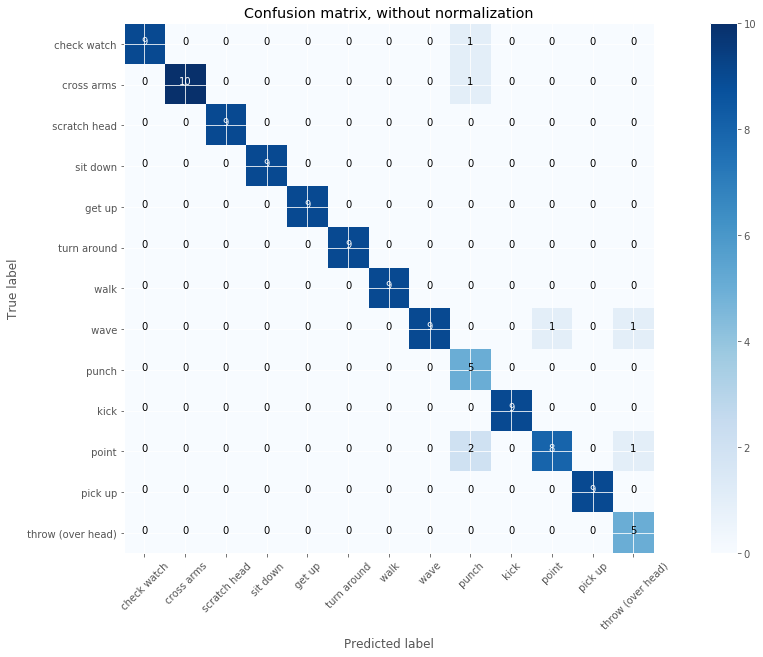

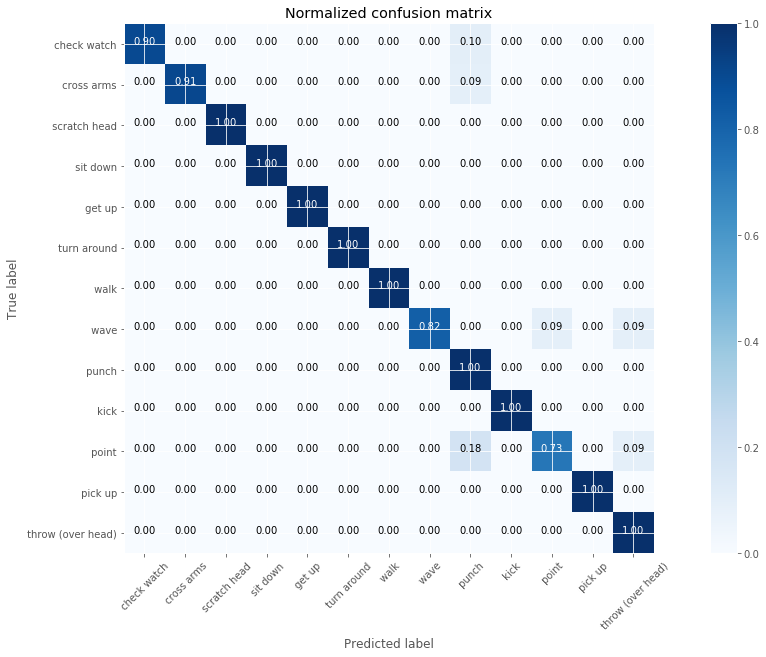

In [45]:
#function for printing the unnormalized and normalized confusion matrix ( function taken from scikit documentation ) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()